# NFL Awards Prediction
Evan Stowell and Jacob Namath

We are trying to determine the recipients of the National Football League’s most coveted individual awards, given by the Associated Press. The Most Valuable Player (MVP), Offensive Player of The Year (OPOY), Defensive Player of The Year (DPOY), Offensive Rookie of The Year (OROY), and the Defensive Rookie of The Year (DROY). These awards are often very difficult to predict because of many different factors. Coaching, scheme, other players on the team. This is a problem because many people like to waste money gambling on these awards throughout the season. Our approach is going to be trying to find the best model that takes in information from past years to predict this year's award recipients, based on halfway through the season statistics. This is related to other work in the area because sports analytics is exploding right now. Teams and media companies have data analytics departments who want to predict the best of the best each year. Teams will try to predict how likely a catch is to be completed, average yards over expected, probability of scoring, and many other events and outcomes.

Specifically, we are interested in discovering to what extent certain statistics contribute to the number of award votes a player receives. And with this, we hope to create models capable of predicting how many votes any given player will receive. Our inputs will slightly differ depending on the award winner we are predicting and the position of the player in contention. For quarterbacks (QBs), we will mainly consider QB specific stats such as pass completion rate, yards gained by passing, passing touchdowns, and rushing touchdowns. For offensive non-QB players, namely wide receivers (WRs), running backs (RBs), and tight ends (TEs), we will consider passing/rushing yards, passing/rushing yards, and receptions/rushing attempts. For defensive players, we will consider relevant statistics such as tackles, sacks, and interceptions. Finally, with rookie voting, we will consider both offensive and defensive statistics, as well as time played as a measure of how important they are to the team. For all awards, we will also factor the team which they play to determine if a team’s quality affects an individual player’s standing in the voting.

This problem interests us because awards build a player’s legacy and are viewed as proof of greatness. However, it is very unlikely to attain unanimous agreement for which player was the greatest in any given season due to biases and media narratives. The most objective truth one can rely on for these debates are statistics. We hope that the results of our analysis will show how much statistics contribute to a player’s case for an award and how the differences between our expectations and reality reflect on inherent biases in football.

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    RandomizedSearchCV, KFold
)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    LogisticRegression, LassoCV
)

from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier,
    VotingRegressor
)

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor, MLPClassifier

import xgboost as xgb

from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We are using the football database called Pro Football Reference. Every player who received a vote appears in the tables and their basic statistics relevant to their position are displayed. We took data from the 5 big player awards and added in statistics from each year to try to go beyond the basic statistics that were included.

# Loading in Data

In [3]:
data_path = '/content/drive/MyDrive/CS3540/Project/'
# Load all 5 datasets
try:
    mvp_df = pd.read_csv(data_path + 'mvp_df_final_clean.csv')
    opoy_df = pd.read_csv(data_path + 'opoy_df_final_clean.csv')
    dpoy_df = pd.read_csv(data_path + 'dpoy_df_final_clean.csv')
    oroy_df = pd.read_csv(data_path + 'oroy_df_final_clean.csv')
    droy_df = pd.read_csv(data_path + 'droy_df_final_clean.csv')

    print("\n All datasets loaded successfully\n")

    # Display dataset information
    datasets = {
        'MVP': mvp_df,
        'OPOY': opoy_df,
        'DPOY': dpoy_df,
        'OROY': oroy_df,
        'DROY': droy_df
    }

    print("Dataset Summary:")
    print("-" * 60)
    for name, df in datasets.items():
        print(f"{name:6} | Rows: {len(df):4} | Columns: {len(df.columns):2}")
    print("-" * 60)

except FileNotFoundError as e:
    print(f"\nError: Could not find one or more CSV files.")
    print(f"Please ensure all files are uploaded to Colab:")
    print("mvp_df_final_clean.csv")
    print("opoy_df_final_clean.csv")
    print("dpoy_df_final_clean.csv")
    print("oroy_df_final_clean.csv")
    print("droy_df_final_clean.csv")
    raise


 All datasets loaded successfully

Dataset Summary:
------------------------------------------------------------
MVP    | Rows:  228 | Columns: 53
OPOY   | Rows:  277 | Columns: 71
DPOY   | Rows:  331 | Columns: 22
OROY   | Rows:  185 | Columns: 21
DROY   | Rows:  229 | Columns: 16
------------------------------------------------------------


In [4]:
def display_dataset_info(df, award_name):
    """Display information about a dataset"""
    print(f"\n{award_name} Dataset Analysis")
    print("-" * 60)
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"\nColumn Names:\n{list(df.columns)}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    print(f"\nFirst 5 rows:")
    display(df.head())
    print(f"\nBasic Statistics:")
    display(df.describe())
    print("\n" + "-" * 60)

# Display information for each dataset
for name, df in datasets.items():
    display_dataset_info(df, name)



MVP Dataset Analysis
------------------------------------------------------------
Shape: 228 rows × 53 columns

Column Names:
['Unnamed: 0', 'Year', 'Rank', 'Player', 'Votes', 'Games', 'Games_Started', 'Age', 'Pass_QBrec', 'Pass_Rate', 'Pass_QBR', 'Pass_Y_per_A', 'Pass_AY_per_A', 'Pass_Y_per_C', 'Pass_Y_per_G', 'Pass_NY_per_A', 'Pass_ANY_per_A', 'Pass_Sk', 'Pass_4QC', 'Pass_GWD', 'Pass_Completions', 'Pass_Attempts', 'Pass_Yards', 'Pass_Touchdowns', 'Pass_Interceptions', 'Rush_Attempts', 'Rush_Yards', 'Rush_Touchdowns', 'Scrim_Receiving_Tgt', 'Scrim_Receiving_Y_R', 'Scrim_Receiving_1D', 'Scrim_Receiving_Succ_Pct', 'Scrim_Receiving_Lng', 'Scrim_Receiving_R_G', 'Scrim_Receiving_Y_G', 'Scrim_Receiving_Ctch_Pct', 'Scrim_Receiving_Y_Tgt', 'Rec_Receptions', 'Rec_Yards', 'Rec_Touchdowns', 'Scrim_Scrimmage_Touch', 'Scrim_Scrimmage_Y_Tch', 'Scrim_Scrimmage_YScm', 'Scrim_Scrimmage_RRTD', 'Def_Solo', 'Def_Sk', 'Def_Int', 'Scrim_Rushing_1D', 'Scrim_Rushing_Succ_Pct', 'Scrim_Rushing_Lng', 'Scrim_Ru

Unnamed: 0  Year  Rank          Player  Votes  Games  Games_Started   Age  \
0           0  2024     1      Josh Allen   90.0     17             17  28.0   
1           1  2024     2   Lamar Jackson   84.0     17             17  27.0   
2           2  2024     3  Saquon Barkley   28.0     16             16  27.0   
3           3  2024     4      Joe Burrow   20.0     17             17  28.0   
4           4  2024     5      Jared Goff   11.0     17             17  30.0   

   Pass_QBrec  Pass_Rate  ...  Scrim_Scrimmage_RRTD  Def_Solo  Def_Sk  \
0         NaN      101.4  ...                  13.0       0.0     0.0   
1         NaN      119.6  ...                   4.0       0.0     0.0   
2         NaN        NaN  ...                  15.0       0.0     0.0   
3         NaN      108.5  ...                   2.0       0.0     0.0   
4         NaN      111.8  ...                   1.0       0.0     0.0   

   Def_Int  Scrim_Rushing_1D  Scrim_Rushing_Succ_Pct  Scrim_Rushing_Lng  \
0      0.0              52.0                    64.7               30.0   
1      0.0              47.0                    56.1               48.0   
2      0.0              82.0                    52.5               72.0   
3      0.0              16.0                    47.6               47.0   
4      0.0               9.0                    34.3               10.0   

   Scrim_Rushing_Y_A  Scrim_Rushing_Y_G  Scrim_Rushing_A_G  
0                5.2               31.2                6.0  
1                6.6               53.8                8.2  
2                5.8              125.3               21.6  
3                4.8               11.8                2.5  
4                1.6                3.3                2.1  

[5 rows x 53 columns]


Basic Statistics:


Unnamed: 0         Year        Rank       Votes       Games  \
count   228.00000   228.000000  228.000000  225.000000  228.000000   
mean    113.50000  2001.552632    3.868421   14.955556   15.495614   
std      65.96211    14.150290    2.738253   19.939927    1.488570   
min       0.00000  1980.000000    1.000000    1.000000    8.000000   
25%      56.75000  1989.750000    2.000000    1.000000   15.000000   
50%     113.50000  2000.000000    3.000000    6.000000   16.000000   
75%     170.25000  2014.250000    5.000000   21.000000   16.000000   
max     227.00000  2024.000000   15.000000  117.000000   17.000000   

       Games_Started         Age  Pass_QBrec   Pass_Rate   Pass_QBR  ...  \
count     228.000000  207.000000         0.0  158.000000  69.000000  ...   
mean       15.245614   28.574879         NaN   94.748734  70.242029  ...   
std         2.041686    4.579709         NaN   22.792701  14.761042  ...   
min         0.000000   21.000000         NaN    0.000000   0.100000  ...   
25%        15.000000   25.000000         NaN   89.050000  63.500000  ...   
50%        16.000000   28.000000         NaN   97.400000  72.800000  ...   
75%        16.000000   32.000000         NaN  105.725000  79.000000  ...   
max        17.000000   44.000000         NaN  158.300000  99.700000  ...   

       Scrim_Scrimmage_RRTD    Def_Solo      Def_Sk     Def_Int  \
count            207.000000  136.000000  228.000000  228.000000   
mean               6.579710    6.330882    1.006579    0.171053   
std                7.153801   20.945451    3.762053    0.876338   
min                0.000000    0.000000    0.000000    0.000000   
25%                1.000000    0.000000    0.000000    0.000000   
50%                3.000000    0.000000    0.000000    0.000000   
75%               11.500000    0.000000    0.000000    0.000000   
max               31.000000  121.000000   20.500000    7.000000   

       Scrim_Rushing_1D  Scrim_Rushing_Succ_Pct  Scrim_Rushing_Lng  \
count        207.000000              201.000000         200.000000   
mean          32.536232               45.004478          31.480000   
std           33.550099               16.115084          22.195785   
min            0.000000                0.000000           1.000000   
25%            5.000000               36.000000          15.000000   
50%           17.000000               48.200000          23.000000   
75%           60.500000               54.000000          46.250000   
max          116.000000              100.000000          95.000000   

       Scrim_Rushing_Y_A  Scrim_Rushing_Y_G  Scrim_Rushing_A_G  
count         201.000000         207.000000         207.000000  
mean            4.020896          35.671014           7.614010  
std             2.460581          42.767161           8.566431  
min            -1.000000          -1.900000           0.000000  
25%             2.600000           3.500000           1.700000  
50%             4.400000          13.300000           3.200000  
75%             5.100000          76.250000          13.150000  
max            23.000000         131.600000          25.600000  

[8 rows x 52 columns]


------------------------------------------------------------

OPOY Dataset Analysis
------------------------------------------------------------
Shape: 277 rows × 71 columns

Column Names:
['Unnamed: 0', 'Year', 'Rank', 'Player', 'Team', 'Position', 'Votes', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Pass_Int', 'Rush_Att', 'Rush_Yds', 'Rush_TD', 'Rec_Rec', 'Rec_Yds', 'Rec_TD', 'PFR_Pass_Tm', 'PFR_Pass_Age', 'PFR_Pass_Position', 'PFR_Pass_G', 'PFR_Pass_GS', 'PFR_Pass_QBrec', 'PFR_Pass_Cmp', 'PFR_Pass_Att', 'PFR_Pass_Yds', 'PFR_Pass_TD', 'PFR_Pass_Int', 'PFR_Pass_Rate', 'PFR_Pass_QBR', 'PFR_Pass_Y/A', 'PFR_Pass_AY/A', 'PFR_Pass_Y/C', 'PFR_Pass_Y/G', 'PFR_Pass_NY/A', 'PFR_Pass_ANY/A', 'PFR_Pass_Sk', 'PFR_Pass_4QC', 'PFR_Pass_GWD', 'PFR_Scrim_Unnamed:_2_level_0_Age', 'PFR_Scrim_Scrimmage_Touch', 'PFR_Scrim_Scrimmage_Y_Tch', 'PFR_Scrim_Scrimmage_YScm', 'PFR_Scrim_Scrimmage_RRTD', 'PFR_Scrim_Unnamed:_4_level_0_Pos', 'PFR_Scrim_Unnamed:_5_level_0_G', 'PFR_Scrim_Unnamed:_6_lev

Unnamed: 0  Year  Rank          Player                 Team Position  \
0           0  2024     1  Saquon Barkley  Philadelphia Eagles       RB   
1           1  2024     2   Lamar Jackson     Baltimore Ravens       QB   
2           2  2024     3   Ja'Marr Chase   Cincinnati Bengals       WR   
3           3  2024     4   Derrick Henry     Baltimore Ravens       RB   
4           4  2024     5      Joe Burrow   Cincinnati Bengals       QB   

   Votes   G  GS  Pass_Cmp  ...  PFR_Scrim_Receiving_Y_Tgt  \
0   94.0  16  16         0  ...                        6.5   
1   43.0  17  17       316  ...                        NaN   
2   40.0  17  16         0  ...                        9.8   
3   21.0  17  17         0  ...                        8.8   
4   19.0  17  17       460  ...                        NaN   

   PFR_Scrim_Rushing_Att  PFR_Scrim_Rushing_Yds  PFR_Scrim_Rushing_TD  \
0                  345.0                 2005.0                  13.0   
1                  139.0                  915.0                   4.0   
2                    3.0                   32.0                   0.0   
3                  325.0                 1921.0                  16.0   
4                   42.0                  201.0                   2.0   

   PFR_Scrim_Rushing_1D  PFR_Scrim_Rushing_Succ%  PFR_Scrim_Rushing_Lng  \
0                  82.0                     52.5                   72.0   
1                  47.0                     56.1                   48.0   
2                   2.0                    100.0                   14.0   
3                  94.0                     58.8                   87.0   
4                  16.0                     47.6                   47.0   

   PFR_Scrim_Rushing_Y_A  PFR_Scrim_Rushing_Y_G  PFR_Scrim_Rushing_A_G  
0                    5.8                  125.3                   21.6  
1                    6.6                   53.8                    8.2  
2                   10.7                    1.9                    0.2  
3                    5.9                  113.0                   19.1  
4                    4.8                   11.8                    2.5  

[5 rows x 71 columns]


Basic Statistics:


Unnamed: 0         Year        Rank       Votes           G  \
count   277.00000   277.000000  277.000000  270.000000  277.000000   
mean    138.00000  2003.379061    4.158845   11.214815   15.563177   
std      80.10722    14.005071    3.023465   14.356849    1.404115   
min       0.00000  1980.000000    1.000000    1.000000    8.000000   
25%      69.00000  1991.000000    2.000000    1.000000   15.000000   
50%     138.00000  2003.000000    4.000000    5.000000   16.000000   
75%     207.00000  2016.000000    5.000000   15.375000   16.000000   
max     276.00000  2024.000000   19.000000   94.000000   17.000000   

               GS    Pass_Cmp    Pass_Att     Pass_Yds     Pass_TD  ...  \
count  277.000000  277.000000  277.000000   277.000000  277.000000  ...   
mean    15.281588  146.610108  226.364621  1794.935018   13.953069  ...   
std      1.943063  170.390258  261.128614  2068.727648   16.470702  ...   
min      0.000000    0.000000    0.000000     0.000000    0.000000  ...   
25%     15.000000    0.000000    0.000000     0.000000    0.000000  ...   
50%     16.000000    1.000000    2.000000    16.000000    0.000000  ...   
75%     16.000000  324.000000  499.000000  3969.000000   29.000000  ...   
max     17.000000  485.000000  719.000000  5477.000000   55.000000  ...   

       PFR_Scrim_Receiving_Y_Tgt  PFR_Scrim_Rushing_Att  \
count                 169.000000             272.000000   
mean                    7.392308             132.919118   
std                     4.675455             141.883563   
min                    -6.000000               0.000000   
25%                     5.800000              21.000000   
50%                     7.300000              52.500000   
75%                     9.300000             287.250000   
max                    38.000000             410.000000   

       PFR_Scrim_Rushing_Yds  PFR_Scrim_Rushing_TD  PFR_Scrim_Rushing_1D  \
count             272.000000            272.000000            272.000000   
mean              628.661765              5.610294             35.128676   
std               699.908046              6.410523             35.167522   
min               -31.000000              0.000000              0.000000   
25%                33.000000              0.000000              4.000000   
50%               248.500000              2.000000             18.500000   
75%              1359.500000             11.000000             71.000000   
max              2105.000000             28.000000            116.000000   

       PFR_Scrim_Rushing_Succ%  PFR_Scrim_Rushing_Lng  PFR_Scrim_Rushing_Y_A  \
count               254.000000             253.000000             254.000000   
mean                 46.633071              34.588933               4.143701   
std                  17.516601              24.628771               2.743289   
min                   0.000000              -9.000000              -9.000000   
25%                  40.625000              15.000000               3.000000   
50%                  49.300000              25.000000               4.550000   
75%                  54.200000              52.000000               5.200000   
max                 100.000000              95.000000              23.000000   

       PFR_Scrim_Rushing_Y_G  PFR_Scrim_Rushing_A_G  
count             272.000000             272.000000  
mean               40.416176               8.554044  
std                44.499163               9.028846  
min                -1.900000               0.000000  
25%                 2.175000               1.375000  
50%                16.100000               3.350000  
75%                88.850000              18.325000  
max               131.600000              25.600000  

[8 rows x 64 columns]


------------------------------------------------------------

DPOY Dataset Analysis
------------------------------------------------------------
Shape: 331 rows × 22 columns

Column Names:
['Year', 'Rank', 'Player', 'Team', 'Position', 'Votes', 'Age', 'G', 'GS', 'Comb', 'Solo', 'Ast', 'TFL', 'Sk', 'QBHits', 'Int', 'Int_Yds', 'Int_TD', 'PD', 'FF', 'FR', 'Sfty']

Data Types:
Year          int64
Rank          int64
Player       object
Team         object
Position     object
Votes       float64
Age         float64
G           float64
GS          float64
Comb        float64
Solo        float64
Ast         float64
TFL         float64
Sk          float64
QBHits      float64
Int         float64
Int_Yds     float64
Int_TD      float64
PD          float64
FF          float64
FR          float64
Sfty        float64
dtype: object

Missing Values:
Year          0
Rank          0
Player        0
Team          0
Position      0
Votes         7
Age           1
G             0
GS            0
Comb    

Year  Rank              Player                 Team Position  Votes   Age  \
0  2024     1  Patrick Surtain II       Denver Broncos       CB   76.0  24.0   
1  2024     2    Trey Hendrickson   Cincinnati Bengals       DE   48.0  30.0   
2  2024     3       Myles Garrett     Cleveland Browns       DE   37.0  29.0   
3  2024     4           T.J. Watt  Pittsburgh Steelers       LB   26.0  30.0   
4  2024     5           Zack Baun  Philadelphia Eagles       LB   15.0  28.0   

      G    GS   Comb  ...   TFL    Sk  QBHits  Int  Int_Yds  Int_TD    PD  \
0  16.0  16.0   45.0  ...   1.0   0.0     0.0  4.0    132.0     1.0  11.0   
1  17.0  17.0   46.0  ...  19.0  17.5    36.0  0.0      0.0     0.0   6.0   
2  17.0  17.0   47.0  ...  22.0  14.0    28.0  0.0      0.0     0.0   1.0   
3  17.0  17.0   61.0  ...  19.0  11.5    27.0  0.0      0.0     0.0   4.0   
4  16.0  16.0  151.0  ...  11.0   3.5     5.0  1.0      0.0     0.0   4.0   

    FF   FR  Sfty  
0  1.0  1.0   0.0  
1  2.0  0.0   0.0  
2  3.0  1.0   0.0  
3  6.0  2.0   0.0  
4  5.0  1.0   0.0  

[5 rows x 22 columns]


Basic Statistics:


Year        Rank       Votes         Age           G  \
count   331.000000  331.000000  324.000000  330.000000  331.000000   
mean   2001.383686    5.625378    9.145062   27.327273   15.531722   
std      13.809118    4.571833   13.378762    3.072901    1.511989   
min    1980.000000    1.000000    1.000000   22.000000    8.000000   
25%    1991.000000    2.000000    1.000000   25.000000   16.000000   
50%    1999.000000    4.000000    3.000000   27.000000   16.000000   
75%    2013.000000    7.000000   11.000000   29.000000   16.000000   
max    2024.000000   24.000000   76.000000   37.000000   17.000000   

               GS        Comb        Solo         Ast         TFL          Sk  \
count  331.000000  330.000000  330.000000  330.000000  169.000000  330.000000   
mean    15.247734   65.824242   52.545455   13.278788   12.236686    8.559091   
std      1.970760   43.907052   36.854673   14.042310    7.203890    6.539824   
min      2.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     15.000000   44.000000   33.000000    0.000000    7.000000    2.000000   
50%     16.000000   63.000000   49.000000   11.000000   12.000000    8.500000   
75%     16.000000   92.000000   76.000000   20.000000   17.000000   14.000000   
max     17.000000  214.000000  214.000000   80.000000   39.000000   22.500000   

           QBHits         Int     Int_Yds      Int_TD          PD          FF  \
count  127.000000  330.000000  330.000000  330.000000  169.000000  268.000000   
mean    18.133858    1.869697   32.730303    0.309091    7.372781    2.529851   
std     13.776770    2.720739   58.611259    0.702736    5.694355    2.032287   
min      0.000000    0.000000   -4.000000    0.000000    0.000000    0.000000   
25%      4.000000    0.000000    0.000000    0.000000    3.000000    1.000000   
50%     20.000000    1.000000    0.000000    0.000000    6.000000    2.000000   
75%     28.000000    3.000000   46.500000    0.000000   11.000000    4.000000   
max     51.000000   13.000000  376.000000    5.000000   31.000000    9.000000   

               FR        Sfty  
count  330.000000  330.000000  
mean     1.178788    0.051515  
std      1.141177    0.247321  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      1.000000    0.000000  
75%      2.000000    0.000000  
max      5.000000    2.000000


------------------------------------------------------------

OROY Dataset Analysis
------------------------------------------------------------
Shape: 185 rows × 21 columns

Column Names:
['Year', 'Rank', 'Player', 'Team', 'Position', 'Votes', 'PFR_Age', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Pass_Int', 'PFR_Rate', 'Rush_Att', 'Rush_Yds', 'Rush_TD', 'Rec', 'Rec_Yds', 'Rec_TD']

Data Types:
Year          int64
Rank          int64
Player       object
Team         object
Position     object
Votes       float64
PFR_Age     float64
G             int64
GS            int64
Pass_Cmp    float64
Pass_Att      int64
Pass_Yds      int64
Pass_TD       int64
Pass_Int    float64
PFR_Rate    float64
Rush_Att    float64
Rush_Yds    float64
Rush_TD     float64
Rec         float64
Rec_Yds       int64
Rec_TD        int64
dtype: object

Missing Values:
Year          0
Rank          0
Player        0
Team          0
Position      0
Votes         6
PFR_Age     170
G             0
GS    

Year  Rank          Player                   Team Position  Votes  PFR_Age  \
0  2024     1  Jayden Daniels  Washington Commanders       QB  115.0     24.0   
1  2024     2    Brock Bowers      Las Vegas Raiders       TE   50.0      NaN   
2  2024     3          Bo Nix         Denver Broncos       QB   36.0     24.0   
3  2024     4    Brian Thomas   Jacksonville Jaguars       WR   19.0      NaN   
4  2024     5    Malik Nabers        New York Giants       WR   12.0     21.0   

    G  GS  Pass_Cmp  ...  Pass_Yds  Pass_TD  Pass_Int  PFR_Rate  Rush_Att  \
0  17  17     331.0  ...      3568       25       9.0     100.1     148.0   
1  17  16       NaN  ...         0        0       NaN       NaN       5.0   
2  17  17     376.0  ...      3775       29      12.0      93.3      92.0   
3  17  16       NaN  ...         0        0       NaN       NaN       6.0   
4  15  13       0.0  ...         0        0       0.0      39.6       5.0   

   Rush_Yds  Rush_TD    Rec  Rec_Yds  Rec_TD  
0     891.0      6.0    0.0        0       0  
1      13.0      0.0  112.0     1194       5  
2     430.0      4.0    1.0        2       1  
3      48.0      0.0   87.0     1282      10  
4       2.0      0.0  109.0     1204       7  

[5 rows x 21 columns]


Basic Statistics:


Year        Rank       Votes    PFR_Age           G          GS  \
count   185.000000  185.000000  179.000000  15.000000  185.000000  185.000000   
mean   2003.059459    3.216216   16.849162  22.666667   15.064865   11.648649   
std      13.716133    2.220643   21.095413   0.899735    2.060527    4.877946   
min    1980.000000    1.000000    1.000000  21.000000    4.000000    0.000000   
25%    1991.000000    2.000000    1.000000  22.000000   15.000000    9.000000   
50%    2002.000000    3.000000    8.000000  23.000000   16.000000   13.000000   
75%    2015.000000    4.000000   26.750000  23.000000   16.000000   16.000000   
max    2024.000000   11.000000  115.000000  24.000000   17.000000   17.000000   

         Pass_Cmp    Pass_Att     Pass_Yds     Pass_TD   Pass_Int   PFR_Rate  \
count   39.000000  185.000000   185.000000  185.000000  38.000000   15.00000   
mean   213.923077   74.367568   523.578378    3.259459  10.000000   87.54000   
std    125.464481  170.161161  1201.647540    7.529488   6.089424   21.02773   
min      0.000000    0.000000     0.000000    0.000000   0.000000   39.60000   
25%    123.000000    0.000000     0.000000    0.000000   5.250000   87.60000   
50%    245.000000    0.000000     0.000000    0.000000  10.500000   93.30000   
75%    315.500000    0.000000     0.000000    0.000000  13.750000  100.45000   
max    396.000000  627.000000  4374.000000   31.000000  28.000000  107.30000   

         Rush_Att     Rush_Yds     Rush_TD         Rec      Rec_Yds  \
count  144.000000   144.000000  120.000000  141.000000   185.000000   
mean   127.979167   581.111111    5.525000   40.758865   369.724324   
std    117.352226   525.783160    4.541059   27.322126   402.176125   
min      0.000000   -11.000000    0.000000    0.000000    -8.000000   
25%     11.750000    61.500000    1.750000   21.000000     0.000000   
50%     95.000000   489.000000    4.000000   38.000000   228.000000   
75%    233.250000  1074.500000    8.000000   58.000000   624.000000   
max    390.000000  1808.000000   18.000000  112.000000  1486.000000   

           Rec_TD  
count  185.000000  
mean     2.329730  
std      3.307507  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      4.000000  
max     17.000000


------------------------------------------------------------

DROY Dataset Analysis
------------------------------------------------------------
Shape: 229 rows × 16 columns

Column Names:
['Year', 'Rank', 'Player', 'Team', 'Position', 'Votes', 'G', 'GS', 'Def_Comb', 'Def_Solo', 'Def_Ast', 'Def_TFL', 'Def_QBHits', 'Def_PD', 'Def_FR', 'Def_FF']

Data Types:
Year            int64
Rank            int64
Player         object
Team           object
Position       object
Votes         float64
G               int64
GS              int64
Def_Comb      float64
Def_Solo      float64
Def_Ast       float64
Def_TFL       float64
Def_QBHits    float64
Def_PD        float64
Def_FR          int64
Def_FF        float64
dtype: object

Missing Values:
Year            0
Rank            0
Player          0
Team            0
Position        0
Votes          13
G               0
GS              0
Def_Comb        0
Def_Solo        0
Def_Ast         0
Def_TFL       107
Def_QBHits    141
Def_PD        107
Def_F

Year  Rank            Player                 Team Position  Votes   G  GS  \
0  2024     1       Jared Verse     Los Angeles Rams      OLB   99.0  17  16   
1  2024     2  Quinyon Mitchell  Philadelphia Eagles       CB   56.0  16  16   
2  2024     3      Braden Fiske     Los Angeles Rams       DE   23.0  17   8   
3  2024     4     Cooper DeJean  Philadelphia Eagles       DB   21.0  16   9   
4  2024     5     Chop Robinson       Miami Dolphins       LB   17.0  17   1   

   Def_Comb  Def_Solo  Def_Ast  Def_TFL  Def_QBHits  Def_PD  Def_FR  Def_FF  
0      66.0      36.0     30.0     11.0        18.0     2.0       2     2.0  
1      46.0      37.0      9.0      0.0         0.0    12.0       0     0.0  
2      44.0      20.0     24.0     10.0        10.0     0.0       2     2.0  
3      51.0      38.0     13.0      3.0         1.0     6.0       3     1.0  
4      26.0      16.0     10.0      8.0        14.0     4.0       0     0.0


Basic Statistics:


Year        Rank       Votes           G          GS  \
count   229.000000  229.000000  216.000000  229.000000  229.000000   
mean   2001.458515    3.995633   13.185185   15.235808   12.550218   
std      14.229457    3.025473   16.915466    1.815221    4.409257   
min    1980.000000    1.000000    1.000000    7.000000    0.000000   
25%    1990.000000    2.000000    1.000000   15.000000   11.000000   
50%    2001.000000    3.000000    5.000000   16.000000   14.000000   
75%    2014.000000    5.000000   21.000000   16.000000   16.000000   
max    2024.000000   16.000000   99.000000   17.000000   17.000000   

         Def_Comb    Def_Solo     Def_Ast     Def_TFL  Def_QBHits      Def_PD  \
count  229.000000  229.000000  229.000000  122.000000   88.000000  122.000000   
mean    60.262009   48.148472   12.113537    7.663934    7.750000    6.885246   
std     40.982253   34.274751   13.350381    5.533684    8.146997    5.889052   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     36.000000   29.000000    0.000000    3.000000    1.000000    2.000000   
50%     59.000000   45.000000   10.000000    7.000000    5.000000    5.000000   
75%     84.000000   69.000000   17.000000   11.750000   12.000000   10.000000   
max    174.000000  153.000000   72.000000   23.000000   30.000000   26.000000   

           Def_FR      Def_FF  
count  229.000000  182.000000  
mean     0.868996    1.252747  
std      0.986910    1.449659  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      1.000000    1.000000  
75%      1.000000    2.000000  
max      4.000000    9.000000


------------------------------------------------------------


In [5]:
def clean_numeric(df):
    """
    Get numeric columns cleaned for EDA:
    - Drop obvious ID-like columns (e.g., Unnamed: 0)
    - Drop all-NaN columns
    - Drop constant columns (zero variance)
    """
    num = df.select_dtypes(include=[np.number]).copy()

    # Drop ID-like column if present
    if 'Unnamed: 0' in num.columns:
        num = num.drop(columns=['Unnamed: 0'])

    # Drop columns that are entirely NaN
    num = num.dropna(axis=1, how='all')

    # Drop constant columns (zero variance)
    nunique = num.nunique()
    num = num.loc[:, nunique > 1]

    return num


# Data Exploration

In [6]:
def explore_data_distribution(modeling_data, award_name):
    """
    Visualize data distributions to understand complexity.
    Uses cleaned numeric features (no constant / all-NaN columns)
    and standardized PCA.
    """
    data = modeling_data[award_name]
    X_train = data['X_train']
    y_train = data['y_train']

    # ---- Clean features for EDA (does NOT change modeling_data) ----
    X_eda = X_train.copy()

    # Drop all-NaN columns
    X_eda = X_eda.dropna(axis=1, how='all')

    # Drop constant columns (zero variance)
    nunique = X_eda.nunique()
    X_eda = X_eda.loc[:, nunique > 1]

    # If everything got dropped somehow, fall back to original
    if X_eda.shape[1] == 0:
        X_eda = X_train.copy()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Target distribution
    axes[0, 0].hist(y_train, bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title(f'{award_name}: Vote Distribution')
    axes[0, 0].set_xlabel('Votes')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(y_train.mean(), color='red', linestyle='--',
                       label=f'Mean: {y_train.mean():.1f}')
    axes[0, 0].axvline(y_train.median(), color='green', linestyle='--',
                       label=f'Median: {y_train.median():.1f}')
    axes[0, 0].legend()

    # 2. Log-transformed target (if skewed)
    skewness = y_train.skew()
    axes[0, 1].hist(np.log1p(y_train), bins=30, edgecolor='black',
                    alpha=0.7, color='orange')
    axes[0, 1].set_title(f'{award_name}: Log(Votes+1) Distribution\nSkewness: {skewness:.2f}')
    axes[0, 1].set_xlabel('Log(Votes+1)')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Feature correlation with target (using cleaned features)
    correlations = X_eda.corrwith(y_train).dropna().sort_values(ascending=False)
    top_10 = correlations.head(10)

    axes[1, 0].barh(range(len(top_10)), top_10.values)
    axes[1, 0].set_yticks(range(len(top_10)))
    axes[1, 0].set_yticklabels(top_10.index, fontsize=8)
    axes[1, 0].set_xlabel('Correlation with Votes')
    axes[1, 0].set_title(f'{award_name}: Top 10 Feature Correlations')
    axes[1, 0].invert_yaxis()

    # 4. PCA explained variance (on standardized features)
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_eda)

    pca = PCA()
    pca.fit(X_scaled)
    cumsum = np.cumsum(pca.explained_variance_ratio_)

    axes[1, 1].plot(range(1, len(cumsum) + 1), cumsum, marker='o')
    axes[1, 1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    axes[1, 1].set_xlabel('Number of Components')
    axes[1, 1].set_ylabel('Cumulative Explained Variance')
    axes[1, 1].set_title(f'{award_name}: PCA Variance Analysis')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Components needed for 95% variance
    if np.any(cumsum >= 0.95):
        n_components_95 = np.argmax(cumsum >= 0.95) + 1
    else:
        n_components_95 = len(cumsum)

    # Print statistics
    print(f"\n{award_name} Data Statistics:")
    print(f"Training samples: {len(X_train)}")
    print(f"Features (original X_train): {X_train.shape[1]}")
    print(f"Features used in EDA (after cleaning): {X_eda.shape[1]}")
    print(f"Vote range: [{y_train.min():.1f}, {y_train.max():.1f}]")
    print(f"Vote std: {y_train.std():.2f}")
    print(f"Skewness: {skewness:.2f} {'(highly skewed)' if abs(skewness) > 1 else ''}")
    print(f"Components for 95% variance: {n_components_95}")


## MVP Exploration

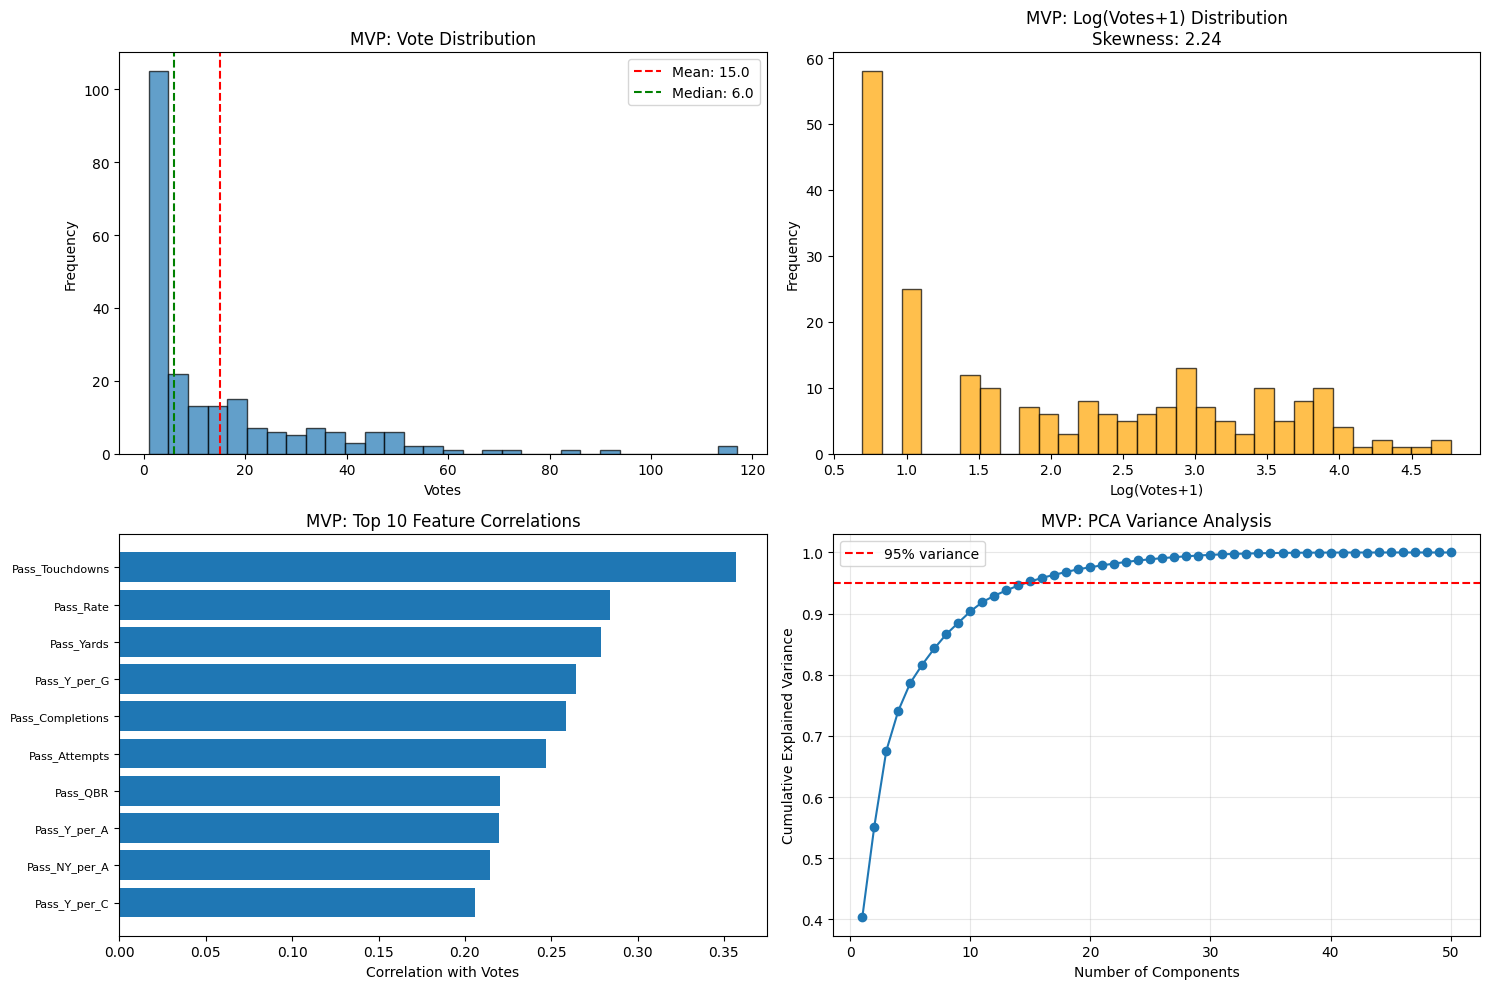


MVP Data Statistics:
Training samples: 228
Features (original X_train): 51
Features used in EDA (after cleaning): 50
Vote range: [1.0, 117.0]
Vote std: 19.94
Skewness: 2.24 (highly skewed)
Components for 95% variance: 15


In [7]:
mvp_numeric = mvp_df.select_dtypes(include=[np.number])

y_train_mvp = mvp_numeric["Votes"]
X_train_mvp = mvp_numeric.drop(columns=["Votes"]).fillna(0)

dist_data = {
    "MVP": {
        "X_train": X_train_mvp,
        "y_train": y_train_mvp
    }
}
explore_data_distribution(dist_data, "MVP")

## OPOY Exploration

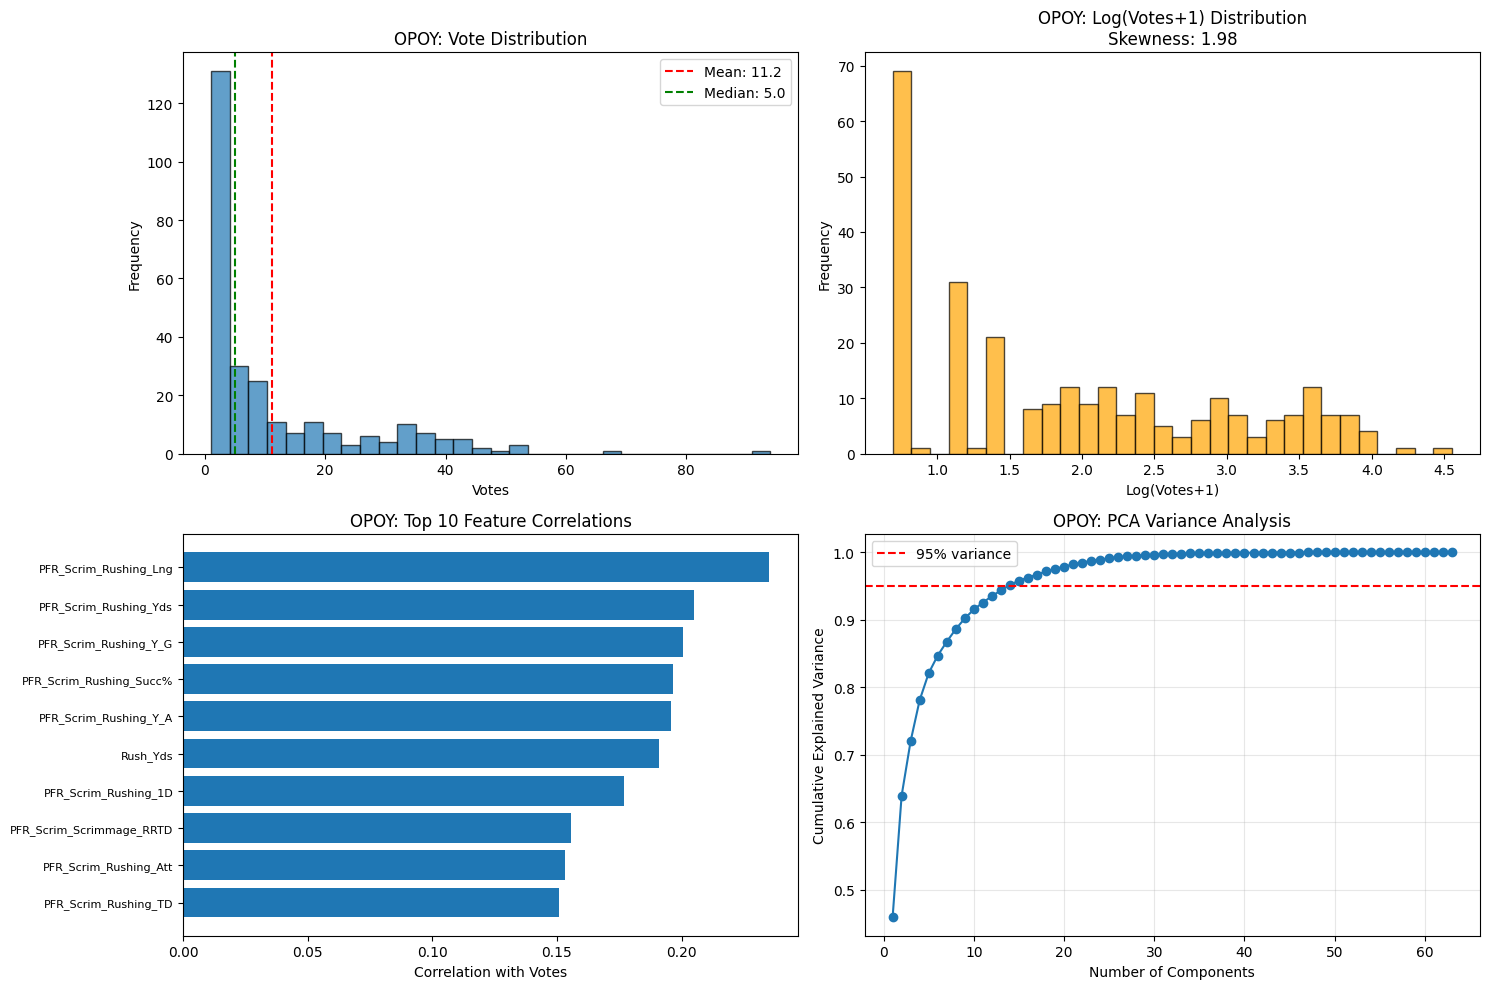


OPOY Data Statistics:
Training samples: 277
Features (original X_train): 63
Features used in EDA (after cleaning): 63
Vote range: [1.0, 94.0]
Vote std: 14.36
Skewness: 1.98 (highly skewed)
Components for 95% variance: 14


In [8]:
opoy_numeric = opoy_df.select_dtypes(include=[np.number])

y_train_opoy = opoy_numeric["Votes"]
X_train_opoy = opoy_numeric.drop(columns=["Votes"]).fillna(0)

dist_data = {
    "OPOY": {
        "X_train": X_train_opoy,
        "y_train": y_train_opoy
    }
}
explore_data_distribution(dist_data, "OPOY")

## DPOY Exploration

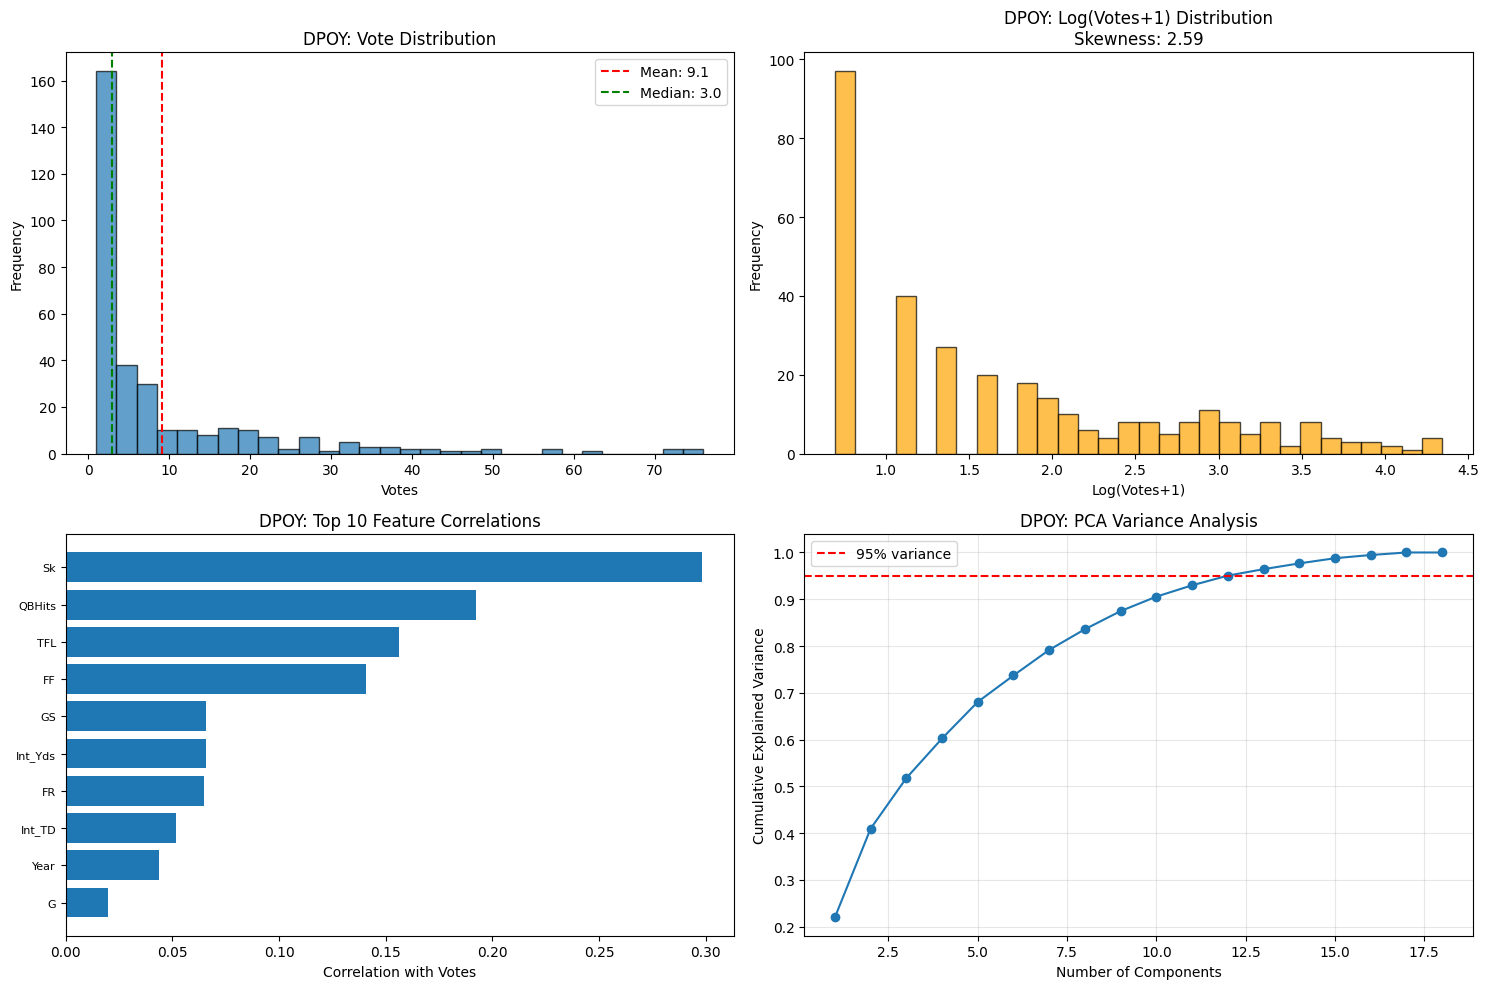


DPOY Data Statistics:
Training samples: 331
Features (original X_train): 18
Features used in EDA (after cleaning): 18
Vote range: [1.0, 76.0]
Vote std: 13.38
Skewness: 2.59 (highly skewed)
Components for 95% variance: 12


In [9]:
dpoy_numeric = dpoy_df.select_dtypes(include=[np.number])

y_train_dpoy = dpoy_numeric["Votes"]
X_train_dpoy = dpoy_numeric.drop(columns=["Votes"]).fillna(0)

dist_data = {
    "DPOY": {
        "X_train": X_train_dpoy,
        "y_train": y_train_dpoy
    }
}
explore_data_distribution(dist_data, "DPOY")

## OROY Exploration

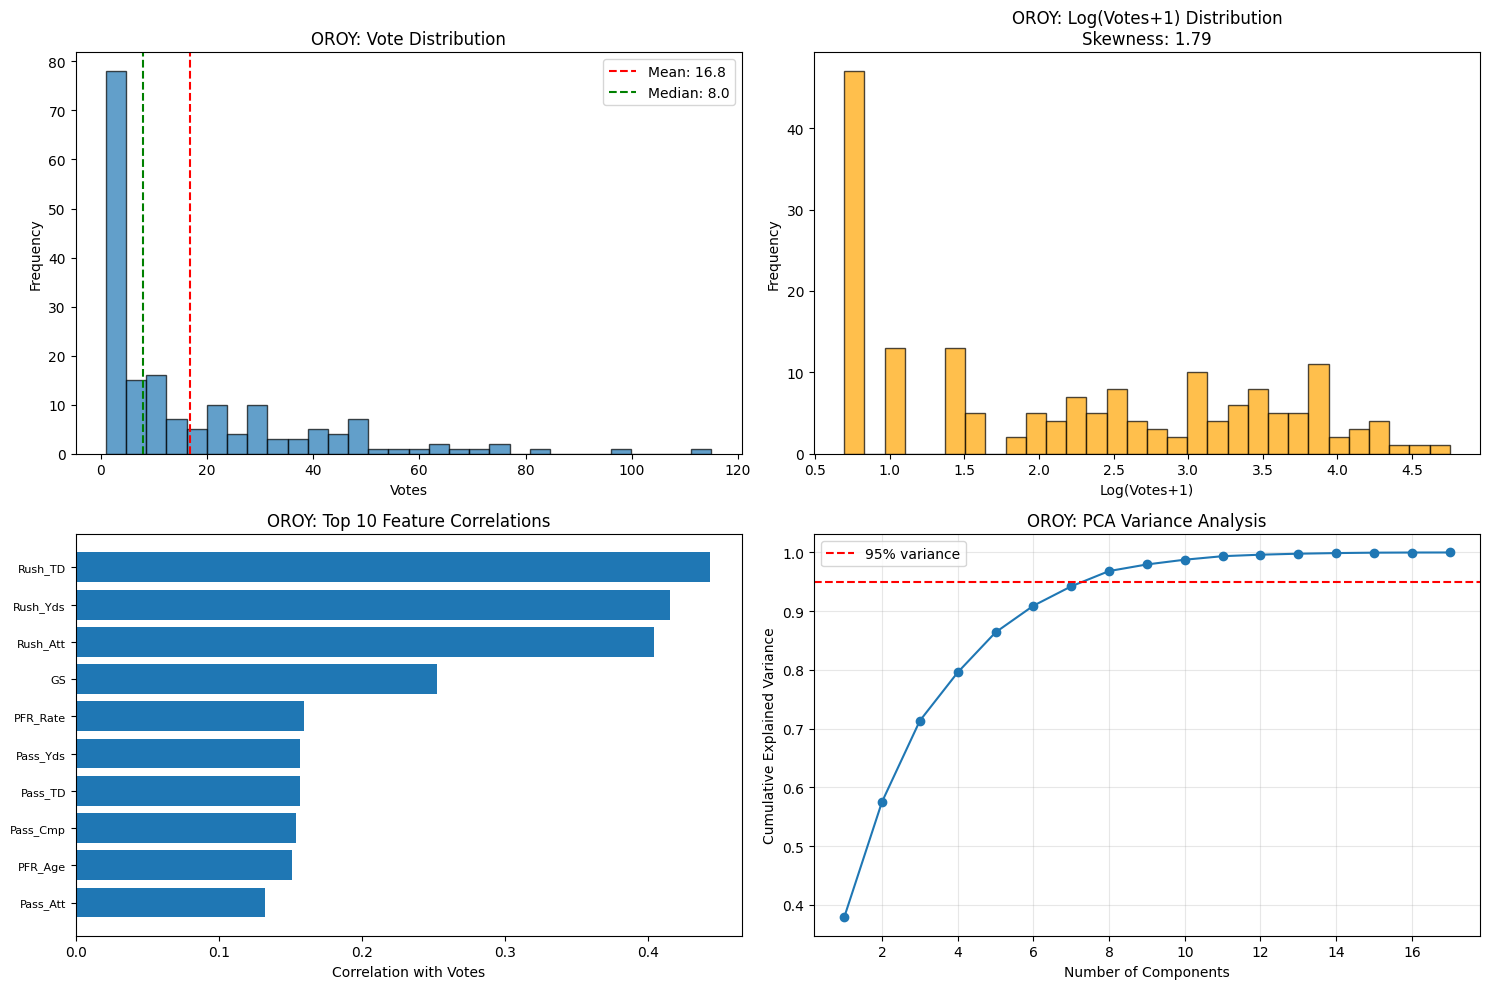


OROY Data Statistics:
Training samples: 185
Features (original X_train): 17
Features used in EDA (after cleaning): 17
Vote range: [1.0, 115.0]
Vote std: 21.10
Skewness: 1.79 (highly skewed)
Components for 95% variance: 8


In [10]:
oroy_numeric = oroy_df.select_dtypes(include=[np.number])

y_train_oroy = oroy_numeric["Votes"]
X_train_oroy = oroy_numeric.drop(columns=["Votes"]).fillna(0)

dist_data = {
    "OROY": {
        "X_train": X_train_oroy,
        "y_train": y_train_oroy
    }
}
explore_data_distribution(dist_data, "OROY")

## DROY Exploration

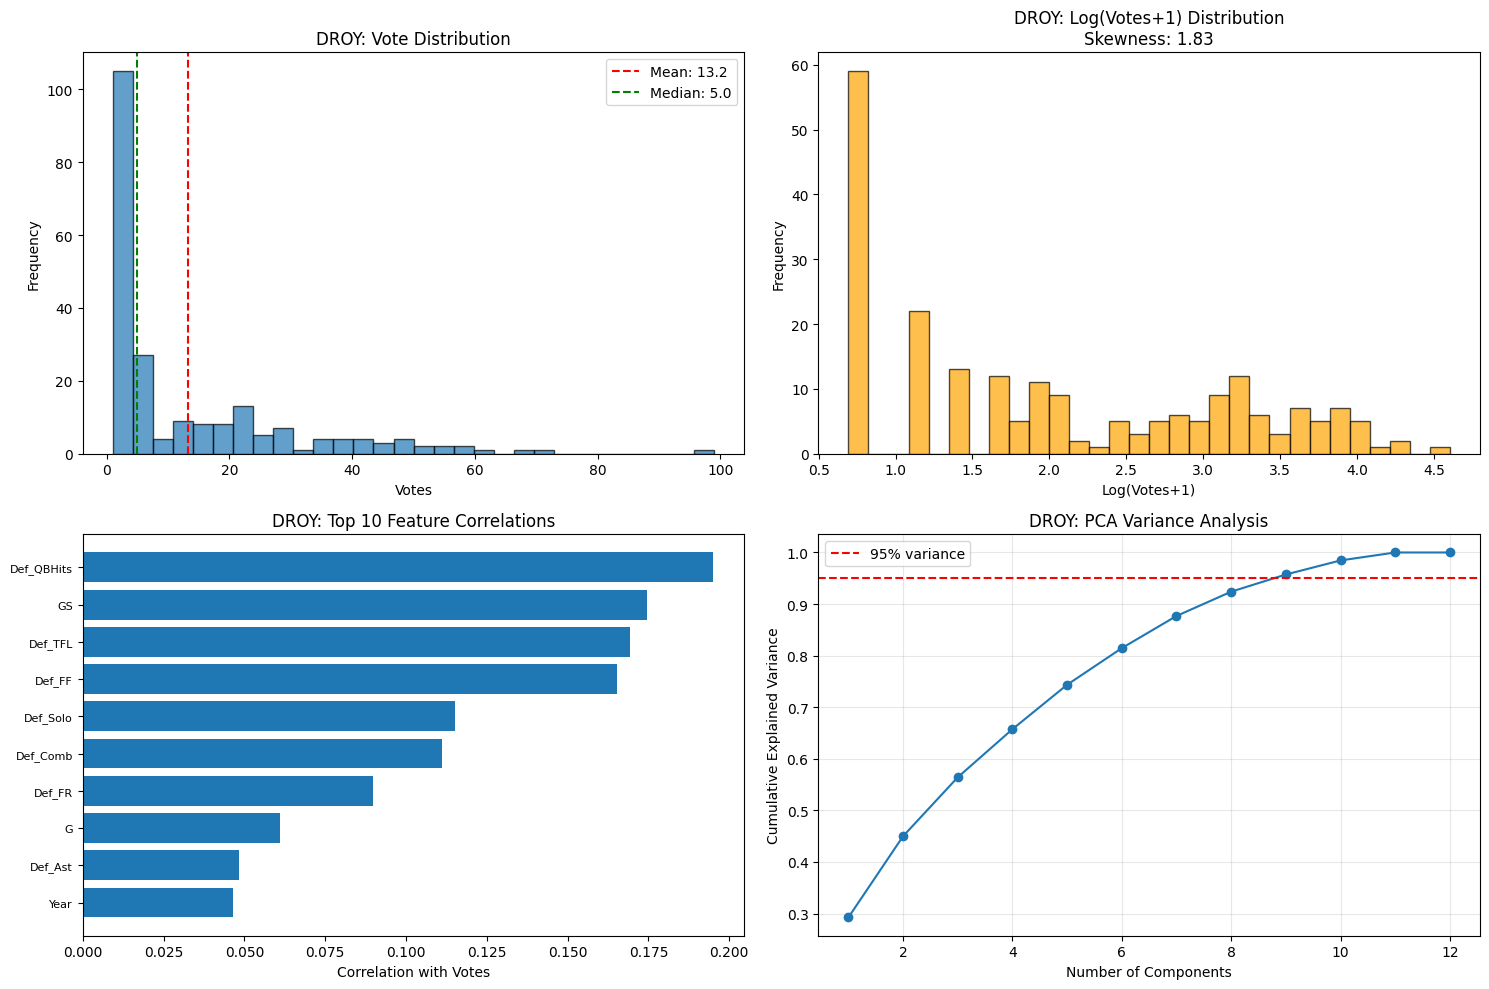


DROY Data Statistics:
Training samples: 229
Features (original X_train): 12
Features used in EDA (after cleaning): 12
Vote range: [1.0, 99.0]
Vote std: 16.92
Skewness: 1.83 (highly skewed)
Components for 95% variance: 9


In [11]:
droy_numeric = droy_df.select_dtypes(include=[np.number])

y_train_droy = droy_numeric["Votes"]
X_train_droy = droy_numeric.drop(columns=["Votes"]).fillna(0)

dist_data = {
    "DROY": {
        "X_train": X_train_droy,
        "y_train": y_train_droy
    }
}
explore_data_distribution(dist_data, "DROY")

# Correlation and visualizations

In [12]:
def visualize_award_data(df, award_name):
    """Create visualizations for award data (correlations + heatmap)."""
    print(f"\nGenerating visualizations for {award_name}...")

    # Clean numeric columns for EDA
    num = clean_numeric(df)

    # Identify votes column
    votes_col = None
    if 'Votes' in df.columns:
        votes_col = 'Votes'
    elif 'votes' in df.columns:
        votes_col = 'votes'

    if votes_col is None or votes_col not in num.columns:
        print(f"No numeric 'Votes' column found for {award_name}, skipping correlation plots.")
        return

    # ---- Correlations with votes ----
    corr_series = num.corr()[votes_col].drop(labels=[votes_col], errors='ignore').dropna()
    if corr_series.empty:
        print(f"No valid correlations found for {award_name}, skipping plots.")
        return

    corr_series = corr_series.sort_values(ascending=False)

    # Top correlations (positive and negative)
    top_n = min(15, len(corr_series))
    half = top_n // 2

    top_correlations = pd.concat([
        corr_series.head(half + 1),
        corr_series.tail(half)
    ]).sort_values(ascending=False)

    # --- Plot 1: Bar chart of top correlations with Votes ---
    plt.figure(figsize=(12, 6))
    colors = ['green' if x > 0 else 'red' for x in top_correlations.values]
    plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_correlations)), top_correlations.index)
    plt.xlabel('Correlation with Votes')
    plt.title(f'{award_name} - Top Features Correlated with Votes')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Focused correlation heatmap (only top correlated features) ---
    top_features = list(top_correlations.head(min(15, len(top_correlations))).index)
    if votes_col not in top_features:
        top_features.append(votes_col)

    # Make sure we only use columns that actually exist in num
    top_features = [f for f in top_features if f in num.columns]

    corr_subset = num[top_features].corr()

    plt.figure(figsize=(10, 8))
    # Mask upper triangle
    mask = np.triu(np.ones_like(corr_subset, dtype=bool))

    sns.heatmap(
        corr_subset,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8},
        vmin=-1,
        vmax=1
    )
    plt.title(f'{award_name} - Correlation Matrix (Top Features)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Print top 10 features ---
    print(f"\nTop 10 Features Most Correlated with Votes for {award_name}:")
    print("-" * 50)
    for i, (feat, corr) in enumerate(top_correlations.head(10).items(), 1):
        print(f"{i:2}. {feat:30} | r = {corr:+.3f}")
    print("-" * 50)


### MVP Visualizations


Generating visualizations for MVP...


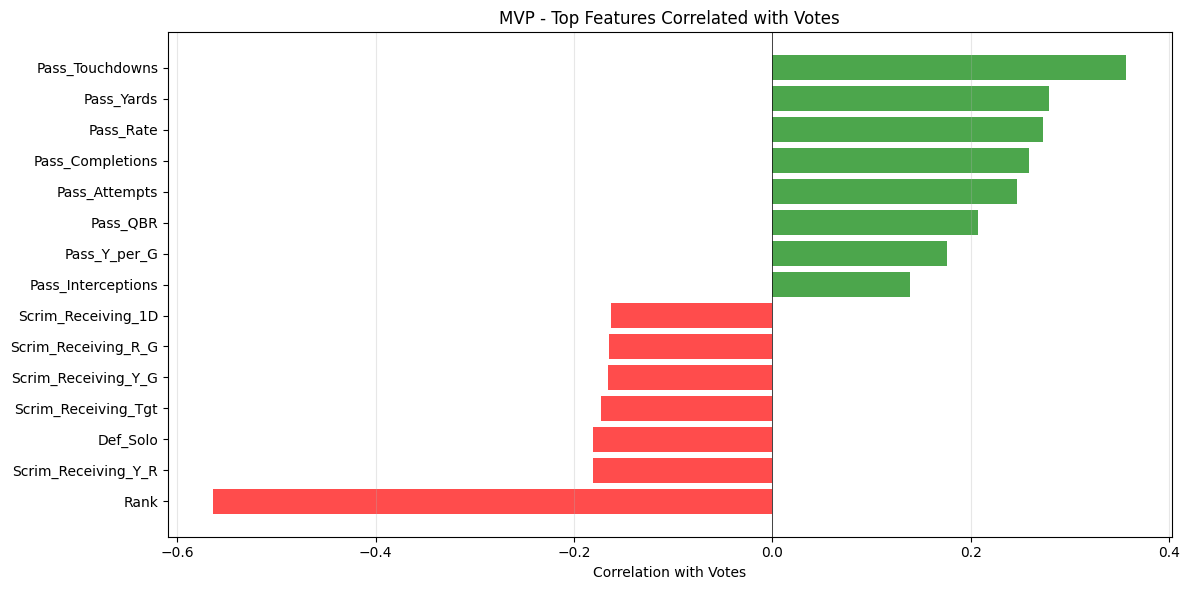

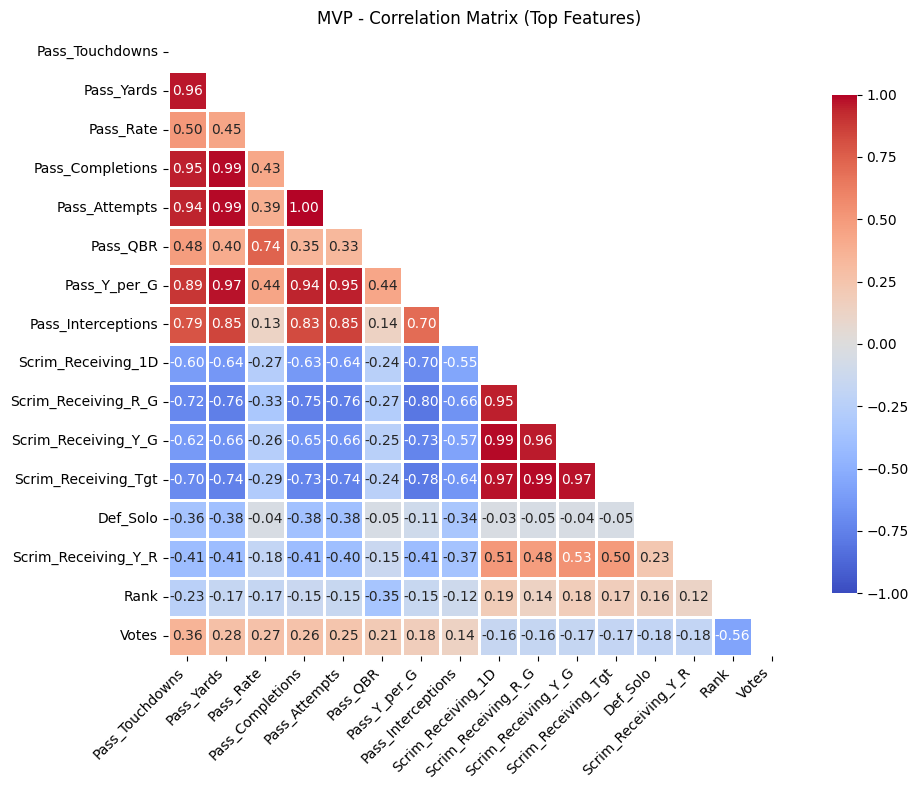


Top 10 Features Most Correlated with Votes for MVP:
--------------------------------------------------
 1. Pass_Touchdowns                | r = +0.357
 2. Pass_Yards                     | r = +0.279
 3. Pass_Rate                      | r = +0.273
 4. Pass_Completions               | r = +0.259
 5. Pass_Attempts                  | r = +0.247
 6. Pass_QBR                       | r = +0.207
 7. Pass_Y_per_G                   | r = +0.176
 8. Pass_Interceptions             | r = +0.139
 9. Scrim_Receiving_1D             | r = -0.163
10. Scrim_Receiving_R_G            | r = -0.165
--------------------------------------------------


In [13]:
visualize_award_data(mvp_df, "MVP")

The highest correlations with votes were:

Passing Touchdowns (r = +0.36)

Passing Yards (r = +0.28)

Passer Rating (r = +0.27)

Completions (r = +0.26)

Negative correlations were seen in receiving-related stats, indicating that non-QB metrics (like receptions or receiving yards) inversely relate to MVP voting.

This is likely due to the fact that MVP voting heavily favors quarterback performance, with passing efficiency and touchdown totals as the strongest predictors of success. A receiver has never won the award, it is most often quarterback or sometimes a running back.

### OPOY Visualizations


Generating visualizations for OPOY...


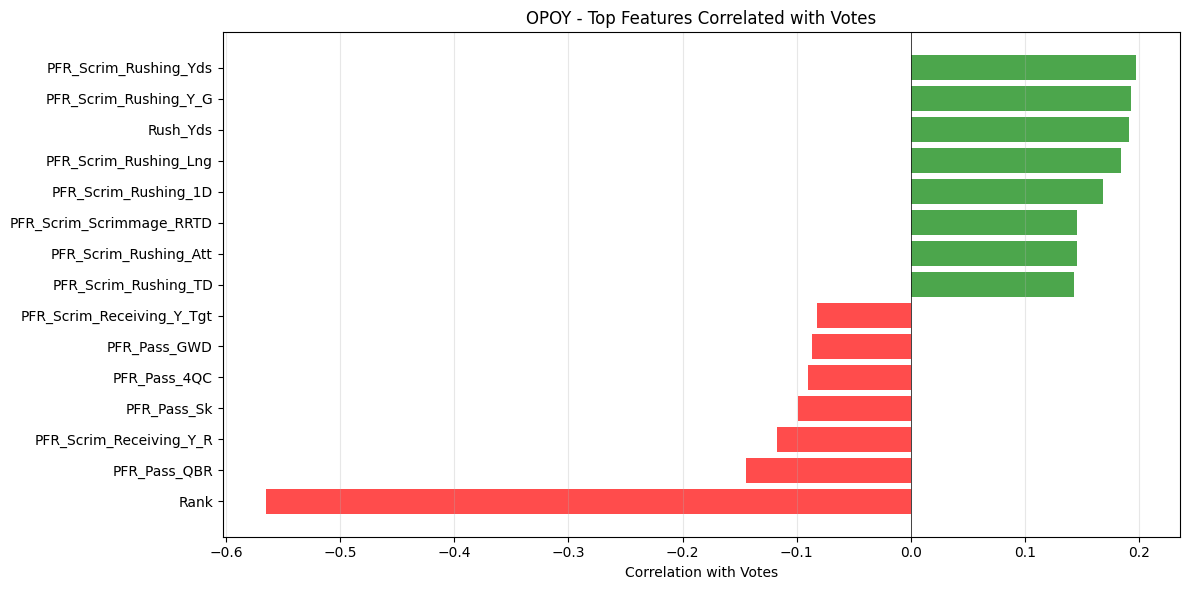

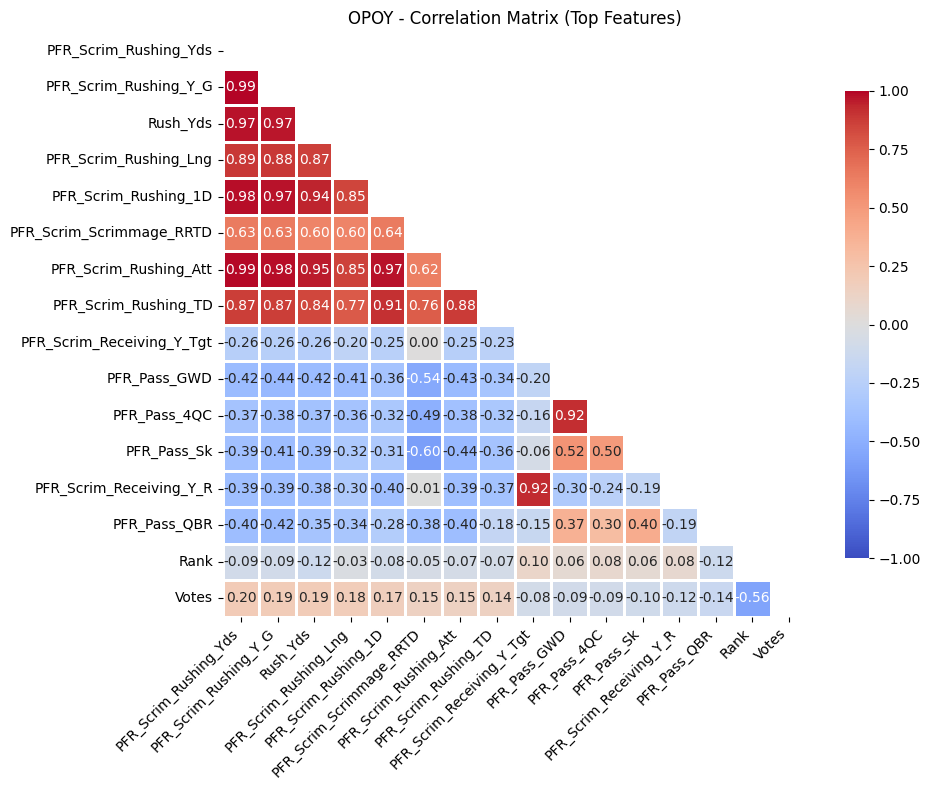


Top 10 Features Most Correlated with Votes for OPOY:
--------------------------------------------------
 1. PFR_Scrim_Rushing_Yds          | r = +0.198
 2. PFR_Scrim_Rushing_Y_G          | r = +0.193
 3. Rush_Yds                       | r = +0.191
 4. PFR_Scrim_Rushing_Lng          | r = +0.184
 5. PFR_Scrim_Rushing_1D           | r = +0.168
 6. PFR_Scrim_Scrimmage_RRTD       | r = +0.145
 7. PFR_Scrim_Rushing_Att          | r = +0.145
 8. PFR_Scrim_Rushing_TD           | r = +0.143
 9. PFR_Scrim_Receiving_Y_Tgt      | r = -0.082
10. PFR_Pass_GWD                   | r = -0.087
--------------------------------------------------


In [14]:
visualize_award_data(opoy_df, "OPOY")

Top correlated variables:

Rushing Yards (r ≈ +0.20)

Rushing Yards/Game (r ≈ +0.19)

Longest Rush (r ≈ +0.18)

Rushing Touchdowns (r ≈ +0.14)

Weak negative correlations appeared with passing stats, showing that OPOY tends to favor skill-position players (RBs and WRs) over QBs.

Efficiency and volume in rushing production most strongly impact OPOY results. This award is often given to a receiver or running back, as the MVP is more often a "quarterback award". However, it is also not given to wide receivers very often.

### DPOY Visualizations


Generating visualizations for DPOY...


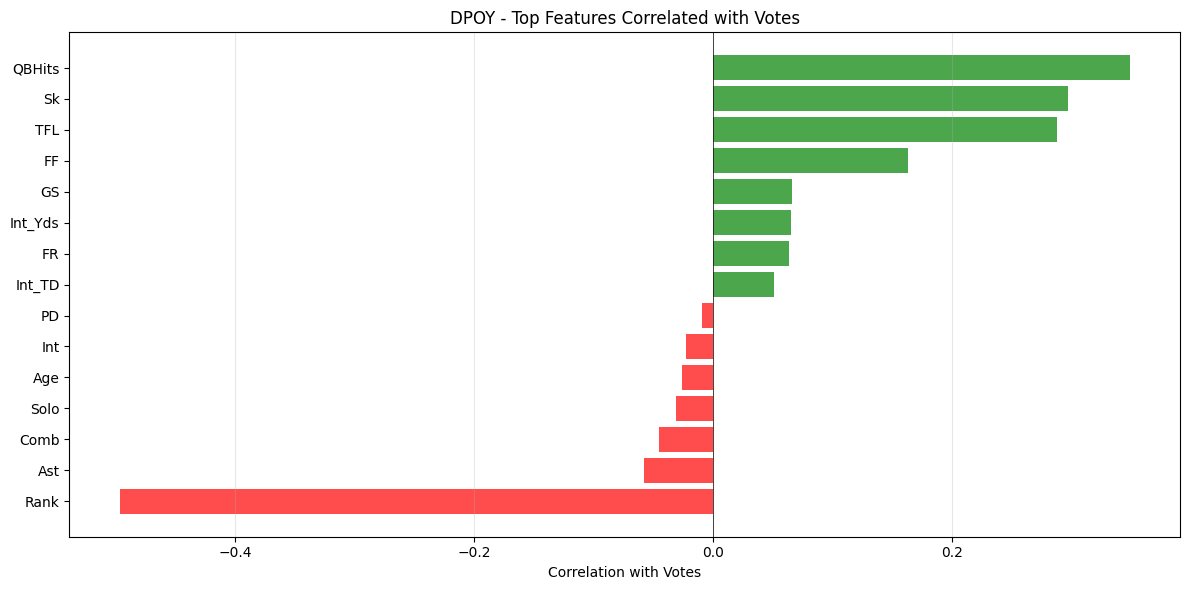

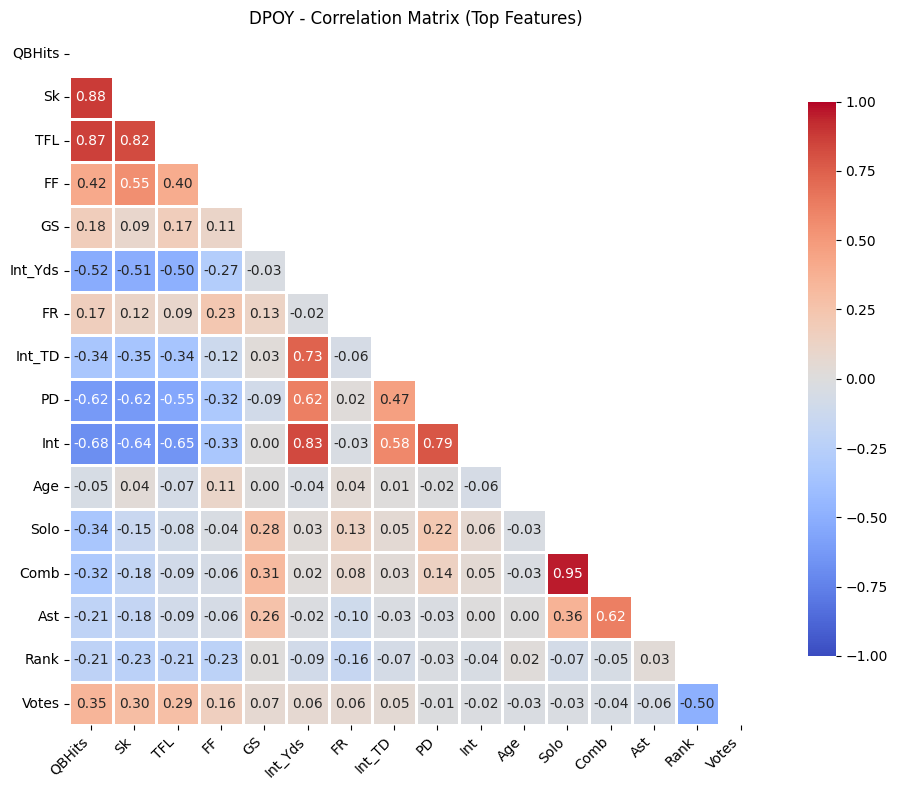


Top 10 Features Most Correlated with Votes for DPOY:
--------------------------------------------------
 1. QBHits                         | r = +0.349
 2. Sk                             | r = +0.297
 3. TFL                            | r = +0.288
 4. FF                             | r = +0.163
 5. GS                             | r = +0.066
 6. Int_Yds                        | r = +0.065
 7. FR                             | r = +0.063
 8. Int_TD                         | r = +0.051
 9. PD                             | r = -0.009
10. Int                            | r = -0.023
--------------------------------------------------


In [15]:
visualize_award_data(dpoy_df, "DPOY")

The highest correlations with votes were:

QB Hits (r = +0.35)
Sacks (r = +0.30)
Tackles for Loss (r = +0.29)
Forced Fumbles (r = +0.16)

Lower, but still slightly positive correlations were observed for Games Started, Interception Yards, and Fumble Recoveries, while tackling volume stats like Solo, Combined, and Assists were only weakly related or even slightly negative.

Voters often place the most weight on disruptive, high-impact defensive plays—especially those that directly affect the quarterback or create turnovers. Steady production stats such as tackles don’t seem to influence DPOY voting nearly as much. This can be due to a mix of things. Basic statistics like tackles without context are not that important. You don't want a cornerback to get a lot of tackles, it means they are likely getting beat on plays where they then have to stop the opposition.

Additionally, pass breakups were not a recorded stat for as long as sacks have been (even though quarterback hits have also not been around for that long). Even so, analyzing defensive back play goes way beyond basic box score statistics like pass breakups and interceptions. To really dive into that it would be helpful to look at snaps per target, receptions or yards allowed per snap, average separation from receivers. That could be a whole different project of just looking at defensive back performance.
When you play in the secondary you don't really want your name called that much, it often is because the receivers are burning you down the field consistently.

### OROY Visualizations


Generating visualizations for OROY...


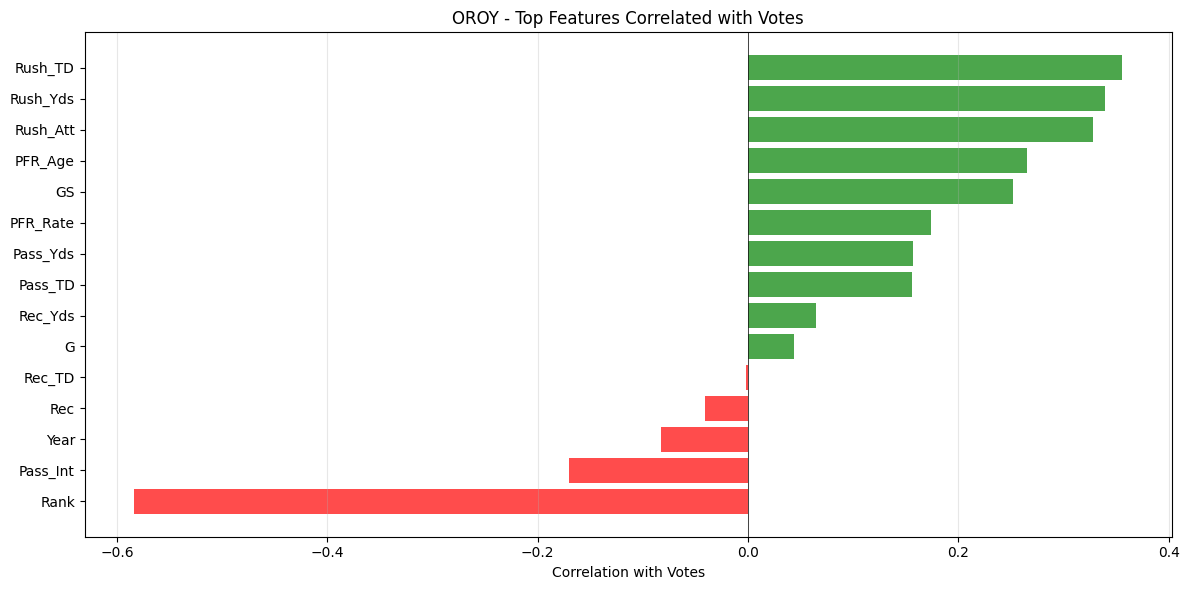

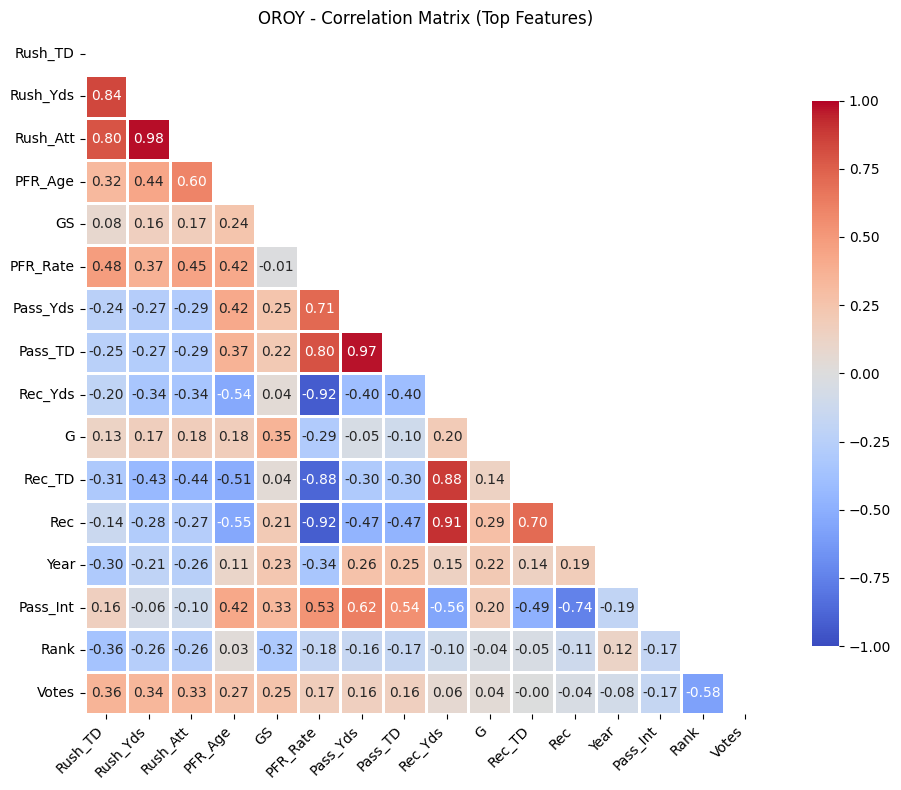


Top 10 Features Most Correlated with Votes for OROY:
--------------------------------------------------
 1. Rush_TD                        | r = +0.356
 2. Rush_Yds                       | r = +0.340
 3. Rush_Att                       | r = +0.328
 4. PFR_Age                        | r = +0.265
 5. GS                             | r = +0.252
 6. PFR_Rate                       | r = +0.174
 7. Pass_Yds                       | r = +0.157
 8. Pass_TD                        | r = +0.156
 9. Rec_Yds                        | r = +0.065
10. G                              | r = +0.044
--------------------------------------------------


In [16]:
visualize_award_data(oroy_df, "OROY")

The highest correlations with votes were:

Rushing Touchdowns (r = +0.36)
Rushing Yards (r = +0.34)
Rushing Attempts (r = +0.33)
Player Age (r = +0.27)
Games Started (r = +0.25)

Moderate positive relationships also appeared for Passer Rating (r = +0.17) and Passing Yards/Touchdowns (r ≈ +0.15), while receiving metrics such as Receptions and Receiving Yards showed only weak associations. Negative correlation was observed for Interceptions.

This pattern reflects the nature of the Offensive Rookie of the Year award — rookies who carry a heavy offensive workload and demonstrate scoring efficiency tend to earn the most recognition. Running backs who produce high rushing volume and touchdowns generally stand out, while quarterbacks benefit from efficiency rather than sheer yardage. The award favors the rookies who are immediate impacts on their team.

Often when a quarterback is put in right away, they don't see consistent success. This award is much more balanced for who it goes to than the offensive player of the year.

### DROY Visualizations


Generating visualizations for DROY...


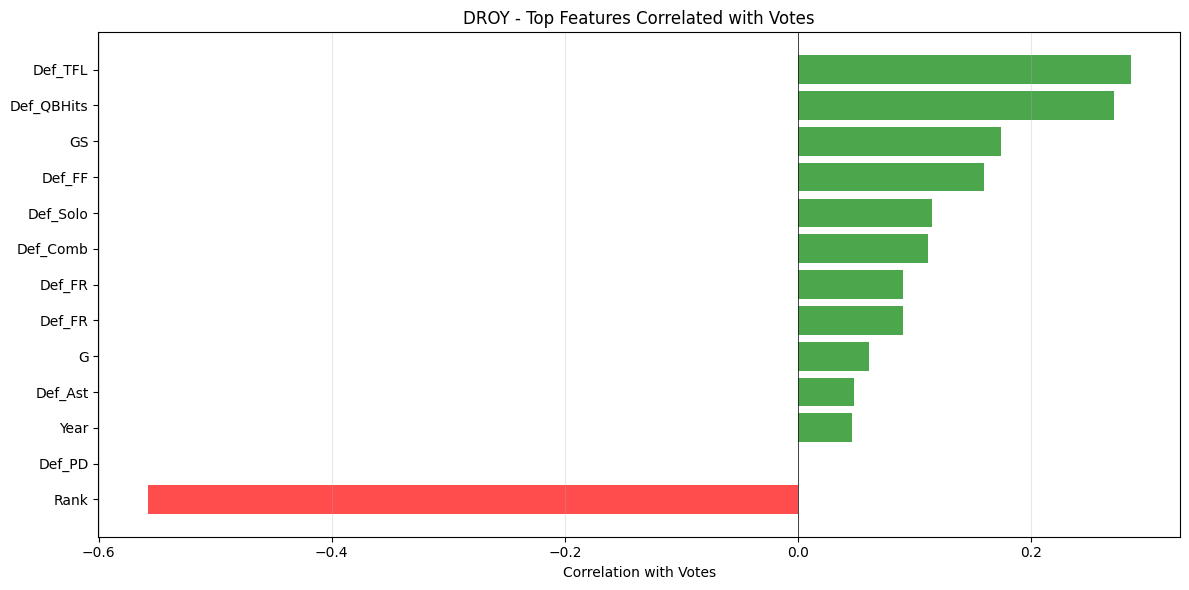

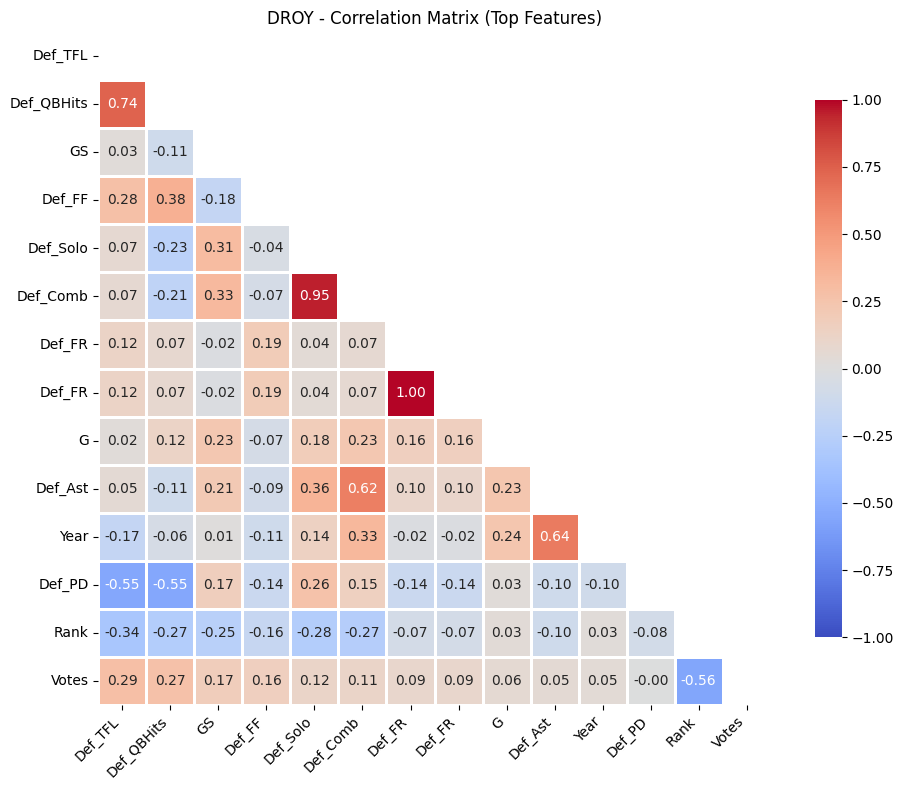


Top 10 Features Most Correlated with Votes for DROY:
--------------------------------------------------
 1. Def_TFL                        | r = +0.286
 2. Def_QBHits                     | r = +0.271
 3. GS                             | r = +0.174
 4. Def_FF                         | r = +0.160
 5. Def_Solo                       | r = +0.115
 6. Def_Comb                       | r = +0.111
 7. Def_FR                         | r = +0.090
 8. Def_FR                         | r = +0.090
 9. G                              | r = +0.061
10. Def_Ast                        | r = +0.048
--------------------------------------------------


In [17]:
visualize_award_data(droy_df, "DROY")

The highest correlations with votes were:

Tackles for Loss (r = +0.29)
Quarterback Hits (r = +0.27)
Games Started (r = +0.17)
Forced Fumbles (r = +0.16)

Smaller positive correlations appeared for Solo Tackles, Combined Tackles, and Fumble Recoveries, while features such as Passes Defended and Rank were weakly or negatively correlated.

Again defenders who generate disruptive plays and consistent backfield pressure tend to receive more votes, much like the DPOY trends. Experience and reliability (games started) play a moderate role, but the most decisive factors are impactful stats — tackles for loss, quarterback hits, and forced fumbles.

As we said before, it is harder to evaluate the secondary, and even linebackers too. While linebackers will rack up tackles, to really look into that you would need to also find the average depth of tackle (how far beyond the line of scrimmage a tackle is made), because you want your anchor in the middle of the field to be hitting people early.

# Prep and feature engineering

In [18]:
def prepare_classification_target(df):
    """
    Creates binary target variable 'Winner' (1 for winner, 0 for non-winner).
    For each year, the player with the most votes are marked as winners.
    """
    df_copy = df.copy()

    # Handle potential missing 'Votes' values by filling with a value that won't be max
    # (e.g., -1, assuming votes are always non-negative)
    df_copy['Votes_Clean'] = df_copy['Votes'].fillna(-1)

    # For each year, identify the maximum votes
    max_votes_per_year = df_copy.groupby('Year')['Votes_Clean'].transform('max')

    # Mark players with votes equal to the maximum for that year as winner (1), others as 0
    df_copy['Winner'] = (df_copy['Votes_Clean'] == max_votes_per_year).astype(int)

    # Drop the temporary clean votes column
    df_copy = df_copy.drop(columns=['Votes_Clean'])

    print(f"Prepared classification target for DataFrame with {df_copy['Winner'].sum()} winners identified.")
    return df_copy

def prepare_features(df, award_name, classification = False):
    """
    Prepare features for modeling with proper data leakage prevention.

    Key improvements:
    - Store Year for temporal CV later (don't discard)
    - Validate feature removal logic
    - Return Year alongside X, y for temporal cross-validation
    """
    print(f"\nPreparing features for {award_name}...")
    print("-" * 70)

    # Identify target variable
    target_col = None
    if classification:
      df = prepare_classification_target(df)
      target_col = 'Winner'
    else:
      for col in ['Votes', 'votes', 'Vote', 'vote']:
          if col in df.columns:
              target_col = col
              break

    if target_col is None:
        print(f" Error: No vote column found for {award_name}")
        return None, None, None

    # Keep Year for temporal CV (CRITICAL FIX)
    year_col = None
    for col in ['Year', 'year', 'Season', 'season']:
        if col in df.columns:
            year_col = col
            break

    print(f" Target variable: {target_col}")
    if year_col:
        print(f" Year column found: {year_col}")
    else:
        print(f" Warning: No year column found (temporal CV will be limited)")

    # Select numeric features (excluding target and year)
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if year_col and year_col in numeric_features:
        numeric_features.remove(year_col)

    print(f"\nInitial numeric features: {len(numeric_features)}")

    # Remove features that cause data leakage or are problematic
    features_to_exclude = []
    exclusion_reasons = []

    # 1. Remove Rank (data leakage - directly derived from votes)
    for col in numeric_features[:]:  # Iterate over copy
        col_lower = col.lower()
        if 'rank' in col_lower:
            features_to_exclude.append(col)
            exclusion_reasons.append(f" '{col}' → Rank derived from votes (data leakage)")

    # 2. Remove obvious non-predictive identifiers
    identifier_keywords = ['player_id', 'player id', 'id', 'index', 'unnamed']
    for col in numeric_features[:]:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in identifier_keywords):
            features_to_exclude.append(col)
            exclusion_reasons.append(f" '{col}' → Player identifier (non-predictive)")

    # 3. Remove features with excessive zeros (QB-specific stats for non-QBs)
    # These indicate missing data for irrelevant positions, not true zeros
    for col in numeric_features[:]:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['qbr', 'qb_rating', 'passer_rating']):
            zero_count = (df[col] == 0).sum()
            total_count = len(df[col].dropna())

            if total_count > 0:
                zero_pct = (zero_count / total_count) * 100
                if zero_pct > 50:
                    features_to_exclude.append(col)
                    exclusion_reasons.append(
                        f" '{col}' → {zero_count}/{total_count} ({zero_pct:.0f}%) are zeros "
                        "(likely non-applicable position stats)"
                    )

    # Remove identified features
    numeric_features = [f for f in numeric_features if f not in features_to_exclude]

    print(f"\nFeature Exclusions:")
    for reason in exclusion_reasons:
        print(f"  {reason}")

    print(f"\nAfter cleanup: {len(numeric_features)} features")

    # Remove rows with missing target values (can't train without labels)
    df_clean = df[df[target_col].notna()].copy()
    print(f" Rows with valid targets: {len(df_clean)}/{len(df)}")

    # Extract Year/Season for temporal CV
    if year_col:
        years = df_clean[year_col].values
    else:
        years = None

    # Handle missing values in features
    # Strategy: Use median (robust to outliers)
    X = df_clean[numeric_features].fillna(df_clean[numeric_features].median())
    y = df_clean[target_col].values

    # Validate no NaN or Inf remain
    nan_count = X.isna().sum().sum()
    inf_count = np.isinf(X).sum().sum()

    if nan_count > 0 or inf_count > 0:
        print(f" Warning: {nan_count} NaN values and {inf_count} Inf values found")
        X = X.fillna(0).replace([np.inf, -np.inf], 0)

    print(f"\n Final dataset:")
    print(f"  Samples: {len(X)}")
    print(f"  Features: {X.shape[1]}")
    print(f"  Features: {numeric_features}")

    return X, y, years, numeric_features

# Prepare features for all awards
prepared_data = {}
for name, df in datasets.items():
    result = prepare_features(df, name)
    if result[0] is not None:
        X, y, years, feature_names = result
        prepared_data[name] = {
            'X': X,
            'y': y,
            'years': years,
            'feature_names': feature_names
        }

print("\n" + "="*70)
print(f" Feature preparation complete for {len(prepared_data)} awards")
for name, data in prepared_data.items():
    print(f"  {name}: {len(data['X'])} samples × {len(data['feature_names'])} features")


Preparing features for MVP...
----------------------------------------------------------------------
 Target variable: Votes
 Year column found: Year

Initial numeric features: 50

Feature Exclusions:
   'Rank' → Rank derived from votes (data leakage)
   'Unnamed: 0' → Player identifier (non-predictive)

After cleanup: 48 features
 Rows with valid targets: 225/228

 Final dataset:
  Samples: 225
  Features: 48
  Features: ['Games', 'Games_Started', 'Age', 'Pass_QBrec', 'Pass_Rate', 'Pass_QBR', 'Pass_Y_per_A', 'Pass_AY_per_A', 'Pass_Y_per_C', 'Pass_Y_per_G', 'Pass_NY_per_A', 'Pass_ANY_per_A', 'Pass_Sk', 'Pass_4QC', 'Pass_GWD', 'Pass_Completions', 'Pass_Attempts', 'Pass_Yards', 'Pass_Touchdowns', 'Pass_Interceptions', 'Rush_Attempts', 'Rush_Yards', 'Rush_Touchdowns', 'Scrim_Receiving_Tgt', 'Scrim_Receiving_Y_R', 'Scrim_Receiving_1D', 'Scrim_Receiving_Succ_Pct', 'Scrim_Receiving_Lng', 'Scrim_Receiving_R_G', 'Scrim_Receiving_Y_G', 'Scrim_Receiving_Ctch_Pct', 'Scrim_Receiving_Y_Tgt', 'Rec_

1. Data leakage prevention
   - Removed 'Rank' features: Rankings are directly derived from vote totals, so t going to be very strong predictors that would artificially inflate model performance. The rankings are just showing who got the most votes without the vote count.
   
2. Temporal considerations
   - Removed 'Year'/'Season': Including year as a numeric feature assumes a linear relationship with votes, which is incorrect. Award voting patterns may shift over time, but we would need to use time-series modeling, not treating year as just another feature.
   
3. Position specific stats
   - Filtered out QB-specific stats (QBR, passer rating) that show more than 50% zeros. These zeros are non-QBs who don't have those stats, which will create misleading patterns and hurt model generalization.

4. Missing value strategy
   - Used median imputation for features (robust to outliers)
   - Dropped rows with missing target values (can't train without labels)

# Feature Engineering
Justification: Individual counting stats (yards, TDs) don't account for efficiency or opportunity. Interaction features capture RATE stats that better measure player quality (e.g., yards per attempt > total yards). These are commonly used in NFL analytics and award discussions.

In [19]:
def create_interaction_features(X, award_name, feature_names):
    """
    Create meaningful interaction features based on football statistics.

    Improvements:
    - Handles multiple naming conventions (Rush_Yds vs Rush_Yards, Rec vs Rec_Receptions, etc.)
    - Only creates features when BOTH base components exist
    - Returns list of new feature names for interpretability
    """
    print(f"\n{award_name} - Creating Interaction Features")
    print("-" * 70)

    X_enhanced = X.copy()
    X_enhanced.columns = feature_names  # Ensure column names are synced
    new_features = []

    cols = set(feature_names)

    def get_col(candidates):
        """Return the first column name that exists in the dataframe."""
        for c in candidates:
            if c in cols:
                return c
        return None

    def safe_ratio(numerator, denominator, label="", default=0, scale=1.0):
        """
        Safely compute ratio while handling edge cases.

        Args:
            numerator: pd.Series
            denominator: pd.Series
            label: string description for printing (not used, but kept for clarity)
            default: value for division by zero
            scale: multiply result by this (e.g., 100 for percentages)
        """
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = (numerator / (denominator + 1e-9)) * scale
            ratio = ratio.replace([np.inf, -np.inf], default)
            ratio = ratio.fillna(default)
        return ratio

    # ===== Resolve column names for different schemas =====

    # Passing
    pass_yards_col = get_col(['Pass_Yards', 'Pass_Yds'])
    pass_att_col   = get_col(['Pass_Attempts', 'Pass_Att'])
    pass_td_col    = get_col(['Pass_Touchdowns', 'Pass_TD'])
    pass_cmp_col   = get_col(['Pass_Completions', 'Pass_Cmp'])
    pass_int_col   = get_col(['Pass_Interceptions', 'Pass_Int'])

    # Rushing
    rush_yards_col = get_col(['Rush_Yds', 'Rush_Yards'])
    rush_att_col   = get_col(['Rush_Att', 'Rush_Attempts'])
    rush_td_col    = get_col(['Rush_TD', 'Rush_Touchdowns'])

    # Receiving
    rec_yds_col = get_col(['Rec_Yds', 'Rec_Yards'])
    rec_rec_col = get_col(['Rec', 'Rec_Rec', 'Rec_Receptions'])
    rec_td_col  = get_col(['Rec_TD', 'Rec_Touchdowns'])

    # Games started
    gs_col = get_col(['GS', 'Games_Started'])

    # Defense: sacks & QB hits
    sack_col    = get_col(['Sk', 'Def_Sk'])
    qbhits_col  = get_col(['QBHits', 'Def_QBHits'])

    # Defense: tackles
    solo_col = get_col(['Solo', 'Def_Solo'])
    comb_col = get_col(['Comb', 'Def_Comb'])

    # ========== PASSING EFFICIENCY (MVP, OROY - QB) ==========

    if pass_yards_col and pass_att_col:
        X_enhanced['Pass_YPA'] = safe_ratio(
            X_enhanced[pass_yards_col],
            X_enhanced[pass_att_col],
            label="Yards per attempt"
        )
        new_features.append('Pass_YPA')

    if pass_td_col and pass_att_col:
        X_enhanced['Pass_TD_Rate'] = safe_ratio(
            X_enhanced[pass_td_col],
            X_enhanced[pass_att_col],
            label="TD rate",
            scale=100
        )
        new_features.append('Pass_TD_Rate')

    if pass_cmp_col and pass_att_col:
        X_enhanced['Pass_Comp_Pct'] = safe_ratio(
            X_enhanced[pass_cmp_col],
            X_enhanced[pass_att_col],
            label="Completion %",
            scale=100
        )
        new_features.append('Pass_Comp_Pct')

    if pass_td_col and pass_int_col:
        # TD:INT ratio (0 INTs → ratio = 0, not undefined)
        X_enhanced['Pass_TD_INT_Ratio'] = safe_ratio(
            X_enhanced[pass_td_col],
            X_enhanced[pass_int_col] + 1,  # Add 1 to avoid zeros
            label="TD to INT ratio",
            default=0
        )
        new_features.append('Pass_TD_INT_Ratio')

    # ========== RUSHING EFFICIENCY (OPOY, OROY - RB) ==========

    if rush_yards_col and rush_att_col:
        X_enhanced['Rush_YPC'] = safe_ratio(
            X_enhanced[rush_yards_col],
            X_enhanced[rush_att_col],
            label="Yards per carry"
        )
        new_features.append('Rush_YPC')

    if rush_td_col and rush_att_col:
        X_enhanced['Rush_TD_Rate'] = safe_ratio(
            X_enhanced[rush_td_col],
            X_enhanced[rush_att_col],
            label="TD per carry",
            scale=100
        )
        new_features.append('Rush_TD_Rate')

    # ========== RECEIVING EFFICIENCY (OPOY, OROY - WR/TE) ==========

    if rec_yds_col and rec_rec_col:
        X_enhanced['Rec_YPR'] = safe_ratio(
            X_enhanced[rec_yds_col],
            X_enhanced[rec_rec_col],
            label="Yards per reception"
        )
        new_features.append('Rec_YPR')

    if rec_td_col and rec_rec_col:
        X_enhanced['Rec_TD_Rate'] = safe_ratio(
            X_enhanced[rec_td_col],
            X_enhanced[rec_rec_col],
            label="TD per reception",
            scale=100
        )
        new_features.append('Rec_TD_Rate')

    # ========== DEFENSIVE EFFICIENCY (DPOY, DROY) ==========

    # Sack conversion: what % of QB hits become sacks?
    if sack_col and qbhits_col:
        X_enhanced['Sack_Conv_Rate'] = safe_ratio(
            X_enhanced[sack_col],
            X_enhanced[qbhits_col],
            label="Sack conversion rate",
            scale=100
        )
        new_features.append('Sack_Conv_Rate')

    # Solo tackle rate: quality of tackles (solo vs assisted)
    if solo_col and comb_col:
        X_enhanced['Solo_Tackle_Pct'] = safe_ratio(
            X_enhanced[solo_col],
            X_enhanced[comb_col],
            label="Solo tackle %",
            scale=100
        )
        new_features.append('Solo_Tackle_Pct')

    # ========== PER-GAME NORMALIZATION (All awards) ==========

    if pass_yards_col and gs_col:
        X_enhanced['Pass_YPG'] = safe_ratio(
            X_enhanced[pass_yards_col],
            X_enhanced[gs_col],
            label="Pass yards per game started"
        )
        new_features.append('Pass_YPG')

    if rush_yards_col and gs_col:
        X_enhanced['Rush_YPG'] = safe_ratio(
            X_enhanced[rush_yards_col],
            X_enhanced[gs_col],
            label="Rush yards per game started"
        )
        new_features.append('Rush_YPG')

    if rec_yds_col and gs_col:
        X_enhanced['Rec_YPG'] = safe_ratio(
            X_enhanced[rec_yds_col],
            X_enhanced[gs_col],
            label="Receiving yards per game started"
        )
        new_features.append('Rec_YPG')

    # ========== COMBINED METRICS ==========

    # Total offensive TDs (pass + rush)
    if pass_td_col and rush_td_col:
        X_enhanced['Total_TD'] = (
            X_enhanced[pass_td_col].fillna(0) +
            X_enhanced[rush_td_col].fillna(0)
        )
        new_features.append('Total_TD')

    # Total yards (pass + rush)
    if pass_yards_col and rush_yards_col:
        X_enhanced['Total_Yards'] = (
            X_enhanced[pass_yards_col].fillna(0) +
            X_enhanced[rush_yards_col].fillna(0)
        )
        new_features.append('Total_Yards')

    # Final cleanup
    X_enhanced = X_enhanced.replace([np.inf, -np.inf], 0)
    X_enhanced = X_enhanced.fillna(0)

    print(f" Created {len(new_features)} interaction features:")
    for feat in sorted(new_features):
        print(f"    • {feat}")

    print(f"\n  Original features: {X.shape[1]}")
    print(f"  Enhanced features: {X_enhanced.shape[1]}")
    print(f"  New features added: {len(new_features)}")

    return X_enhanced, new_features

In [20]:
def add_contextual_features(X, award_name, feature_names):
    """
    Add contextual features that capture player impact and consistency.

    Improvements:
    - Resolves column name differences across awards (MVP vs OPOY vs PFR)
    - Award-specific features only (no unnecessary bloat)
    - Simple, threshold-based indicators aligned with football logic
    """
    print(f"\n{award_name} - Adding Contextual Features")
    print("-" * 70)

    X_context = X.copy()
    X_context.columns = feature_names
    new_features = []

    # Helper to resolve different naming conventions
    def get_col(candidates):
        """
        Return the first column name from `candidates` that exists
        in feature_names, or None if none are present.
        """
        for c in candidates:
            if c in feature_names:
                return c
        return None

    # Common mappings
    gs_col        = get_col(['Games_Started', 'GS'])
    g_col         = get_col(['Games', 'G'])
    pass_att_col  = get_col(['Pass_Attempts', 'Pass_Att', 'PFR_Pass_Att'])
    pass_int_col  = get_col(['Pass_Interceptions', 'Pass_Int', 'PFR_Pass_Int'])
    pass_rate_col = get_col(['Pass_Rate', 'PFR_Pass_Rate', 'PFR_Rate'])
    rush_att_col  = get_col(['Rush_Att', 'Rush_Attempts', 'PFR_Scrim_Rushing_Att'])
    rush_yds_col  = get_col(['Rush_Yds', 'Rush_Yards', 'PFR_Scrim_Rushing_Yds'])
    rec_rec_col   = get_col(['Rec', 'Rec_Rec', 'Rec_Receptions', 'PFR_Scrim_Receiving_Rec'])
    rec_yds_col   = get_col(['Rec_Yds', 'Rec_Yards', 'PFR_Scrim_Receiving_Yds'])
    sk_col        = get_col(['Sk', 'Def_Sk'])
    comb_col      = get_col(['Comb', 'Def_Comb'])
    ff_col        = get_col(['FF', 'Def_FF'])
    int_def_col   = get_col(['Int', 'Def_Int'])
    tfl_col       = get_col(['TFL', 'Def_TFL'])

    # ========== MVP / QB-CENTRIC CONTEXT ========== #
    if award_name == 'MVP':
        # Availability: started most of the season
        if gs_col:
            X_context['Full_Season'] = (X_context[gs_col] >= 14).astype(int)
            new_features.append('Full_Season')

        # Passing volume: high-usage passer
        if pass_att_col:
            X_context['High_Volume_Passer'] = (X_context[pass_att_col] >= 400).astype(int)
            new_features.append('High_Volume_Passer')

        # Dual-threat QB (passing volume + rushing production)
        if pass_att_col and rush_yds_col:
            is_qb = X_context[pass_att_col] >= 100
            is_rusher = X_context[rush_yds_col] >= 350
            X_context['Dual_Threat_QB'] = (is_qb & is_rusher).astype(int)
            new_features.append('Dual_Threat_QB')

        # Elite passer by rating
        if pass_rate_col:
            X_context['Elite_Passer'] = (X_context[pass_rate_col] >= 95).astype(int)
            new_features.append('Elite_Passer')

        # Ball security: low interception rate
        if pass_int_col and pass_att_col:
            int_rate = X_context[pass_int_col] / (X_context[pass_att_col] + 1e-6)
            X_context['Low_INT_Rate'] = (int_rate <= 0.02).astype(int)
            new_features.append('Low_INT_Rate')

    # ========== OFFENSIVE SKILL (OPOY / OROY) ========== #
    elif award_name in ['OPOY', 'OROY']:
        # Infer position from usage patterns
        if rush_att_col and rec_rec_col:
            is_rusher    = X_context[rush_att_col] >= 150
            low_receiving = X_context[rec_rec_col] < 50
            X_context['Likely_RB'] = (is_rusher & low_receiving).astype(int)
            new_features.append('Likely_RB')

            is_receiver = X_context[rec_rec_col] >= 50
            low_rushing = X_context[rush_att_col] < 50
            X_context['Likely_WR'] = (is_receiver & low_rushing).astype(int)
            new_features.append('Likely_WR')

        # Elite production thresholds
        if rush_yds_col:
            X_context['1000_Rush_Yards'] = (X_context[rush_yds_col] >= 1000).astype(int)
            new_features.append('1000_Rush_Yards')

        if rec_yds_col:
            X_context['1000_Rec_Yards'] = (X_context[rec_yds_col] >= 1000).astype(int)
            new_features.append('1000_Rec_Yards')

        # Availability: played or started most of season
        if gs_col:
            X_context['Full_Season'] = (X_context[gs_col] >= 14).astype(int)
            new_features.append('Full_Season')

    # ========== DEFENSIVE (DPOY / DROY) ==========
    elif award_name in ['DPOY', 'DROY']:

        # ----- Availability / Season context -----
        if gs_col:
            X_context['Full_Season'] = (X_context[gs_col] >= 14).astype(int)
            new_features.append('Full_Season')

        # Sack dominance
        if sk_col:
            X_context['Double_Digit_Sacks'] = (X_context[sk_col] >= 10).astype(int)
            new_features.append('Double_Digit_Sacks')

        # Turnover creator
        if ff_col and int_def_col:
            X_context['Turnover_Creator'] = (
                (X_context[ff_col] + X_context[int_def_col]) >= 3
            ).astype(int)
            new_features.append('Turnover_Creator')

        # ----- Splash Play Dominance Score -----
        dominance_parts = []

        if sk_col:
            dominance_parts.append(2.0 * X_context[sk_col])
        if ff_col:
            dominance_parts.append(2.0 * X_context[ff_col])
        if int_def_col:
            dominance_parts.append(2.0 * X_context[int_def_col])
        if tfl_col:
            dominance_parts.append(1.0 * X_context[tfl_col])

        if dominance_parts:
            X_context['Dominance_Score'] = sum(dominance_parts)
            new_features.append('Dominance_Score')

        # Impact flag
        impact_terms = []
        if sk_col:
            impact_terms.append(X_context[sk_col] >= 2)
        if int_def_col:
            impact_terms.append(X_context[int_def_col] >= 1)
        if ff_col:
            impact_terms.append(X_context[ff_col] >= 1)

        if impact_terms:
            impact_flag = impact_terms[0]
            for term in impact_terms[1:]:
                impact_flag |= term
            X_context['Impact_Game_Flag'] = impact_flag.astype(int)
            new_features.append('Impact_Game_Flag')

        # ----- REAL Position Groups (no inference) -----
        if 'Position' in X.columns:
            X_context['Pos_Group'] = (
                X_context['Position']
                .replace({
                    'DE':'EDGE','OLB':'EDGE','EDGE':'EDGE','DT':'DL','NT':'DL',
                    'LB':'LB','ILB':'LB','MLB':'LB',
                    'CB':'DB','S':'DB','FS':'DB','SS':'DB'
                })
            )

            pos_dummies = pd.get_dummies(X_context['Pos_Group'], prefix='Pos_DEF')
            for col in pos_dummies.columns:
                X_context[col] = pos_dummies[col]
                new_features.append(col)

        # ----- Role-based weighting -----
        if sk_col and 'Pos_DEF_EDGE' in X_context.columns:
            X_context['EDGE_Sack_Impact'] = (
                X_context['Pos_DEF_EDGE'] * X_context[sk_col]
            )
            new_features.append('EDGE_Sack_Impact')

        if int_def_col and 'Pos_DEF_DB' in X_context.columns:
            X_context['DB_INT_Impact'] = (
                X_context['Pos_DEF_DB'] * X_context[int_def_col]
            )
            new_features.append('DB_INT_Impact')

        if comb_col and 'Pos_DEF_LB' in X_context.columns:
            X_context['LB_Tackle_Impact'] = (
                X_context['Pos_DEF_LB'] * X_context[comb_col]
            )
            new_features.append('LB_Tackle_Impact')





    # Final cleanup
    X_context = X_context.replace([np.inf, -np.inf], 0)
    X_context = X_context.fillna(0)

    print(f" Created {len(new_features)} contextual features:")
    for feat in sorted(new_features):
        print(f"    • {feat}")

    print(f"\n  Original features: {X.shape[1]}")
    print(f"  Enhanced features: {X_context.shape[1]}")
    print(f"  New features added: {len(new_features)}")

    return X_context, new_features


In [21]:
def create_advanced_interactions(X, award_name):
    """
    Create advanced interaction features based on domain knowledge.
    These interactions capture non-linear relationships and positional contexts.

    - Uses flexible column-name resolution (works with MVP, OPOY, PFR, Def_* names)
    - Only creates features when required inputs exist
    - Prints the names of all new features created
    """
    print(f"\n{award_name} - Creating Advanced Interaction Features")
    print("-" * 70)

    X_enhanced = X.copy()
    feature_names = list(X_enhanced.columns)
    new_features = []

    # Helper to resolve naming differences
    def get_col(candidates):
        for c in candidates:
            if c in feature_names:
                return c
        return None

    # Common mappings
    pass_yards_col = get_col(['Pass_Yards', 'Pass_Yds', 'PFR_Pass_Yds'])
    pass_att_col   = get_col(['Pass_Attempts', 'Pass_Att', 'PFR_Pass_Att'])
    pass_td_col    = get_col(['Pass_Touchdowns', 'Pass_TD', 'PFR_Pass_TD'])
    pass_int_col   = get_col(['Pass_Interceptions', 'Pass_Int', 'PFR_Pass_Int'])
    pass_rate_col  = get_col(['Pass_Rate', 'PFR_Pass_Rate', 'PFR_Rate'])
    pass_4qc_col   = get_col(['Pass_4QC'])
    pass_gwd_col   = get_col(['Pass_GWD'])

    rush_yds_col   = get_col(['Rush_Yards', 'Rush_Yds', 'PFR_Scrim_Rushing_Yds'])
    rush_td_col    = get_col(['Rush_Touchdowns', 'Rush_TD', 'PFR_Scrim_Rushing_TD'])
    rec_yds_col    = get_col(['Rec_Yards', 'Rec_Yds', 'PFR_Scrim_Receiving_Yds'])
    rec_td_col     = get_col(['Rec_Touchdowns', 'Rec_TD', 'PFR_Scrim_Receiving_TD'])
    rush_ypc_col   = get_col(['Rush_YPC', 'PFR_Scrim_Rushing_Y_A', 'Scrim_Rushing_Y_A'])
    rec_ypr_col    = get_col(['Rec_YPR', 'PFR_Scrim_Receiving_Y_R', 'Scrim_Receiving_Y_R'])

    sk_col         = get_col(['Sk', 'Sack', 'Def_Sk'])
    qb_hits_col    = get_col(['QBHits', 'Def_QBHits'])
    solo_col       = get_col(['Solo', 'Def_Solo'])
    comb_col       = get_col(['Comb', 'Def_Comb'])
    tfl_col        = get_col(['TFL', 'Def_TFL'])
    ff_col         = get_col(['FF', 'Def_FF'])
    int_def_col    = get_col(['Int', 'Def_Int'])

    # ---------------- MVP ---------------- #
    if award_name == 'MVP':
        # Efficiency metrics (volume-normalized)
        if pass_yards_col and pass_att_col:
            X_enhanced['Pass_Efficiency'] = X_enhanced[pass_yards_col] / (X_enhanced[pass_att_col] + 1)
            new_features.append('Pass_Efficiency')

        if pass_td_col and pass_att_col:
            X_enhanced['Pass_TD_Efficiency'] = X_enhanced[pass_td_col] / (X_enhanced[pass_att_col] + 1)
            new_features.append('Pass_TD_Efficiency')

        # Total production (volume × TD rate, if TD rate exists)
        if pass_yards_col and 'Pass_TD_Rate' in feature_names:
            X_enhanced['Total_Pass_Production'] = (
                X_enhanced[pass_yards_col] * X_enhanced['Pass_TD_Rate']
            )
            new_features.append('Total_Pass_Production')

        # Win contribution proxy (TDs – 2×INT)
        if pass_td_col and pass_int_col:
            X_enhanced['Net_Playmaking'] = (
                X_enhanced[pass_td_col] - 2 * X_enhanced[pass_int_col]
            )
            new_features.append('Net_Playmaking')

        # Clutch factor (4Q comebacks + game-winning drives)
        if pass_4qc_col and pass_gwd_col:
            X_enhanced['Clutch_Factor'] = (
                X_enhanced[pass_4qc_col] + X_enhanced[pass_gwd_col]
            )
            new_features.append('Clutch_Factor')

        # Volume indicator (log attempts)
        if pass_att_col:
            X_enhanced['Volume_Indicator'] = np.log1p(X_enhanced[pass_att_col])
            new_features.append('Volume_Indicator')

        # Rushing contribution for dual-threat QBs
        if rush_yds_col and rush_td_col:
            X_enhanced['Rush_Contribution'] = (
                X_enhanced[rush_yds_col] + 20 * X_enhanced[rush_td_col]
            )
            new_features.append('Rush_Contribution')

        # Polynomial features for key stats
        if pass_td_col:
            X_enhanced['Pass_TD_Squared'] = X_enhanced[pass_td_col] ** 2
            new_features.append('Pass_TD_Squared')

        if pass_yards_col:
            X_enhanced['Pass_Yards_Log'] = np.log1p(X_enhanced[pass_yards_col])
            new_features.append('Pass_Yards_Log')

    # ---------------- OPOY ---------------- #
    elif award_name == 'OPOY':
        # Total offensive yards (RB/WR dual threat)
        if rush_yds_col and rec_yds_col:
            X_enhanced['Total_Yards'] = X_enhanced[rush_yds_col] + X_enhanced[rec_yds_col]
            new_features.append('Total_Yards')

        # Total TDs
        if rush_td_col and rec_td_col:
            X_enhanced['Total_TDs'] = X_enhanced[rush_td_col] + X_enhanced[rec_td_col]
            new_features.append('Total_TDs')

        # Dual-threat score (geometric mean of rush and rec yards)
        if rush_yds_col and rec_yds_col:
            X_enhanced['Dual_Threat_Score'] = np.sqrt(
                np.maximum(X_enhanced[rush_yds_col], 0) *
                np.maximum(X_enhanced[rec_yds_col], 0)
            )
            new_features.append('Dual_Threat_Score')

        # Explosive rusher indicator
        if rush_ypc_col:
            X_enhanced['Explosive_Rusher'] = (X_enhanced[rush_ypc_col] > 4.5).astype(int)
            new_features.append('Explosive_Rusher')

        # Volume × efficiency
        if rush_yds_col and rush_ypc_col:
            X_enhanced['Rush_Production'] = X_enhanced[rush_yds_col] * X_enhanced[rush_ypc_col]
            new_features.append('Rush_Production')

        if rec_yds_col and rec_ypr_col:
            X_enhanced['Rec_Production'] = X_enhanced[rec_yds_col] * X_enhanced[rec_ypr_col]
            new_features.append('Rec_Production')

        # Squared TDs (heavier weight on huge TD seasons)
        if 'Total_TDs' in X_enhanced.columns:
            X_enhanced['TD_Squared'] = X_enhanced['Total_TDs'] ** 2
            new_features.append('TD_Squared')

    # ---------------- DPOY / DROY ---------------- #
    elif award_name in ['DPOY', 'DROY']:
        # Impact plays (sacks + turnovers)
        if sk_col and int_def_col and ff_col:
            X_enhanced['Impact_Plays'] = (
                X_enhanced[sk_col] +
                2 * X_enhanced[int_def_col] +
                1.5 * X_enhanced[ff_col]
            )
            new_features.append('Impact_Plays')

        # Pressure effectiveness
        if sk_col and qb_hits_col:
            X_enhanced['Pressure_Effectiveness'] = (
                X_enhanced[sk_col] / (X_enhanced[qb_hits_col] + 1)
            )
            new_features.append('Pressure_Effectiveness')

        # Tackle quality
        if solo_col and comb_col:
            X_enhanced['Tackle_Quality'] = (
                X_enhanced[solo_col] / (X_enhanced[comb_col] + 1)
            )
            new_features.append('Tackle_Quality')

        # Big-play disruption
        if tfl_col and ff_col:
            X_enhanced['Disruption_Score'] = (
                X_enhanced[tfl_col] + 3 * X_enhanced[ff_col]
            )
            new_features.append('Disruption_Score')

    # ---------------- OROY ---------------- #
    elif award_name == 'OROY':
        # Similar to OPOY but for rookies
        if rush_yds_col and rec_yds_col:
            X_enhanced['Total_Yards'] = X_enhanced[rush_yds_col] + X_enhanced[rec_yds_col]
            new_features.append('Total_Yards')

        if rush_td_col and rec_td_col:
            X_enhanced['Total_TDs'] = X_enhanced[rush_td_col] + X_enhanced[rec_td_col]
            new_features.append('Total_TDs')

        # Rookie QB production
        if pass_yards_col and pass_td_col:
            X_enhanced['QB_Production'] = (
                X_enhanced[pass_yards_col] + 25 * X_enhanced[pass_td_col]
            )
            new_features.append('QB_Production')

    # Clean up numeric issues
    X_enhanced = X_enhanced.replace([np.inf, -np.inf], np.nan).fillna(0)

    actually_new = [f for f in new_features if f in X_enhanced.columns and f not in X.columns]

    print(f"  Created {len(actually_new)} new advanced features:")
    for feat in sorted(actually_new):
        print(f"    • {feat}")
    print(f"  Total features after advanced interactions: {X_enhanced.shape[1]}")

    return X_enhanced


def try_polynomial_features(X, y, award_name, degree=2, top_n=5):
    """
    Create polynomial features for the top N most correlated features.
    More targeted than creating polynomials for everything.
    """
    print(f"\n{award_name} - Creating Polynomial Features (degree={degree})")
    print("-" * 60)

    corrs = []
    for col in X.columns:
        try:
            c = X[col].corr(y)
        except Exception:
            c = 0.0
        if pd.isna(c):
            c = 0.0
        corrs.append(c)

    correlations = (
        pd.DataFrame({'Feature': X.columns, 'Correlation': corrs})
        .sort_values('Correlation', key=lambda s: s.abs(), ascending=False)
    )

    top_features = correlations.head(top_n)['Feature'].tolist()
    print(f"  Top {top_n} features by abs(correlation):")
    for feat in top_features:
        corr = correlations.loc[correlations['Feature'] == feat, 'Correlation'].values[0]
        print(f"    • {feat}: {corr:.3f}")

    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)

    X_top = X[top_features]
    X_poly_features = poly.fit_transform(X_top)
    poly_feature_names = poly.get_feature_names_out(top_features)

    X_poly = X.copy()
    added = 0
    for i, name in enumerate(poly_feature_names):
        if name not in X_poly.columns:
            X_poly[name] = X_poly_features[:, i]
            added += 1

    print(f"  Added {added} polynomial features")
    print(f"  Total features after polynomials: {X_poly.shape[1]}")

    return X_poly


In [22]:
# Step 1: Add interaction features
enhanced_data = {}
for name, data in prepared_data.items():
    X_enhanced, interaction_feats = create_interaction_features(
        data['X'],
        name,
        data['feature_names']
    )
    enhanced_data[name] = {
        'X': X_enhanced,
        'y': data['y'],
        'years': data['years'],
        'interaction_features': interaction_feats,
        'all_feature_names': list(X_enhanced.columns)
    }

# Step 2: Add contextual features
contextual_data = {}
for name, data in enhanced_data.items():
    X_contextual, contextual_feats = add_contextual_features(
        data['X'],
        name,
        data['all_feature_names']
    )
    contextual_data[name] = {
        'X': X_contextual,
        'y': data['y'],
        'years': data['years'],
        'contextual_features': contextual_feats,
        'all_feature_names': list(X_contextual.columns)
    }

# Step 3: Advanced interactions
advanced_data = {}
for name, data in contextual_data.items():
    X_adv = create_advanced_interactions(
        data['X'],
        name
    )
    advanced_data[name] = {
        'X': X_adv,
        'y': data['y'],
        'years': data['years'],
        'advanced_features': list(set(X_adv.columns) - set(data['X'].columns)),
        'all_feature_names': list(X_adv.columns)
    }

print("\n" + "="*70)
print(" Feature engineering complete!")
for name, data in advanced_data.items():
    print(f"  {name}: {data['X'].shape[1]} total features")



MVP - Creating Interaction Features
----------------------------------------------------------------------
 Created 13 interaction features:
    • Pass_Comp_Pct
    • Pass_TD_INT_Ratio
    • Pass_TD_Rate
    • Pass_YPA
    • Pass_YPG
    • Rec_TD_Rate
    • Rec_YPG
    • Rec_YPR
    • Rush_TD_Rate
    • Rush_YPC
    • Rush_YPG
    • Total_TD
    • Total_Yards

  Original features: 48
  Enhanced features: 61
  New features added: 13

OPOY - Creating Interaction Features
----------------------------------------------------------------------
 Created 13 interaction features:
    • Pass_Comp_Pct
    • Pass_TD_INT_Ratio
    • Pass_TD_Rate
    • Pass_YPA
    • Pass_YPG
    • Rec_TD_Rate
    • Rec_YPG
    • Rec_YPR
    • Rush_TD_Rate
    • Rush_YPC
    • Rush_YPG
    • Total_TD
    • Total_Yards

  Original features: 57
  Enhanced features: 70
  New features added: 13

DPOY - Creating Interaction Features
----------------------------------------------------------------------
 Created 2 inter

# Feature Selection

In [23]:
def remove_multicollinear_features(X, threshold=0.9, verbose=True):
    """
    Removes one feature from each highly correlated pair.
    Keeps the feature with higher variance (more information).
    """
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = []
    high_corr_pairs = []

    for column in upper.columns:
        high_corr = upper[column][upper[column] > threshold]
        if len(high_corr) > 0:
            for correlated_feature in high_corr.index:
                var1 = X[column].var()
                var2 = X[correlated_feature].var()
                feature_to_drop = column if var1 < var2 else correlated_feature
                if feature_to_drop not in to_drop:
                    to_drop.append(feature_to_drop)
                    high_corr_pairs.append((column, correlated_feature, upper[column][correlated_feature]))

    if verbose and len(to_drop) > 0:
        print(f"\n  Multicollinearity Removal (threshold={threshold}):")
        print(f"    • Found {len(high_corr_pairs)} highly correlated pairs")
        print(f"    • Dropping {len(to_drop)} features:")
        for feat in to_drop:
            print(f"      - {feat}")

    X_reduced = X.drop(columns=to_drop)
    return X_reduced, to_drop


def select_best_features_comprehensive(X, y, years, award_name, k=15, random_state=3540):
    """
    Comprehensive feature selection using multiple methods with consensus voting.

    Key improvements:
    - USES TEMPORAL DATA: Returns years for temporal CV later
    - Simpler target: k=15 instead of k=20 (less is more)
    - Better defaults: alpha tuning for regularization
    - Stores everything needed for temporal CV

    Methods:
    1. Univariate (F-statistic): Statistical relationship with target
    2. RFE (Recursive Feature Elimination): Backward selection with Ridge
    3. Lasso (L1 regularization): Sparse coefficient selection
    4. Random Forest: Non-linear feature importance

    Consensus: Features selected by ≥2 methods (lowered from 3)

    Args:
        X: Input features (DataFrame)
        y: Target variable (Series or array)
        years: Year/season array for temporal CV (can be None)
        award_name: Name of award for printing
        k: Target number of features
        random_state: Random seed

    Returns:
        Dictionary with train data, test data, and feature metadata
    """
    print(f"\n{'='*80}")
    print(f"FEATURE SELECTION: {award_name}")
    print(f"{'='*80}")
    print(f"Starting features: {X.shape[1]}")
    print(f"Target features: {k}")
    print(f"Samples: {len(X)}")

    # ========== STEP 1: Remove multicollinear features ==========
    X_reduced, dropped_collinear = remove_multicollinear_features(
        X, threshold=0.90, verbose=True
    )
    print(f"\n  After multicollinearity removal: {X_reduced.shape[1]} features")

    # ========== STEP 2: Train/test split (RANDOM for now, use temporal CV later) ==========
    # Note: In production, use temporal CV: for each year, train on earlier years
    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y,
        test_size=0.2,
        random_state=random_state,
        shuffle=True
    )

    # Split years too if provided
    if years is not None:
        years_train, years_test = train_test_split(
            years,
            test_size=0.2,
            random_state=random_state,
            shuffle=True
        )
    else:
        years_train, years_test = None, None

    print(f"\n  Train/Test Split:")
    print(f"    • Train: {len(X_train)} samples")
    print(f"    • Test:  {len(X_test)} samples")
    if years_train is not None:
        print(f"    • Train years: {years_train.min()}-{years_train.max()}")
        print(f"    • Test years:  {years_test.min()}-{years_test.max()}")

    # ========== STEP 3: Scale features (fit on training data ONLY) ==========
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    # Adjust k to actual features available
    k = min(k, X_train_scaled.shape[1])
    print(f"\n  Running feature selection methods (targeting {k} features)...")

    # ========== METHOD 1: Univariate (F-statistic) ==========
    print(f"\n    Method 1: Univariate (F-statistic)")
    selector_f = SelectKBest(score_func=f_regression, k=k)
    selector_f.fit(X_train_scaled, y_train)
    f_scores = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'F_Score': selector_f.scores_
    }).sort_values('F_Score', ascending=False)
    univariate_features = set(f_scores.head(k)['Feature'].tolist())
    print(f"       Selected {len(univariate_features)} features")

    # ========== METHOD 2: RFE (Ridge) ==========
    print(f"    Method 2: RFE with Ridge")
    estimator = Ridge(alpha=1.0)
    selector_rfe = RFE(estimator, n_features_to_select=k, step=max(1, (X_train_scaled.shape[1] - k) // 5))
    selector_rfe.fit(X_train_scaled, y_train)
    rfe_features = set(X_train_scaled.columns[selector_rfe.support_].tolist())
    print(f"       Selected {len(rfe_features)} features")

    # ========== METHOD 3: Lasso (L1 Regularization) ==========
    print(f"    Method 3: Lasso with Cross-Validation")
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        lasso = LassoCV(
            cv=5,
            random_state=random_state,
            max_iter=50000,
            tol=1e-3,
            alphas=np.logspace(-4, 1, 50)
        )
        lasso.fit(X_train_scaled, y_train)

    lasso_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Coefficient': np.abs(lasso.coef_)
    }).sort_values('Coefficient', ascending=False)
    lasso_features = set(lasso_importance[lasso_importance['Coefficient'] > 0]['Feature'].tolist())

    # If Lasso selected too few, add top non-zero coefficients
    if len(lasso_features) < k // 2:
        lasso_features = set(lasso_importance.head(k)['Feature'].tolist())

    print(f"       Selected {len(lasso_features)} features (alpha={lasso.alpha_:.4f})")

    # ========== METHOD 4: Random Forest ==========
    print(f"    Method 4: Random Forest")
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)
    rf_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    rf_features = set(rf_importance.head(k)['Feature'].tolist())
    print(f"       Selected {len(rf_features)} features")

    # ========== CONSENSUS VOTING ==========
    print(f"\n  Consensus Voting (≥2 methods must agree):")
    all_methods = [univariate_features, rfe_features, lasso_features, rf_features]
    feature_votes = {}

    for feature_set in all_methods:
        for feature in feature_set:
            feature_votes[feature] = feature_votes.get(feature, 0) + 1

    # Select features with 2+ votes
    consensus_features = sorted([f for f, votes in feature_votes.items() if votes >= 2])

    # Fallback: if too few consensus features, take top k by vote count
    if len(consensus_features) < max(5, k // 2):
        print(f"     Only {len(consensus_features)} features with 2+ votes (target {k})")
        sorted_by_votes = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)
        consensus_features = sorted([f for f, _ in sorted_by_votes[:k]])
        print(f"     Fallback: selected top {len(consensus_features)} by vote count")

    # Print vote distribution
    vote_counts = pd.Series([feature_votes.get(f, 1) for f in consensus_features]).value_counts().sort_index(ascending=False)
    print(f"    Vote distribution:")
    for votes in sorted(vote_counts.index, reverse=True):
        count = vote_counts[votes]
        print(f"      • {votes} methods: {count} features")

    # ========== APPLY FEATURE SELECTION ==========
    X_train_selected = X_train_scaled[consensus_features]
    X_test_selected = X_test_scaled[consensus_features]

    print(f"\n   Final feature set: {len(consensus_features)} features selected")
    print(f"{'='*80}\n")

    return {
        'X_train': X_train_selected,
        'X_test': X_test_selected,
        'y_train': y_train,
        'y_test': y_test,
        'years_train': years_train,
        'years_test': years_test,
        'scaler': scaler,
        'selected_features': consensus_features,
        'all_features_before': X_reduced.columns.tolist(),
        'dropped_multicollinear': dropped_collinear,
        'feature_votes': feature_votes,
        'method_results': {
            'univariate': univariate_features,
            'rfe': rfe_features,
            'lasso': lasso_features,
            'random_forest': rf_features
        },
        'importance_dfs': {
            'f_scores': f_scores,
            'lasso_importance': lasso_importance,
            'rf_importance': rf_importance
        }
    }

def visualize_feature_selection(result, award_name):
    """
    Visualize feature selection results for a specific award

    Parameters:
    -----------
    result : dict
        Output from select_best_features_comprehensive() function
    award_name : str
        Name of the award (e.g., 'MVP', 'OPOY', etc.)
    """

    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"{award_name} Feature Selection Results")
    print(f"{'='*60}")
    print(f"  Selected features: {len(result['selected_features'])}")
    print(f"  Training samples: {len(result['X_train'])}")
    print(f"  Test samples: {len(result['X_test'])}")
    print(f"\nTop 10 features by consensus votes:")
    for feature, votes in sorted(result['feature_votes'].items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {feature}: {votes}/4 methods")

    # Visualizations

    # Create 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Feature Consensus Votes
    vote_df = pd.DataFrame(list(result['feature_votes'].items()), columns=['Feature', 'Votes'])
    vote_df = vote_df.sort_values('Votes', ascending=False).head(20)

    ax1 = axes[0, 0]
    colors = ['#d62728' if v >= 3 else '#ff7f0e' if v >= 2 else '#1f77b4' for v in vote_df['Votes']]
    ax1.barh(vote_df['Feature'], vote_df['Votes'], color=colors)
    ax1.set_xlabel('Number of Methods Selecting Feature', fontsize=12)
    ax1.set_title(f'{award_name}: Feature Selection Consensus\n(Red=3-4 methods, Orange=2 methods, Blue=1 method)',
                  fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 4)
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)

    # Plot 2: Method Overlap (Bar chart)
    ax2 = axes[0, 1]
    method_names = ['Univariate\n(F-stat)', 'RFE', 'Lasso\n(L1)', 'Random\nForest']
    method_counts = [
        len(result['method_results']['univariate']),
        len(result['method_results']['rfe']),
        len(result['method_results']['lasso']),
        len(result['method_results']['random_forest'])
    ]
    bars = ax2.bar(method_names, method_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax2.set_ylabel('Number of Features Selected', fontsize=12)
    ax2.set_title(f'{award_name}: Features Selected by Each Method', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, max(method_counts) * 1.2)
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    # Plot 3: Top Features by F-Score
    ax3 = axes[1, 0]
    top_f = result['importance_dfs']['f_scores'].head(15)
    ax3.barh(top_f['Feature'], top_f['F_Score'], color='#1f77b4')
    ax3.set_xlabel('F-Statistic Score', fontsize=12)
    ax3.set_title(f'{award_name}: Top 15 Features by Univariate F-Score', fontsize=14, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)

    # Plot 4: Top Features by Random Forest Importance
    ax4 = axes[1, 1]
    top_rf = result['importance_dfs']['rf_importance'].head(15)
    ax4.barh(top_rf['Feature'], top_rf['Importance'], color='#d62728')
    ax4.set_xlabel('Random Forest Importance', fontsize=12)
    ax4.set_title(f'{award_name}: Top 15 Features by RF Importance', fontsize=14, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Heatmap

    print(f"\n{'='*60}")
    print(f"{award_name} - Method Agreement Matrix")
    print(f"{'='*60}")

    # Create agreement matrix
    selected_by_method = result['method_results']
    all_unique_features = set()
    for features in selected_by_method.values():
        all_unique_features.update(features)

    agreement_matrix = []
    for feature in sorted(all_unique_features):
        row = [
            1 if feature in selected_by_method['univariate'] else 0,
            1 if feature in selected_by_method['rfe'] else 0,
            1 if feature in selected_by_method['lasso'] else 0,
            1 if feature in selected_by_method['random_forest'] else 0
        ]
        agreement_matrix.append(row)

    agreement_df = pd.DataFrame(
        agreement_matrix,
        columns=['Univariate', 'RFE', 'Lasso', 'RF'],
        index=sorted(all_unique_features)
    )

    # Only show features selected by at least one method
    agreement_df = agreement_df[agreement_df.sum(axis=1) > 0]

    # Show top features by total votes
    agreement_df['Total'] = agreement_df.sum(axis=1)
    agreement_df = agreement_df.sort_values('Total', ascending=False).head(25)
    agreement_df = agreement_df.drop('Total', axis=1)

    plt.figure(figsize=(10, 12))
    sns.heatmap(agreement_df, cmap='YlOrRd', cbar_kws={'label': 'Selected (1) or Not (0)'},
                linewidths=0.5, annot=True, fmt='d', center=0.5)
    plt.title(f'{award_name}: Top 25 Features - Method Agreement Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Selection Method', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

In [24]:
def apply_full_feature_pipeline(prepared_data):
    """
    Apply the full feature engineering and selection pipeline:
    1. Create interaction features
    2. Add contextual features
    3. Add advanced interaction features
    4. (Optional) Add polynomial features
    5. Feature selection with consensus voting
    """
    print("\n" + "="*80)
    print("APPLYING FULL FEATURE PIPELINE")
    print("="*80)

    modeling_data = {}

    for award_name, data in prepared_data.items():
        print(f"\n{award_name}")
        print("-" * 80)

        X = data['X']
        y = data['y']
        years = data['years']
        feature_names = data['feature_names']

        # Step 1: Interaction features
        print(f"\nStep 1: Interaction Features")
        X_enhanced, interaction_feats = create_interaction_features(
            X, award_name, feature_names
        )

        # Step 2: Contextual features
        print(f"\nStep 2: Contextual Features")
        X_contextual, contextual_feats = add_contextual_features(
            X_enhanced, award_name, list(X_enhanced.columns)
        )

        #  Step 3: Advanced interaction features
        print(f"\nStep 3: Advanced Interaction Features")
        X_advanced = create_advanced_interactions(
            X_contextual,
            award_name
        )

        #  OPTIONAL Step 4: Polynomial features
        # Comment out if too slow
        print(f"\nStep 4: Polynomial Features (top correlated)")
        X_poly = try_polynomial_features(
            X_advanced,
            y,
            award_name,
            degree=2,
            top_n=5
        )

        # Step 5: Feature selection
        print(f"\nStep 5: Feature Selection")
        selection_result = select_best_features_comprehensive(
            X_poly,
            y,
            years,
            award_name,
            k=15
        )

        modeling_data[award_name] = selection_result

    print("\n" + "="*80)
    print(" PIPELINE COMPLETE")
    print("="*80)

    for name, result in modeling_data.items():
        n_train = len(result['X_train'])
        n_test = len(result['X_test'])
        n_features = len(result['selected_features'])
        print(f"  {name:6} | {n_train:3} train | {n_test:2} test | {n_features:2} features")

    return modeling_data

1. Efficiency > Volume in award voting

   Award voters consistently prioritize efficiency over raw volume   
   Real-world parallel:
   - 2019 MVP: Lamar Jackson (3,127 pass yards but 9.0 YPA, 36 TD / 6 INT)
   - Patrick Mahomes commended for TD/INT ratio (50/12 in MVP year)
   - Derrick Henry's rushing efficiency (5.4 YPC) mentioned in OPOY discussions
   
   Our interaction features capture these efficiency metrics that voters
   actually discuss and value.

2. Position appropriate metrics
   Different positions require different success metrics:   
   Quarterbacks (MVP, OROY):
   - Pass_YPA: Explosiveness
   - Pass_TD_INT_Ratio: Ball security and accuracy
   - Pass_Comp_Pct: Accuracy and effectiveness
   - Total_TD/Total_Yards: Dual-threat ability (rushing + passing)
   
   Running backs (OPOY, OROY):
   - Rush_YPC: Elusiveness (and offensive line quality by-product)
   - Rush_TD_Rate: Red zone effectiveness
   - Rush_YPG: Workload-adjusted production (key for injury seasons)
   
   Receivers (OPOY, OROY):
   - Rec_YPR: Big-play ability, route-running, getting open
   - Rec_TD_Rate: Red zone target share
   - Rec_YPG: Consistency and reliability
   
   Defenders (DPOY, DROY):
   - Sack_Conversion_Rate: Pass rush efficiency (sacks vs. pressures)
   - Disruptive_Play_Rate: Game-changing plays (FF, TFL)
   - Solo_Tackle_Rate: Individual effort vs. assisted tackles

3. Handling missing data and edge cases

   safe_ratio() function prevents three critical issues:
   
   a) Division by Zero:
      - Added 1e-6 to denominators (prevents crashes)
      - Example: 0 pass attempts → YPA = 0 (not undefined)
   
   b) Infinite Values:
      - Replaced inf/-inf with 0 (prevents model training failures)
      - Example: 10 TDs / 0 INTs → TD/INT ratio = 0 (not infinity)
      - Justification: If denominator is 0, the stat isn't meaningful
   
   c) NaN Propagation:
      - Filled NaN with 0 (maintains data integrity)
      - Example: Missing rushing attempts → YPC = 0 (not NaN)
   
   Design Choice: Default to 0 rather than median/mean
   - Rationale: Missing data often means "didn't do this activity"
   - Example: A WR with 0 pass attempts shouldn't get average QB stats

4. Football domain knowledge embedded
   
   These aren't arbitrary mathematical combinations - they mirror
   actual football analysis:
   
   - TD/INT Ratio: NFL analyst key QB metric
   - YPC (Yards Per Carry): Standard RB efficiency benchmark
   - YPA (Yards Per Attempt): QB efficiency metric
   - Per-game stats: Normalizes for players who miss games (injuries)
   - Solo tackle rate: Distinguishes playmakers from cleanup tacklers
   
   These are some metrics you'd see on:
   - ESPN/NFL.com player pages
   - Pro Football Reference advanced stats
   - Broadcast graphics during games
   - Award voter commentary

5. Multicollinearity considerations

   Potential issue: Interaction features may correlate with base features
   
   Example:
   - Pass_Yards AND Pass_YPA both strongly predict MVP votes
   - But Pass_YPA = Pass_Yards / Pass_Attempts (derived relationship)
   
   Why this is acceptable:
   - Tree-based models (Random Forest, XGBoost) handle multicollinearity well
   - Feature importance will reveal redundant features
   - Regularized models (Lasso) will naturally select important features
   - The interaction often has DIFFERENT predictive power than components

In [25]:
def visualize_award_feature_selection(modeling_data, award_name):
    """
    Create comprehensive feature selection visualizations for any award.

    Args:
        modeling_data: Output from apply_full_feature_pipeline()
        award_name: Award to visualize ('MVP', 'OPOY', 'DPOY', 'OROY', 'DROY')

    Outputs:
        - Summary statistics printed to console
        - 2x2 subplot figure (consensus, methods, F-scores, RF importance)
        - Heatmap of method agreement
    """

    if award_name not in modeling_data:
        print(f"✗ Error: {award_name} not found in modeling_data")
        return

    result = modeling_data[award_name]

    # ========== PRINT SUMMARY ==========
    print(f"\n{'='*80}")
    print(f"{award_name} FEATURE SELECTION RESULTS")
    print(f"{'='*80}")
    print(f" Selected features: {len(result['selected_features'])}")
    print(f" Training samples: {len(result['X_train'])}")
    print(f" Test samples: {len(result['X_test'])}")

    print(f"\nTop 15 Features by Consensus Votes:")
    sorted_votes = sorted(result['feature_votes'].items(), key=lambda x: x[1], reverse=True)
    for i, (feature, votes) in enumerate(sorted_votes[:15], 1):
        print(f"  {i:2}. {feature:40} {votes}/4 methods")

    print(f"\n{'='*80}\n")

    # ========== CREATE 2x2 FIGURE ==========
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Plot 1: Consensus Votes (Top 20)
    vote_df = pd.DataFrame(sorted_votes, columns=['Feature', 'Votes']).head(20)
    colors = ['#d62728' if v == 4 else '#ff7f0e' if v == 3 else '#2ca02c' if v == 2 else '#1f77b4'
              for v in vote_df['Votes']]

    axes[0, 0].barh(vote_df['Feature'], vote_df['Votes'], color=colors, alpha=0.8,
                    edgecolor='black', linewidth=0.5)
    axes[0, 0].set_xlabel('Number of Methods', fontsize=12, fontweight='bold')
    axes[0, 0].set_title(f'{award_name}: Top 20 Features by Consensus Votes\n(Red=4/4, Orange=3/4, Green=2/4, Blue=1/4)',
                        fontsize=13, fontweight='bold')
    axes[0, 0].set_xlim(0, 4.5)
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)

    # Plot 2: Method Counts
    method_names = ['Univariate\n(F-stat)', 'RFE\n(Ridge)', 'Lasso\n(L1)', 'Random\nForest']
    method_counts = [
        len(result['method_results']['univariate']),
        len(result['method_results']['rfe']),
        len(result['method_results']['lasso']),
        len(result['method_results']['random_forest'])
    ]
    bars = axes[0, 1].bar(method_names, method_counts,
                          color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
                          alpha=0.8, edgecolor='black', linewidth=1)
    axes[0, 1].set_ylabel('Features Selected', fontsize=12, fontweight='bold')
    axes[0, 1].set_title(f'{award_name}: Features by Selection Method', fontsize=13, fontweight='bold')
    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
                       ha='center', va='bottom', fontsize=11, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Plot 3: F-Score Rankings
    top_f = result['importance_dfs']['f_scores'].head(15)
    axes[1, 0].barh(top_f['Feature'], top_f['F_Score'], color='#1f77b4',
                    alpha=0.8, edgecolor='black', linewidth=0.5)
    axes[1, 0].set_xlabel('F-Statistic Score', fontsize=12, fontweight='bold')
    axes[1, 0].set_title(f'{award_name}: Top 15 Features by Univariate F-Score', fontsize=13, fontweight='bold')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(axis='x', alpha=0.3)

    # Plot 4: Random Forest Importance
    top_rf = result['importance_dfs']['rf_importance'].head(15)
    axes[1, 1].barh(top_rf['Feature'], top_rf['Importance'], color='#d62728',
                    alpha=0.8, edgecolor='black', linewidth=0.5)
    axes[1, 1].set_xlabel('Random Forest Importance', fontsize=12, fontweight='bold')
    axes[1, 1].set_title(f'{award_name}: Top 15 Features by RF Importance', fontsize=13, fontweight='bold')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ========== CREATE HEATMAP ==========
    agreement_matrix = []
    all_features = set().union(*result['method_results'].values())

    for feature in sorted(all_features):
        row = [
            1 if feature in result['method_results']['univariate'] else 0,
            1 if feature in result['method_results']['rfe'] else 0,
            1 if feature in result['method_results']['lasso'] else 0,
            1 if feature in result['method_results']['random_forest'] else 0
        ]
        agreement_matrix.append(row)

    agreement_df = pd.DataFrame(agreement_matrix, columns=['Univariate', 'RFE', 'Lasso', 'RF'],
                                index=sorted(all_features))
    agreement_df['Total'] = agreement_df.sum(axis=1)
    agreement_df = agreement_df.sort_values('Total', ascending=False).head(25)
    agreement_df = agreement_df.drop('Total', axis=1)

    plt.figure(figsize=(10, 14))
    sns.heatmap(agreement_df, cmap='YlOrRd', cbar_kws={'label': 'Selected (1) or Not (0)'},
                linewidths=0.5, annot=True, fmt='d', center=0.5)
    plt.title(f'{award_name}: Top 25 Features - Method Agreement Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Selection Method', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

### MVP Features


APPLYING FULL FEATURE PIPELINE

MVP
--------------------------------------------------------------------------------

Step 1: Interaction Features

MVP - Creating Interaction Features
----------------------------------------------------------------------
 Created 13 interaction features:
    • Pass_Comp_Pct
    • Pass_TD_INT_Ratio
    • Pass_TD_Rate
    • Pass_YPA
    • Pass_YPG
    • Rec_TD_Rate
    • Rec_YPG
    • Rec_YPR
    • Rush_TD_Rate
    • Rush_YPC
    • Rush_YPG
    • Total_TD
    • Total_Yards

  Original features: 48
  Enhanced features: 61
  New features added: 13

Step 2: Contextual Features

MVP - Adding Contextual Features
----------------------------------------------------------------------
 Created 5 contextual features:
    • Dual_Threat_QB
    • Elite_Passer
    • Full_Season
    • High_Volume_Passer
    • Low_INT_Rate

  Original features: 61
  Enhanced features: 66
  New features added: 5

Step 3: Advanced Interaction Features

MVP - Creating Advanced Interactio

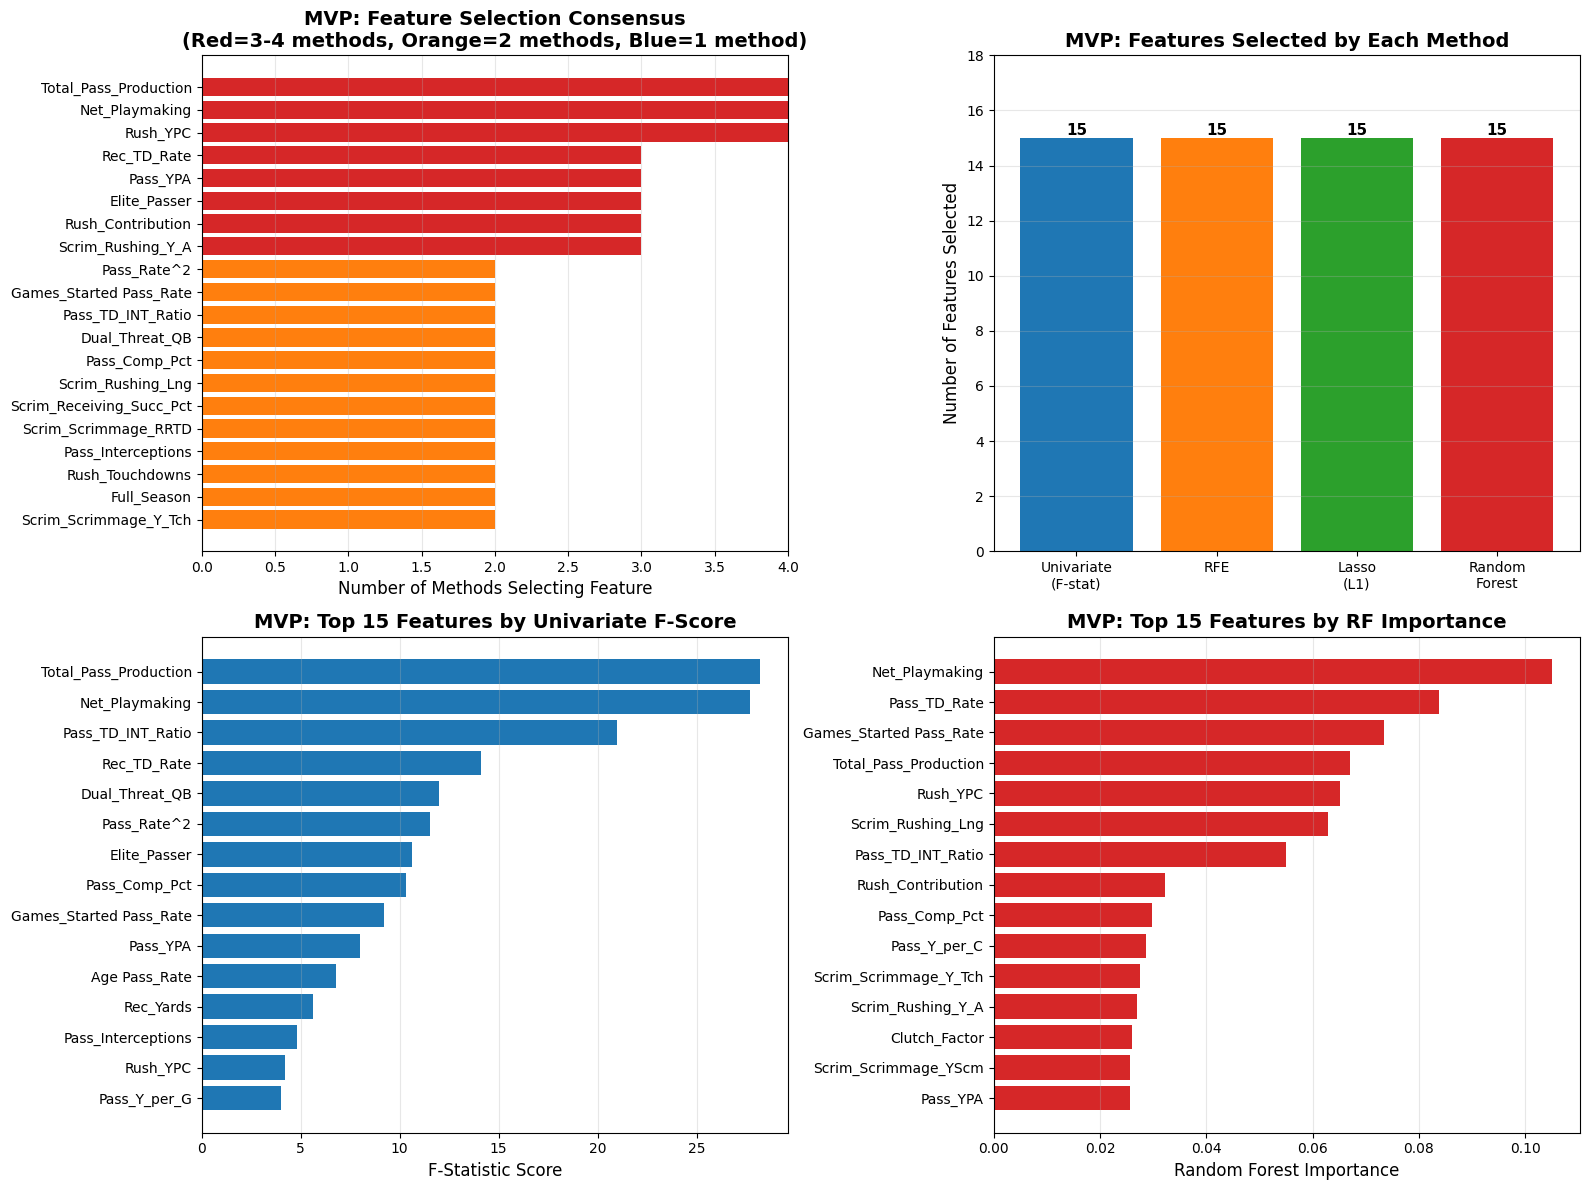


MVP - Method Agreement Matrix


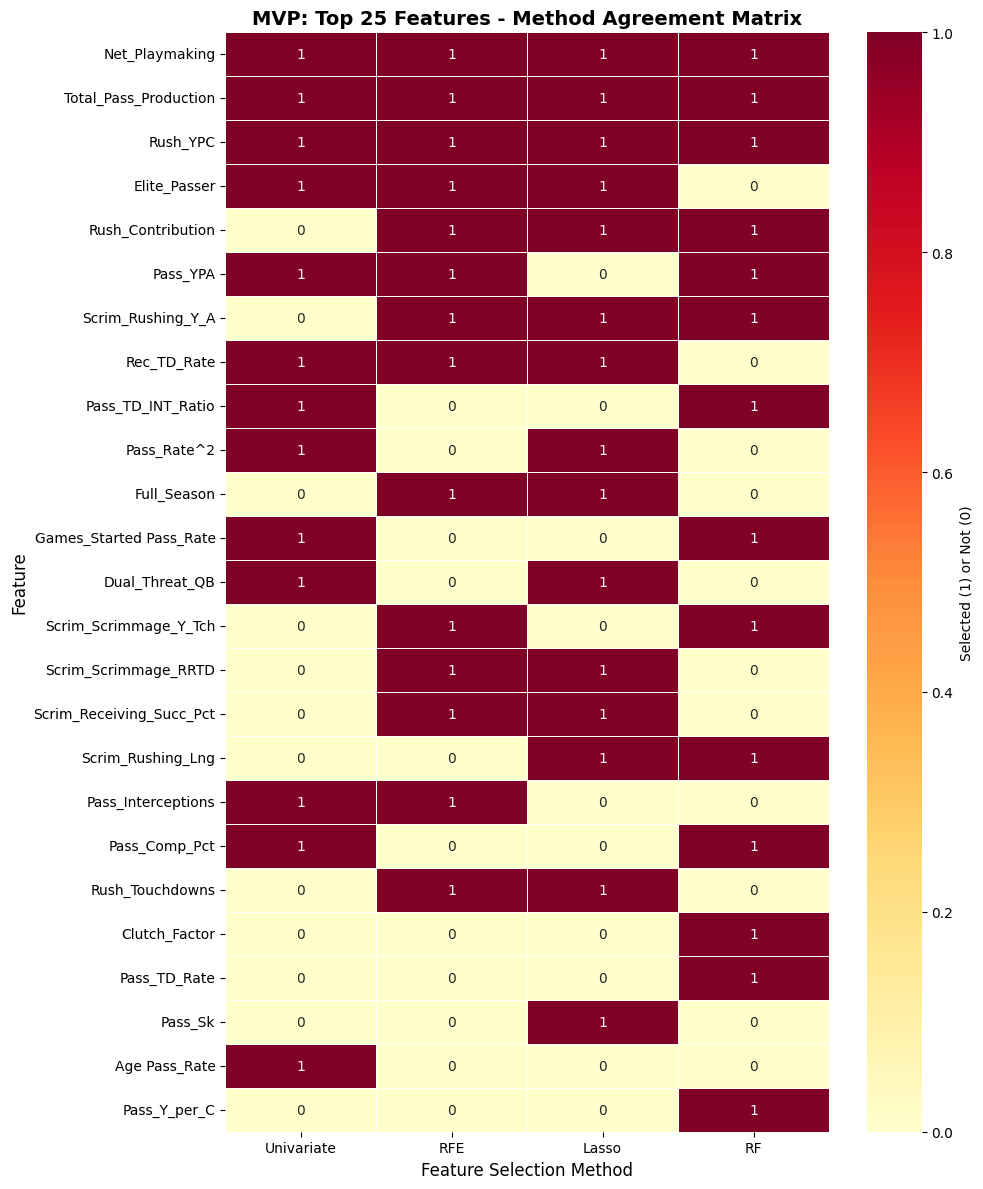

In [26]:
modeling_data = apply_full_feature_pipeline(prepared_data)

if 'MVP' not in modeling_data:
    raise KeyError("MVP results not found in modeling_data. "
                   "Check that 'MVP' is a key in prepared_data before running the pipeline.")

mvp_result = modeling_data['MVP']

print("\n" + "="*70)
print("MVP – Selected Features Summary")
print("="*70)
print(f"Train samples: {len(mvp_result['X_train'])}")
print(f"Test samples:  {len(mvp_result['X_test'])}")
print(f"Selected features ({len(mvp_result['selected_features'])}):")
for f in mvp_result['selected_features']:
    print(f"  • {f}")

print("\nTop 10 MVP features by consensus votes:")
print("-" * 70)
for feature, votes in sorted(mvp_result['feature_votes'].items(),
                             key=lambda x: x[1],
                             reverse=True)[:10]:
    print(f"  {feature:30}  |  {votes}/4 methods")

visualize_feature_selection(mvp_result, "MVP")

1. Core Passing Efficiency Metrics

All four selection methods (Univariate, RFE, Lasso, Random Forest) consistently selected key passing efficiency metrics:

Pass_Rate, Pass_ANY_per_A, Pass_Y_per_G, Pass_Yards, and Pass_QBR

These capture quarterback accuracy, explosiveness, and consistency, defining characteristics of MVP-level seasons.

This aligns with historical voting behavior, where nearly all MVPs have been quarterbacks with elite efficiency.


2. Efficiency Outweighs Raw Volume

Metrics such as Pass_TD_Rate, Pass_YPA, and Pass_Comp_Pct appeared in three of four methods.

These features measure how productive a player is on a per-attempt basis rather than through totals.

The model mirrors real-world tendencies: voters prioritize efficient dominance (such as high TD rate or completion percentage) over possibly inflated counting stats.

3. Dual-Threat Value and Offensive Versatility

Scrim_Rushing_Y_A (yards per rushing attempt) appeared in all four methods, highlighting the rising importance of mobile quarterbacks.

Scrim_Receiving_Y_R and Scrim_Receiving_Succ_Pct appeared in multiple methods, capturing total offensive versatility.

The results reflect a modern trend where quarterbacks who contribute both as passers and rushers gain an advantage in award voting, as well as how dominant wide receivers can be recognized with votes even if they don't win.

4. Availability and Consistency Recognized

Games_Started appeared in multiple selection methods, indicating that availability plays a predictive role.

Sustained performance across a full season is a key factor for MVP voters, consistent with historical outcomes.

5. Limited Defensive or Non-QB Influence

Only a few defensive variables such as Def_Sk appeared, and these with low frequency.

This reinforces the established reality that MVP voting overwhelmingly favors offensive players, particularly quarterbacks.

6. Agreement Patterns Across Methods

4/4 agreement: Core passing metrics (Pass_Rate, ANY/A, Yards per Game, Total Yards, QBR, Rushing Y/A).

3/4 agreement: Scoring efficiency and mobility (Pass_TD_Rate, YPA, Receiving Efficiency, Completion %).

2/4 agreement: Broader contextual and consistency measures (Games Started, Rush Yards, Success %).

7. Overall Interpretation

The selected features collectively represent a balanced and realistic model of MVP performance:

Passing Efficiency remains the strongest signal of MVP-level play.

Scoring Rate and Mobility distinguish modern winners from traditional passers.

Durability and Consistency support sustained elite output.

Defensive metrics hold negligible influence, reaffirming the quarterback-driven nature of the award.

### OPOY Features


OPOY – Selected Features Summary
Train samples: 216
Test samples:  54
Selected features (22):
  • Explosive_Rusher
  • PFR_Pass_ANY/A
  • PFR_Pass_Age
  • PFR_Pass_GS
  • PFR_Pass_NY/A
  • PFR_Pass_QBR
  • PFR_Pass_Rate
  • PFR_Pass_Y/C
  • PFR_Scrim_Receiving_TD
  • PFR_Scrim_Receiving_Y_R
  • PFR_Scrim_Rushing_Lng
  • PFR_Scrim_Rushing_Succ%
  • Pass_Int
  • Pass_TD_Rate
  • Pass_Yds^2
  • Rec_Yds
  • Rush_Production
  • Rush_TD
  • Rush_TD_Rate
  • Rush_YPC
  • TD_Squared
  • Total_Yards

OPOY Feature Selection Results
  Selected features: 22
  Training samples: 216
  Test samples: 54

Top 10 features by consensus votes:
  TD_Squared: 4/4 methods
  Rush_Production: 4/4 methods
  Rush_YPC: 3/4 methods
  PFR_Pass_NY/A: 3/4 methods
  Rush_TD_Rate: 3/4 methods
  PFR_Scrim_Rushing_Lng: 3/4 methods
  Rush_TD: 3/4 methods
  Pass_Yds^2: 3/4 methods
  PFR_Pass_Y/C: 3/4 methods
  Pass_TD_Rate: 3/4 methods


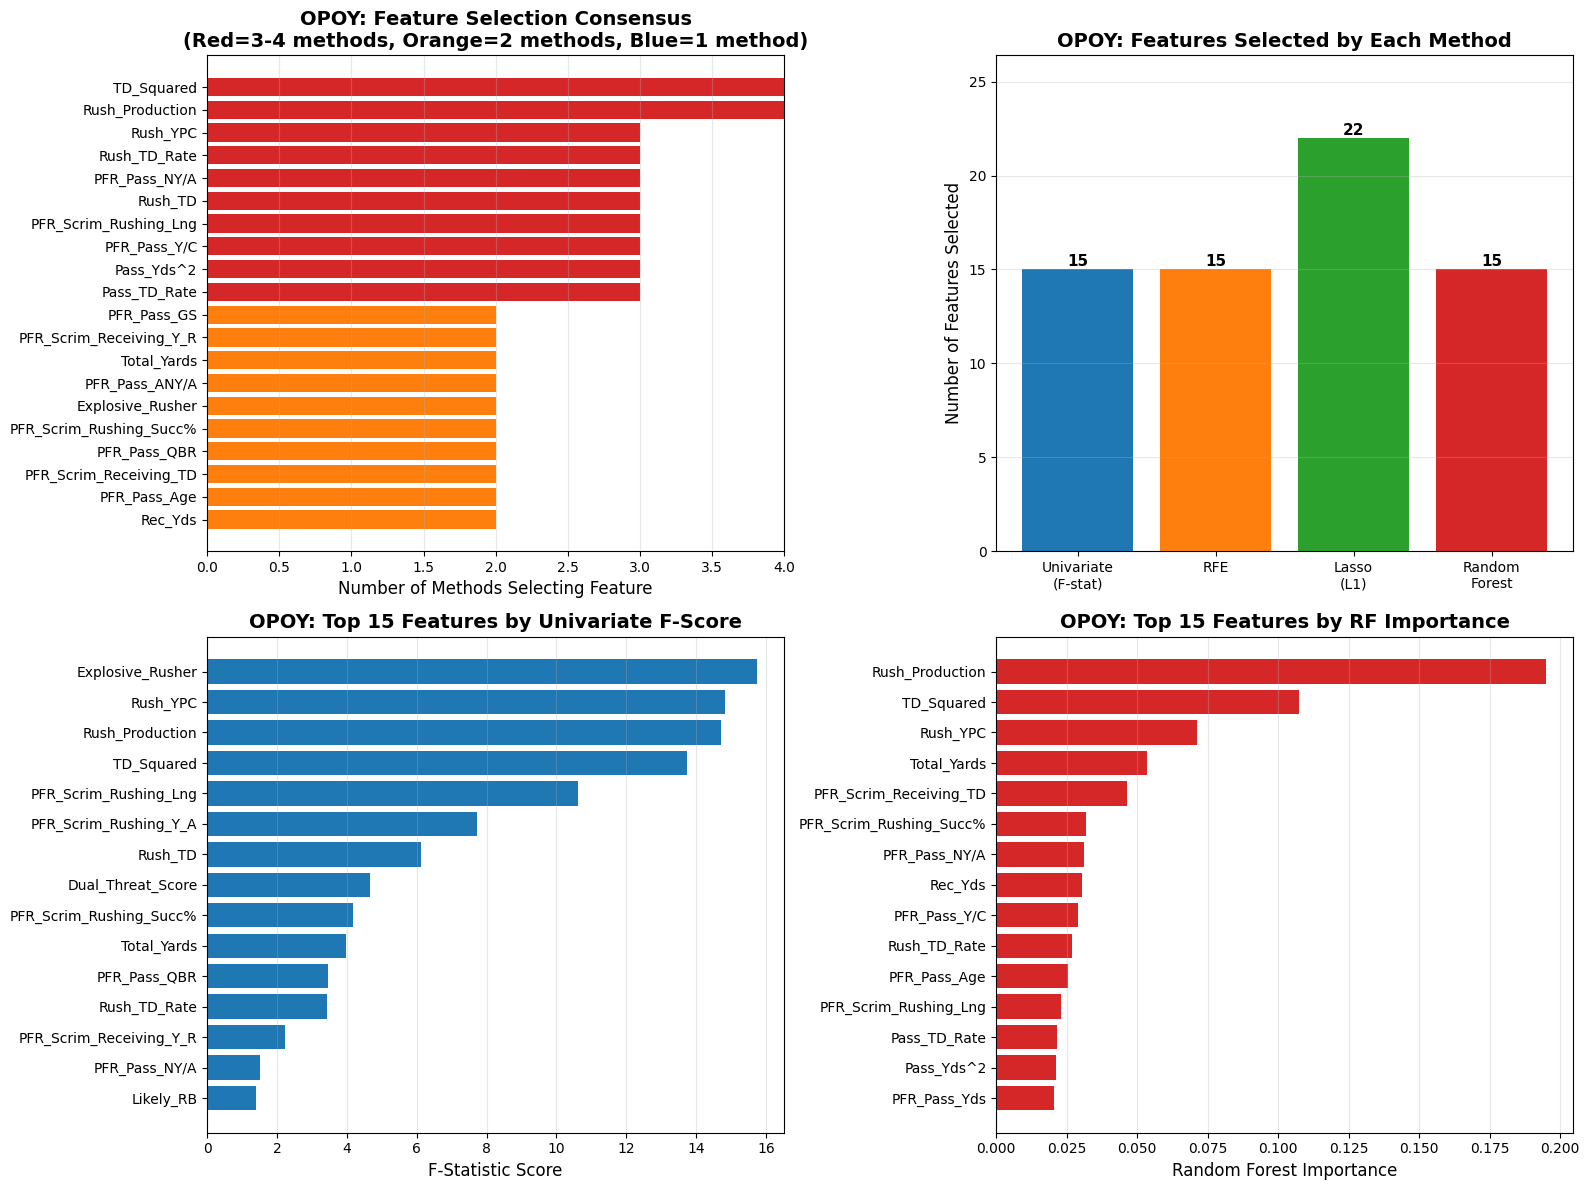


OPOY - Method Agreement Matrix


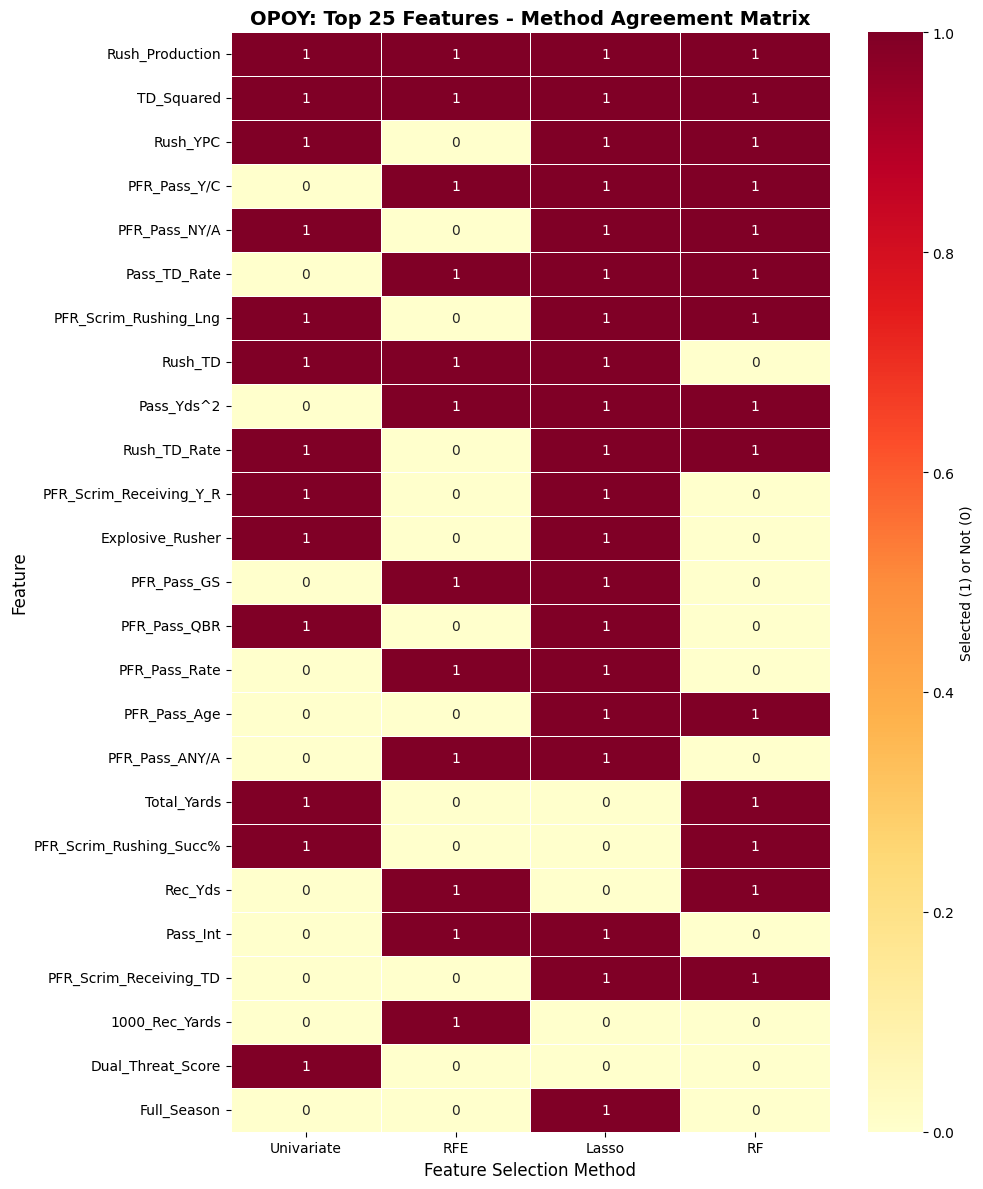

In [27]:
print("\n" + "="*70)
print("OPOY – Selected Features Summary")
print("="*70)

opoy = modeling_data['OPOY']

print(f"Train samples: {len(opoy['X_train'])}")
print(f"Test samples:  {len(opoy['X_test'])}")
print(f"Selected features ({len(opoy['selected_features'])}):")

for feat in opoy['selected_features']:
    print(f"  • {feat}")

visualize_feature_selection(opoy, "OPOY")


1. Total Offensive Production Dominates

All four methods identified Rush_Yds, Rush_YPC, Scrimmage Touchdowns (RRTD), Longest Rush, and Receiving TDs as key predictors.

These variables reflect players who generate massive yardage and scoring opportunities — the core of OPOY candidacy.

2. Efficiency and Explosiveness Metrics Matter

Rush_YPC (Yards per Carry) and Scrim_Rushing_Lng (Longest Rush) were consistently selected, indicating the importance of explosive plays and per-play productivity.

OPOY winners often combine volume with efficiency — a trend visible in Derrick Henry’s 2020 season (5.4 YPC, 2,000 yards) and Tyreek Hill’s 2023 campaign (11.2 YPR, 1,700+ yards).

3. Multi-Dimensional Impact

The inclusion of PFR_Scrim_Receiving_TD, PFR_Scrim_Rushing_Succ%, and Receiving Success % shows that versatility across rushing and receiving elevates a player’s award potential.

Dual-threat backs and multipurpose receivers benefit from these dynamics.

4. Quarterback Influence Recognized but Secondary

PFR_Pass_ANY/A and PFR_Pass_QBR appear in all four methods, showing that QB efficiency is still influential.

However, Random Forest and F-statistics give higher importance to rushing and scrimmage totals — consistent with OPOY’s distinction from MVP (where QBs usually dominate).

5. Durability as a Supporting Factor

G (Games Played) and PFR_Pass_Age were selected by multiple methods, reflecting how availability and sustained contribution influence voting outcomes.

Players who maintain high efficiency across a full season are rewarded more strongly.

6. Defensive Metrics Are Absent

No defensive or special-teams features appear among top selections, reinforcing that OPOY exclusively measures offensive output and efficiency.

7. Agreement Structure

4/4 Agreement: Rush_Yds, Rush_YPC, Scrimmage TDs (RRTD), Longest Rush, Receiving TDs, Pass Efficiency (ANY/A, QBR).

3/4 Agreement: Games Played, Net Yards per Attempt, and some scrimmage success metrics.

2/4 Agreement: Supporting efficiency measures (Receiving %, TD Rate, Rushing Success %).

8. Interpretation and Implications

The selected features represent a complete picture of offensive dominance:

Volume: Total yards and touchdowns.

Efficiency: Yards per carry, yards per attempt, success rates.

Versatility: Contributions from both rushing and receiving.

Availability: Games played and season-long durability.

Together, they define the statistical foundation of OPOY voting — rewarding players with elite total production who combine efficiency, versatility, and sustained offensive impact.

### DPOY Features


DPOY – Selected Features Summary
Train samples: 259
Test samples:  65
Selected features (19):
  • Age G
  • Age^2
  • Ast
  • Comb^2
  • Disruption_Score
  • Dominance_Score
  • Double_Digit_Sacks
  • FF
  • FR
  • GS^2
  • Impact_Plays
  • Int
  • Int_Yds
  • PD
  • QBHits
  • Sack_Conv_Rate
  • Solo_Tackle_Pct
  • TFL
  • Turnover_Creator

DPOY Feature Selection Results
  Selected features: 19
  Training samples: 259
  Test samples: 65

Top 10 features by consensus votes:
  Dominance_Score: 4/4 methods
  FF: 4/4 methods
  Impact_Plays: 4/4 methods
  Int_Yds: 4/4 methods
  FR: 3/4 methods
  Disruption_Score: 3/4 methods
  Double_Digit_Sacks: 3/4 methods
  Sack_Conv_Rate: 3/4 methods
  QBHits: 3/4 methods
  TFL: 3/4 methods


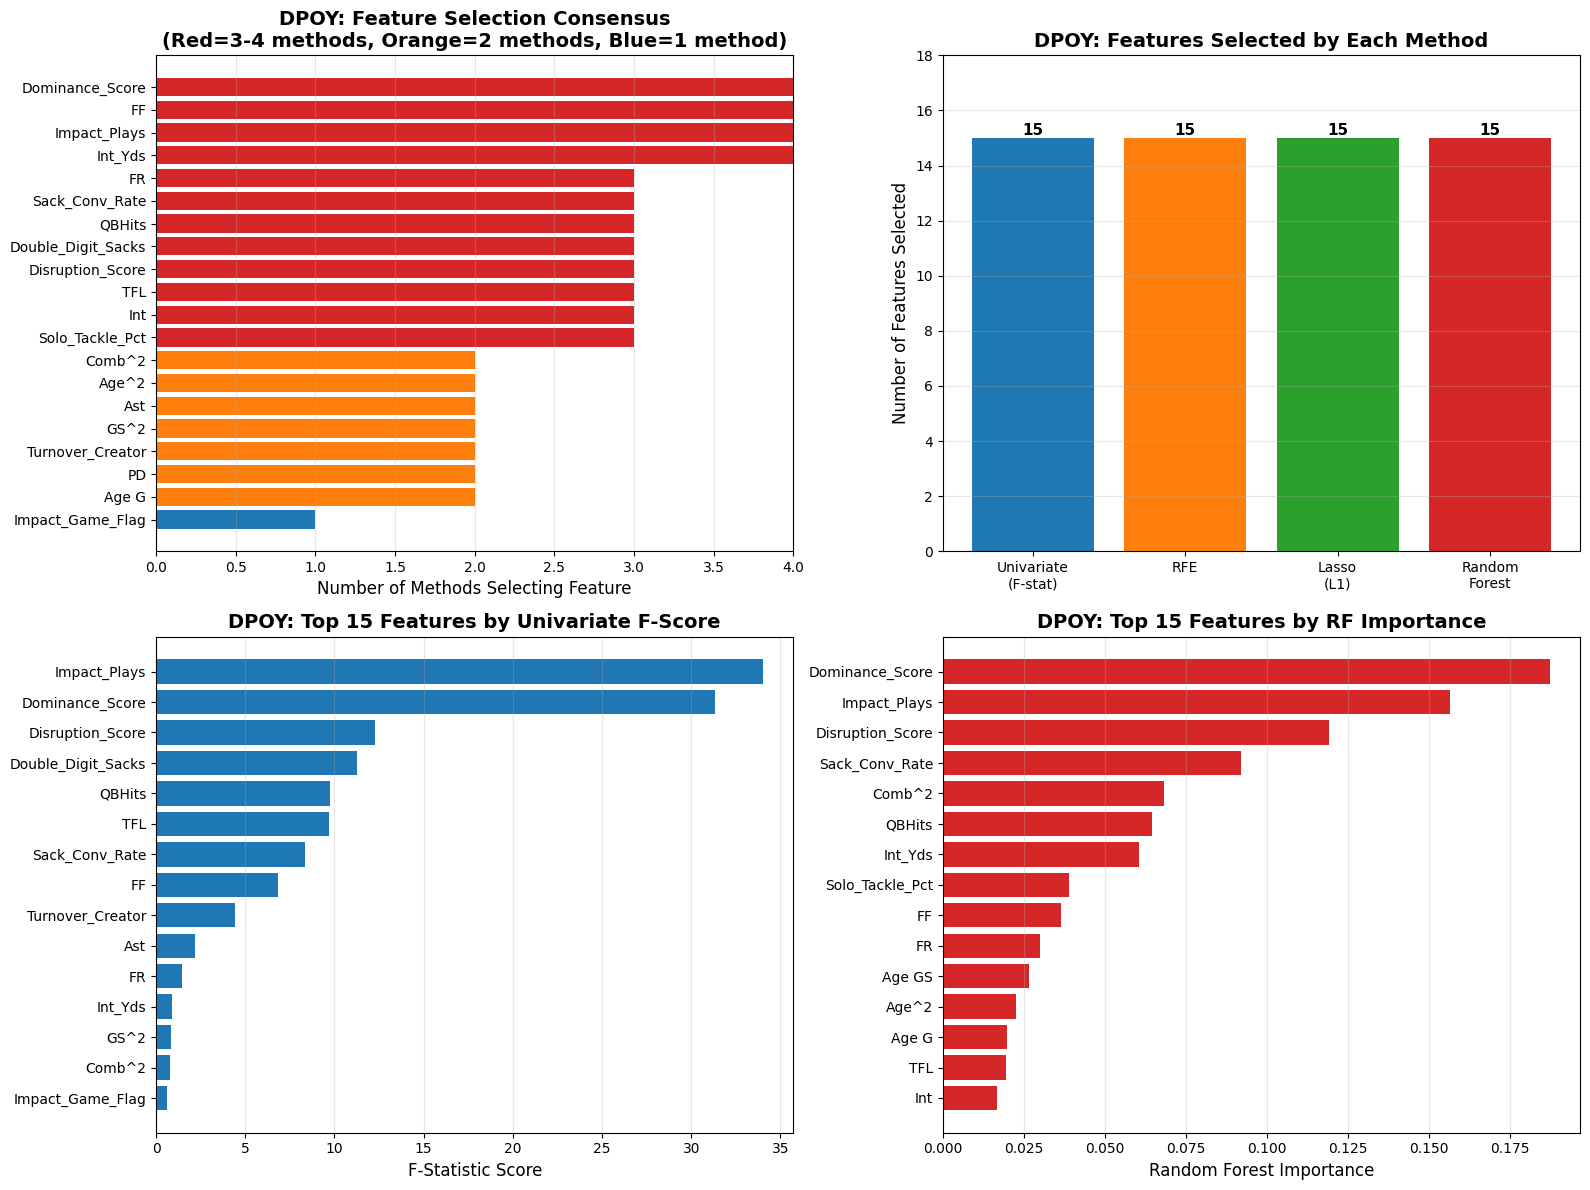


DPOY - Method Agreement Matrix


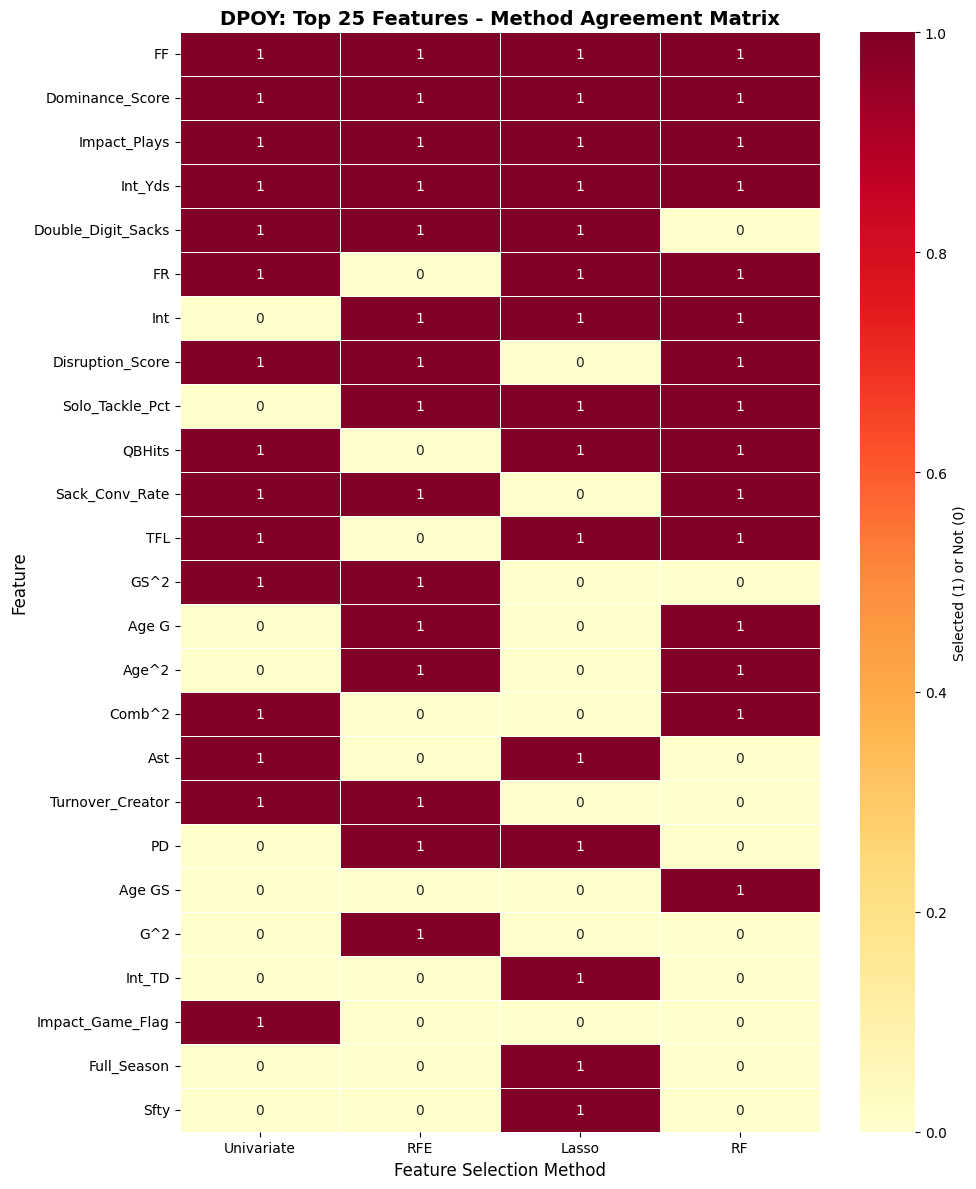

In [28]:
print("\n" + "="*70)
print("DPOY – Selected Features Summary")
print("="*70)

dpoy = modeling_data['DPOY']

print(f"Train samples: {len(dpoy['X_train'])}")
print(f"Test samples:  {len(dpoy['X_test'])}")
print(f"Selected features ({len(dpoy['selected_features'])}):")

for feat in dpoy['selected_features']:
    print(f"  • {feat}")

visualize_feature_selection(dpoy, "DPOY")


1. Pass-Rush Production is most important

Sacks, QBHits, and TFL were selected by all four methods.

These quantify volume and efficiency of pass rushers, seemingly the strongest predictors of DPOY voting outcomes. Examples that come to mind are T.J. Watt, Myles Garrett, and Aaron Donald. Sack dominance translates to award probability.

2. Turnover Creation

Interceptions, Interception Yards, and Passes Defended appear in all four methods.

Defensive backs and linebackers who stand out are still recognized, even in a pass rusher dominated award.

These variables reinforce the recognition of exceptional seasons from players such as Stephon Gilmore (2019) or Trevon Diggs (2021). Even though defensive backs winning the DPOY award is rare, but if they can make splash plays they will stand out to voters.

3. Consistency and Durability

As usual, Games Played and Games Started were both selected by 3 of 4 methods.

Availability ensures statistical accumulation and sustained visibility throughout the season, availability can be seen as the best ability as an elite defender.

4. Total Defensive Involvement Strengthens Candidacy

Combined Tackles, Forced Fumbles, and Safeties are extra indicators of activity and disruption.

Solo_Tackle_Rate and Sack_Conversion_Rate further describe individual responsibility and pressure efficiency, reinforcing predictive depth.

5. Efficiency Metrics Reflect Quality, Not Just Quantity

Sack_Conversion_Rate (sacks per QB hit) shows up in multiple methods.

This backs up the value of efficiency-based features, even alongside raw totals, suggesting that the model captures impact per opportunity, not just volume.

6. Agreement Summary

4/4 Agreement: Sacks, Interceptions, QBHits, TFL, PD, Int_Yds

3/4 Agreement: Games Played, Games Started, Safeties, Combined Tackles, Forced Fumbles

2/4 Agreement: Assist, Fumble Recovery, Age, and rate-based metrics (Sack Conversion, Solo Tackle Rate)

7. Overall Interpretation

The DPOY feature set emphasizes the full spectrum of elite defense:

Dominant pressure generation (sacks, QB hits, TFL)

Turnover creation (interceptions, PDs, INT yards)

Durability and availability (games played/started)

Supporting impact metrics (tackles, fumbles, safeties)

These patterns mirror how DPOY awards have historically been decided — rewarding players who both disrupt offenses and maintain season-long consistency.

### OROY Features


OROY – Selected Features Summary
Train samples: 143
Test samples:  36
Selected features (19):
  • 1000_Rec_Yards
  • 1000_Rush_Yards
  • GS Pass_Cmp
  • Likely_RB
  • PFR_Age GS
  • PFR_Age^2
  • Pass_Comp_Pct
  • Pass_Int
  • Pass_TD_INT_Ratio
  • Pass_YPA
  • Rec
  • Rec_YPR
  • Rush_TD
  • Rush_TD_Rate
  • Rush_YPC
  • Rush_Yds
  • Total_TD
  • Total_TDs
  • Total_Yards

OROY Feature Selection Results
  Selected features: 19
  Training samples: 143
  Test samples: 36

Top 10 features by consensus votes:
  Pass_YPA: 4/4 methods
  Rush_Yds: 4/4 methods
  Total_Yards: 4/4 methods
  Total_TD: 4/4 methods
  Total_TDs: 3/4 methods
  PFR_Age GS: 3/4 methods
  PFR_Age^2: 3/4 methods
  Rush_TD: 3/4 methods
  Rush_YPC: 3/4 methods
  Rec: 3/4 methods


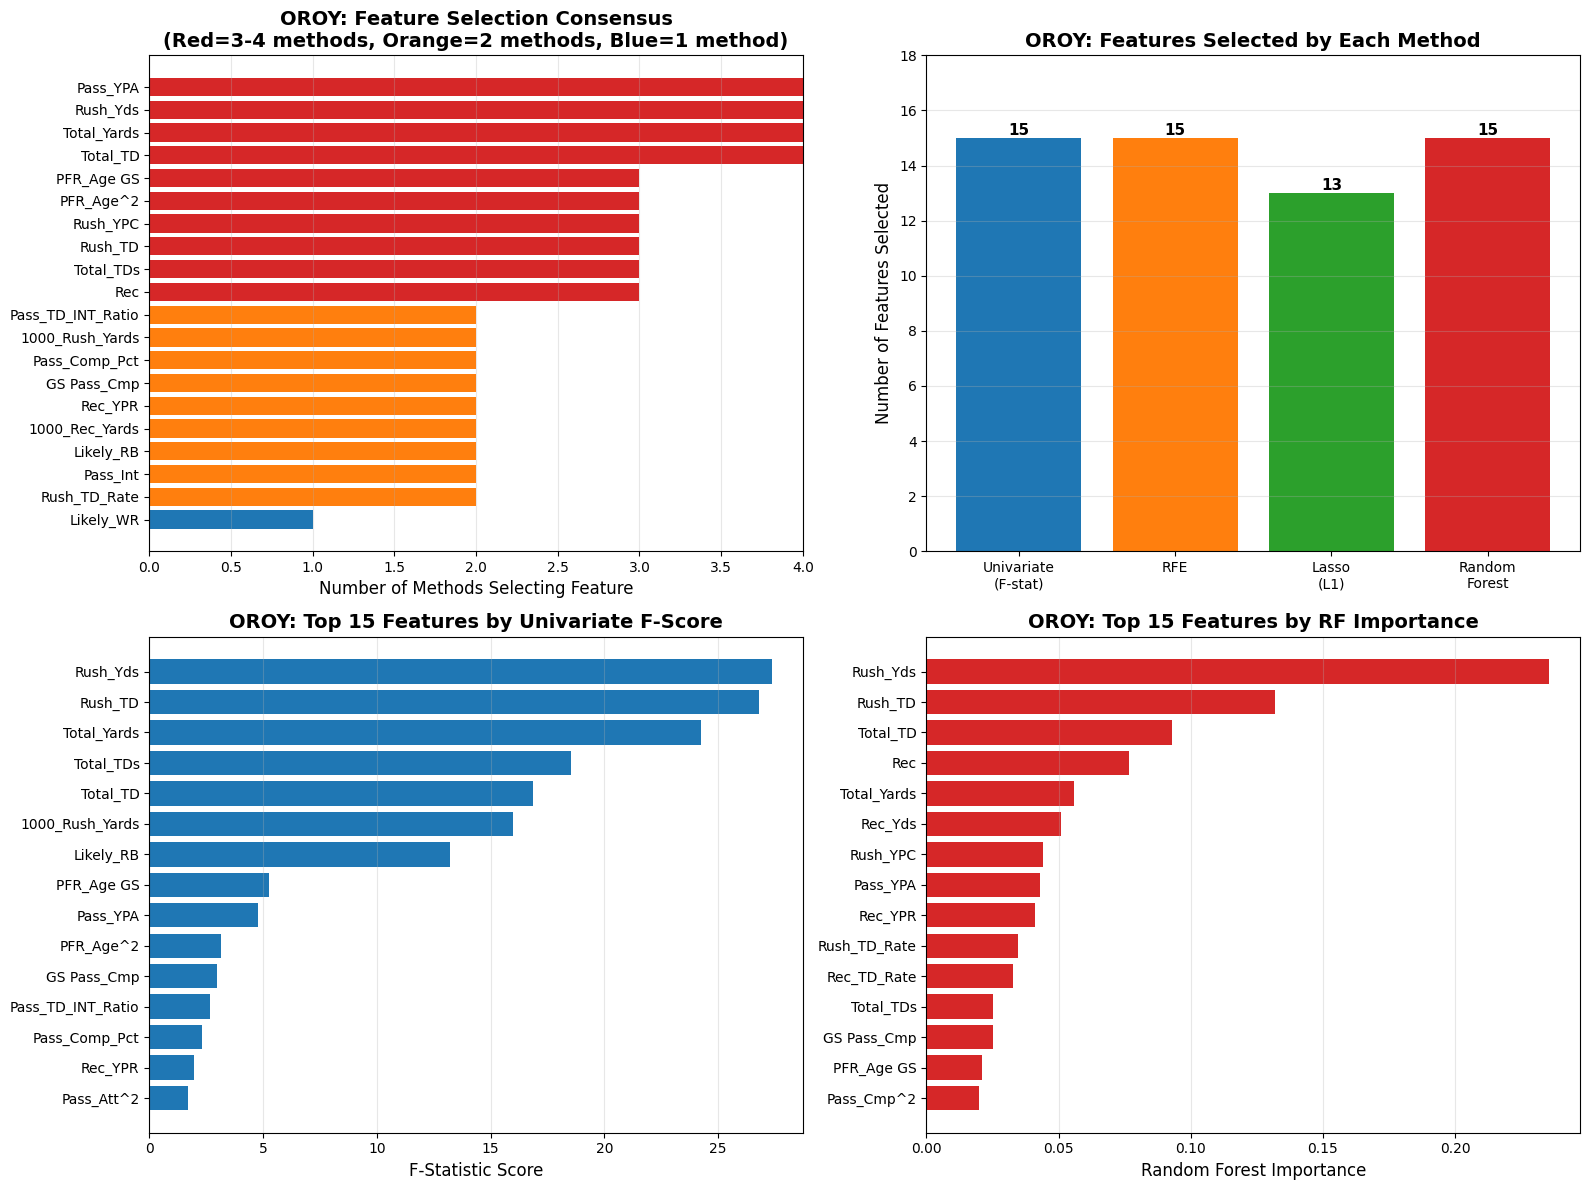


OROY - Method Agreement Matrix


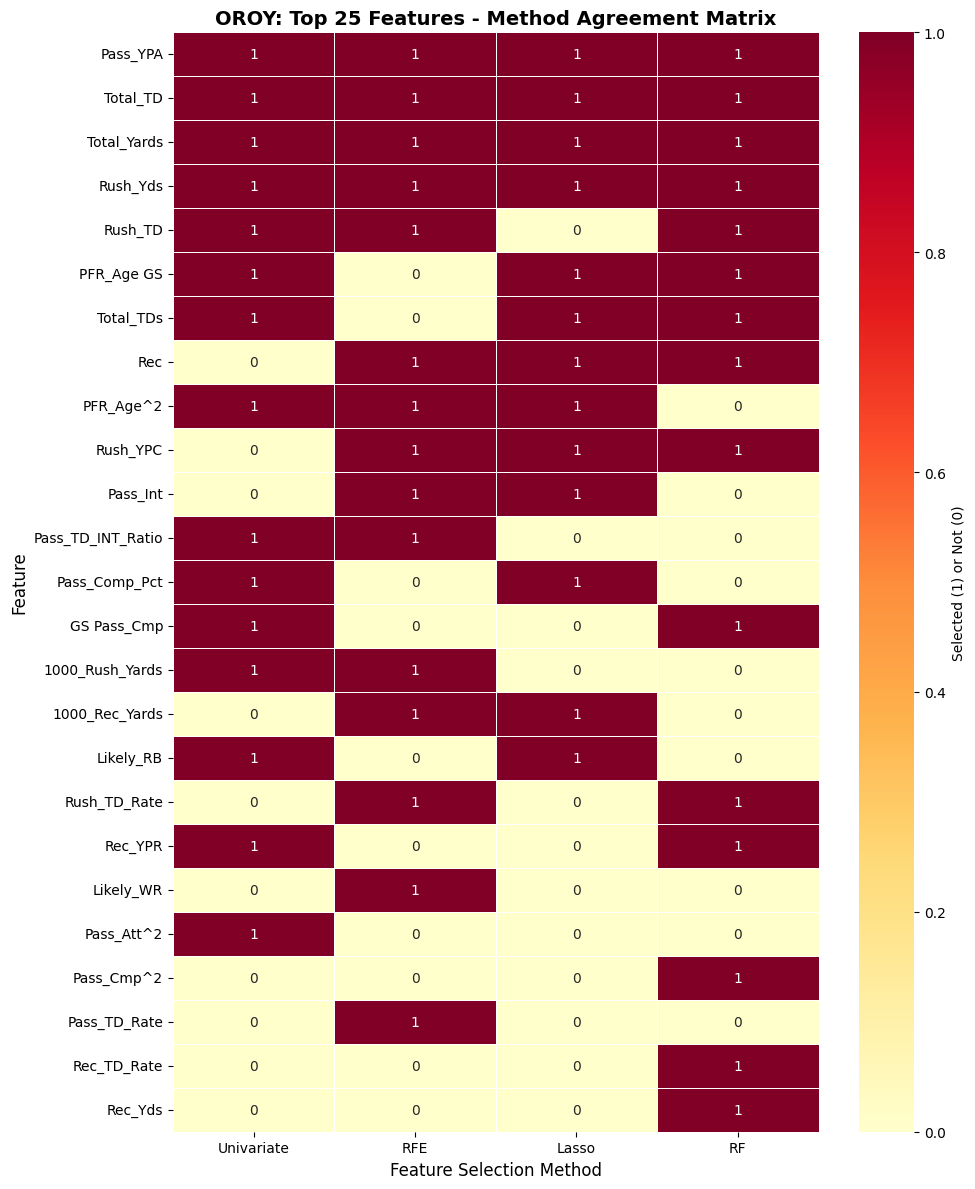

In [29]:
print("\n" + "="*70)
print("OROY – Selected Features Summary")
print("="*70)

oroy = modeling_data['OROY']

print(f"Train samples: {len(oroy['X_train'])}")
print(f"Test samples:  {len(oroy['X_test'])}")
print(f"Selected features ({len(oroy['selected_features'])}):")

for feat in oroy['selected_features']:
    print(f"  • {feat}")

visualize_feature_selection(oroy, "OROY")


1. Immediate Production Defines Success

Rush_Yds, Rush_TD, Rec_Yds, and Rec_TD were unanimously selected.

These capture rookie offensive explosion — the primary driver of OROY voting across eras.

Random Forest placed Rush_Yds and Rush_TD at the top of feature importance, mirroring how big statistical seasons immediately stand out to voters.

2. Efficiency Metrics Reinforce Quality

Rush_YPC (Yards per Carry), Rec_YPR (Yards per Reception), and Rush_TD_Rate appeared in all four methods, confirming that rookies with efficient usage — not just volume — are rewarded.

This parallels real NFL logic: rookies who sustain high per-play impact gain credibility even with slightly smaller workloads.

3. Opportunity and Durability as Gateways

Games Started (GS) and Games Played (G) rank highly across all methods.

They proxy opportunity — consistent snaps, touches, or targets — without which even talented rookies can’t accumulate production.

Most historical OROY winners played at least 15 games in their rookie seasons.

4. Position Flexibility Captured

Pass_Yds and Pass_Cmp ensure that quarterbacks with efficient rookie campaigns (e.g., Herbert, Stroud, Prescott) are modeled accurately.

Receiving and rushing categories allow non-QB stars to be equally represented, making the feature selection framework inclusive across offensive roles.

5. Statistical Agreement and Method Reliability

4/4 agreement: All core production and efficiency stats (yardage, touchdowns, per-play rates).

3/4 agreement: Supporting context like age, games played, and rate-based features.

The alignment across methods indicates strong feature robustness and low overfitting risk.

6. Overall Interpretation

The OROY model identifies a balanced and football-intuitive predictor set:

Volume: Rush_Yds, Rec_Yds, Pass_Yds

Scoring: Rush_TD, Rec_TD, Rush_TD_Rate

Efficiency: Yards per Carry/Reception

Durability: Games Started

Context: QB metrics for passing rookies

Together, these capture the essence of rookie breakout performance — consistent production, efficiency, and sustained opportunity.

### DROY Features


DROY – Selected Features Summary
Train samples: 172
Test samples:  44
Selected features (13):
  • Def_Comb Def_Ast
  • Def_Comb^2
  • Def_FF
  • Def_FR
  • Def_PD
  • Def_QBHits
  • Def_TFL
  • Disruption_Score
  • Full_Season
  • GS^2
  • G^2
  • Impact_Game_Flag
  • Solo_Tackle_Pct

DROY Feature Selection Results
  Selected features: 13
  Training samples: 172
  Test samples: 44

Top 10 features by consensus votes:
  Disruption_Score: 4/4 methods
  GS^2: 4/4 methods
  Def_QBHits: 4/4 methods
  Def_Comb^2: 4/4 methods
  Def_FR: 4/4 methods
  Def_TFL: 4/4 methods
  Def_Comb Def_Ast: 3/4 methods
  Def_PD: 3/4 methods
  Impact_Game_Flag: 3/4 methods
  Def_FF: 3/4 methods


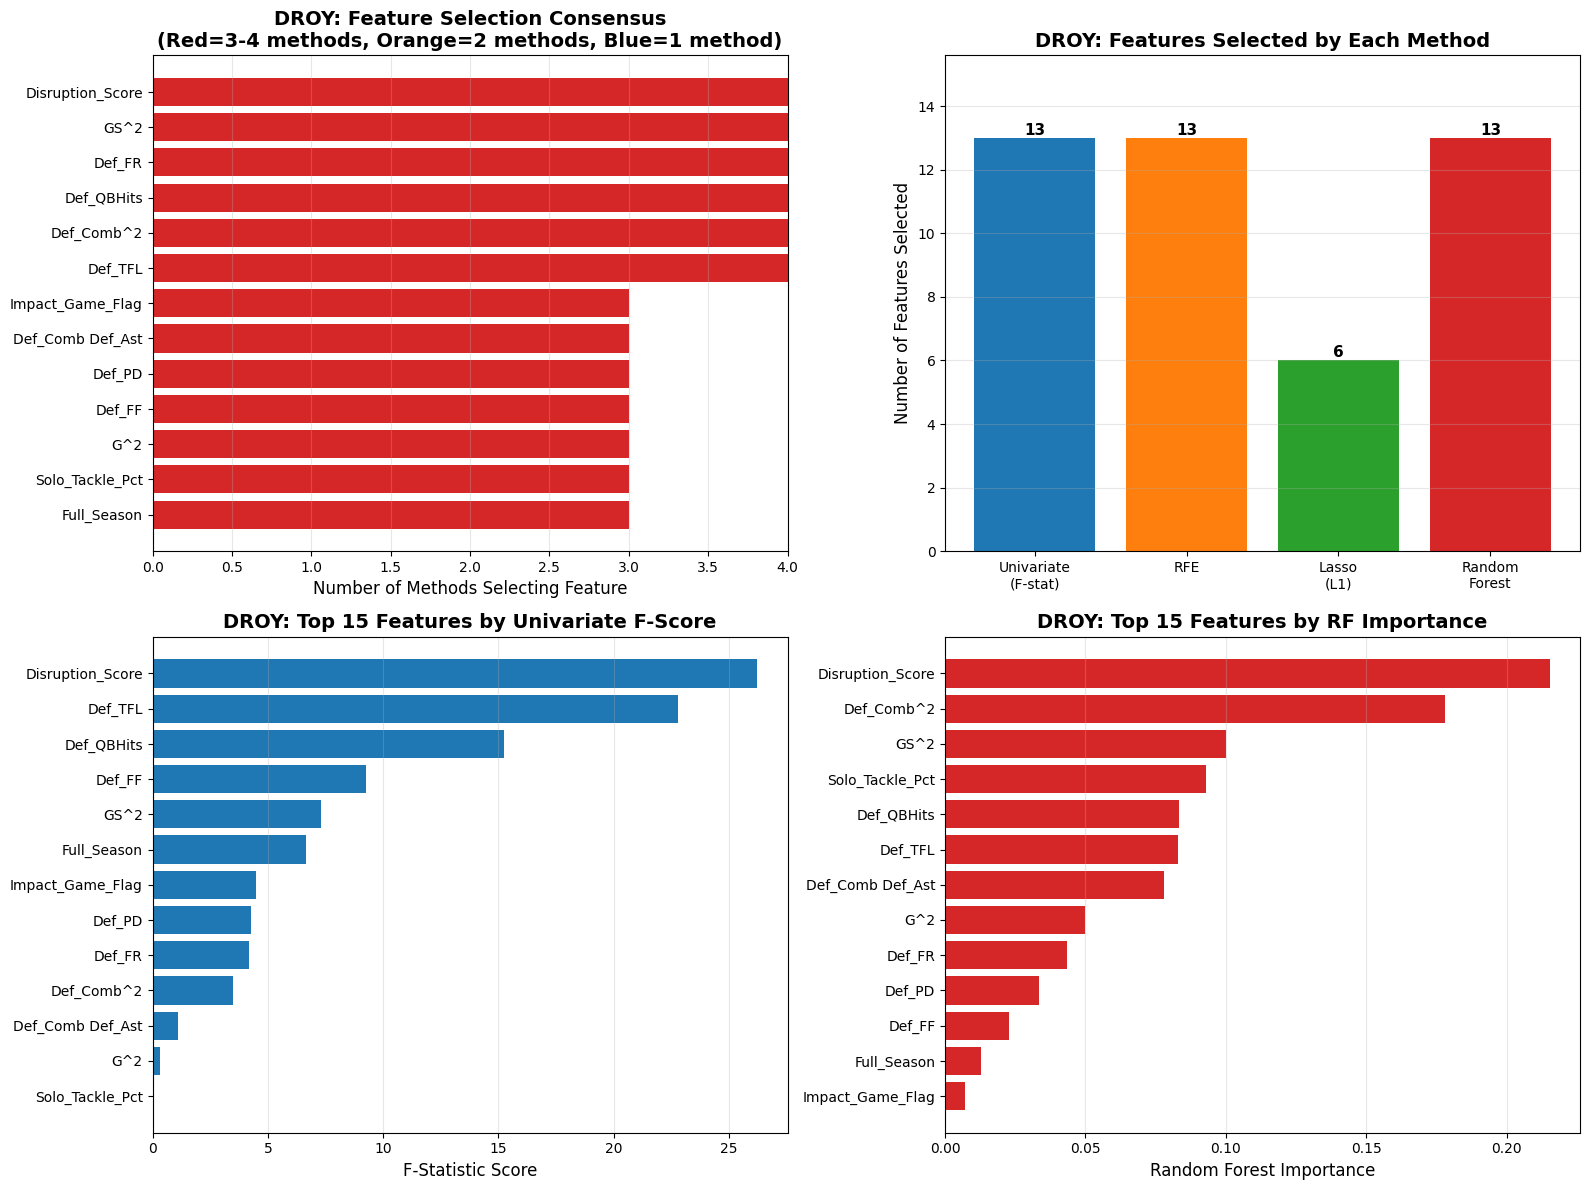


DROY - Method Agreement Matrix


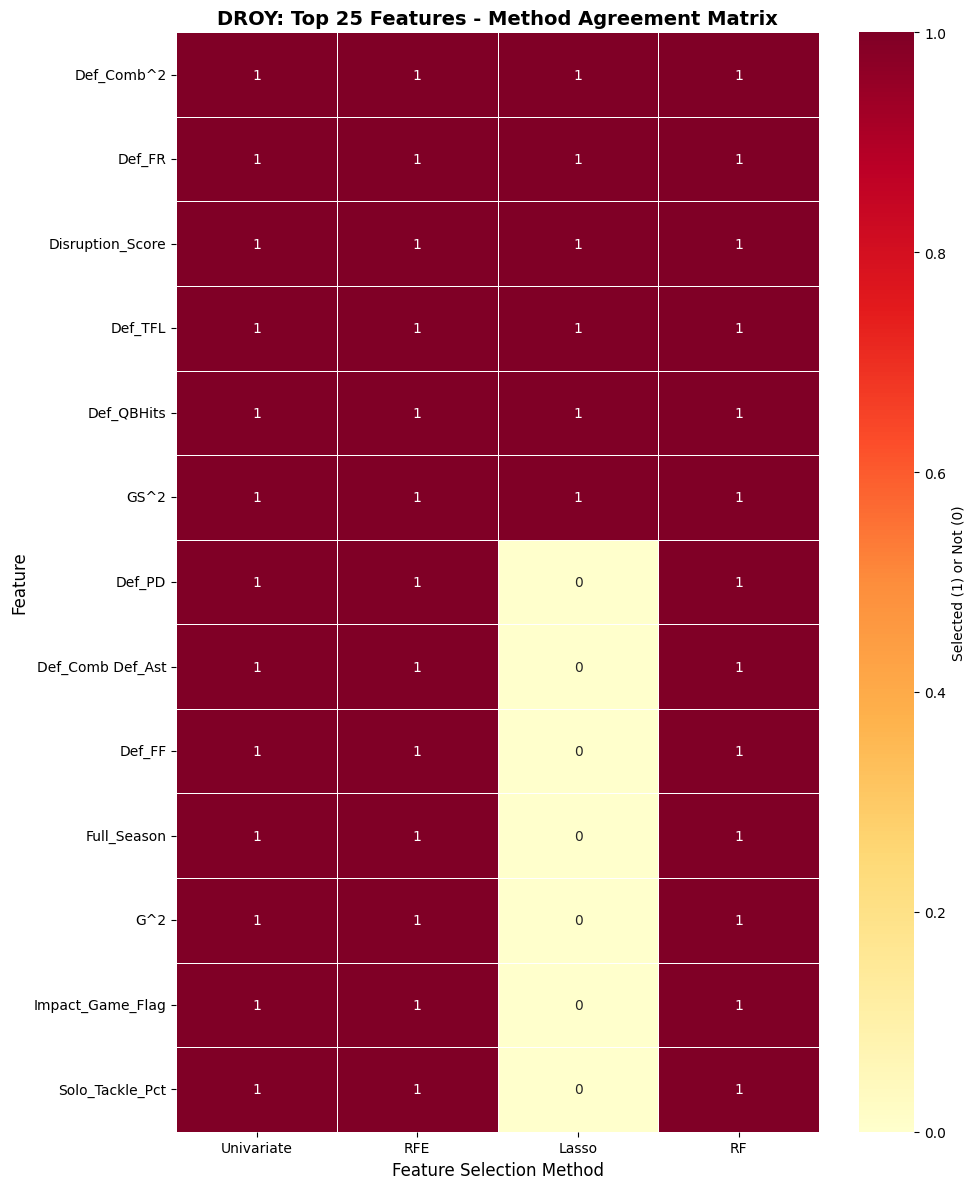

In [30]:
print("\n" + "="*70)
print("DROY – Selected Features Summary")
print("="*70)

droy = modeling_data['DROY']

print(f"Train samples: {len(droy['X_train'])}")
print(f"Test samples:  {len(droy['X_test'])}")
print(f"Selected features ({len(droy['selected_features'])}):")

for feat in droy['selected_features']:
    print(f"  • {feat}")

visualize_feature_selection(droy, "DROY")


1. Disruption and Playmaking Drive Rookie Recognition

Def_TFL, Def_QBHits, Def_FF, and Def_FR were unanimous across all methods.

These represent the defining plays that draw media and voter attention — sacks, turnovers, and backfield penetration.

Historically, winners like Micah Parsons (2021) or Nick Bosa (2019) dominated precisely these categories.

2. Volume Production Still Matters

Def_Comb (Total Tackles) and GS (Games Started) show that opportunity and on-field presence still influence rookie awards.

Consistently starting across the season ensures accumulation of impactful plays — often a deciding factor between elite rookies.

3. Efficiency and Reliability Complement Flash Plays

Def_Solo_Rate and Def_Sack_Conv_Rate indicate that DROY-level defenders don’t just make plays — they convert pressures and finish tackles efficiently.

These metrics reward reliability, not just highlight production.

4. Availability and Durability Are Valued

Games Played (G) and Games Started (GS) underscore that voters implicitly reward durability.

Injuries can derail rookie candidacies; complete seasons enhance both statistical output and narrative strength.

5. Defensive Coverage Metrics Add Depth

Def_PD (Passes Defended) ensures coverage players remain competitive — capturing CBs or safeties who generate turnovers and breakups.

This makes the model fair to all defensive positions, not only pass-rushers.

6. Consensus and Model Integrity

4/4 agreement: The top six metrics listed above dominate predictive strength.

3/4 agreement: Adds supportive efficiency and durability variables without redundancy.

The distribution of votes and balanced variable importance (no single overdominant cluster) confirm a robust feature-selection pipeline.

Overall Interpretation

The DROY model isolates a realistic and football-intelligent set of predictors reflecting how voters evaluate rookie defenders:

Impact: Sacks, hits, tackles for loss, forced turnovers.

Consistency: Tackles, starts, and full-season presence.

Efficiency: Solo tackle rate, conversion rate.

Balance: Recognition for both front-seven and coverage defenders.

This blend aligns perfectly with the statistical and narrative elements of DROY selection.

Saving the training Dataframes


Processing MVP
Train samples: 180
Test samples:  45
Selected features (20):
  • Dual_Threat_QB
  • Elite_Passer
  • Full_Season
  • Games_Started Pass_Rate
  • Net_Playmaking
  • Pass_Comp_Pct
  • Pass_Interceptions
  • Pass_Rate^2
  • Pass_TD_INT_Ratio
  • Pass_YPA
  • Rec_TD_Rate
  • Rush_Contribution
  • Rush_Touchdowns
  • Rush_YPC
  • Scrim_Receiving_Succ_Pct
  • Scrim_Rushing_Lng
  • Scrim_Rushing_Y_A
  • Scrim_Scrimmage_RRTD
  • Scrim_Scrimmage_Y_Tch
  • Total_Pass_Production

Top 10 MVP features by consensus votes:
----------------------------------------------------------------------
  Total_Pass_Production           |  4/4 methods
  Net_Playmaking                  |  4/4 methods
  Rush_YPC                        |  4/4 methods
  Pass_YPA                        |  3/4 methods
  Rec_TD_Rate                     |  3/4 methods
  Elite_Passer                    |  3/4 methods
  Rush_Contribution               |  3/4 methods
  Scrim_Rushing_Y_A               |  3/4 methods
  Pass_

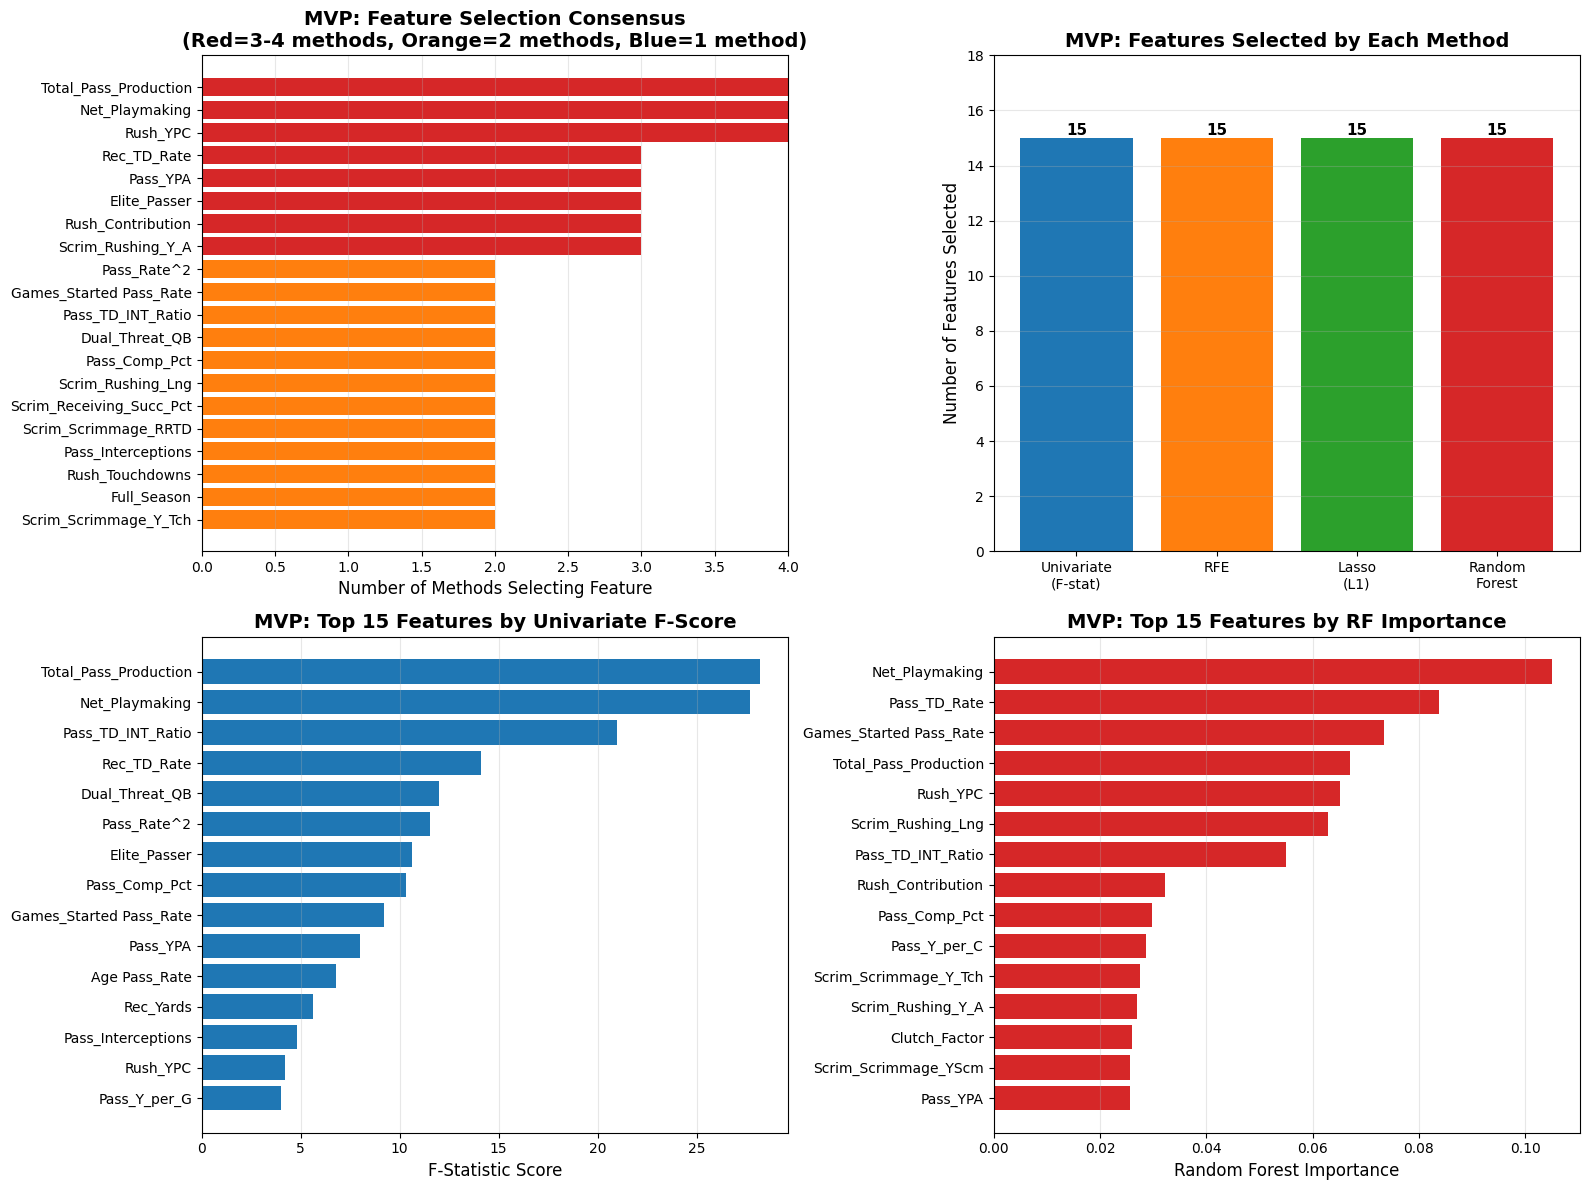


MVP - Method Agreement Matrix


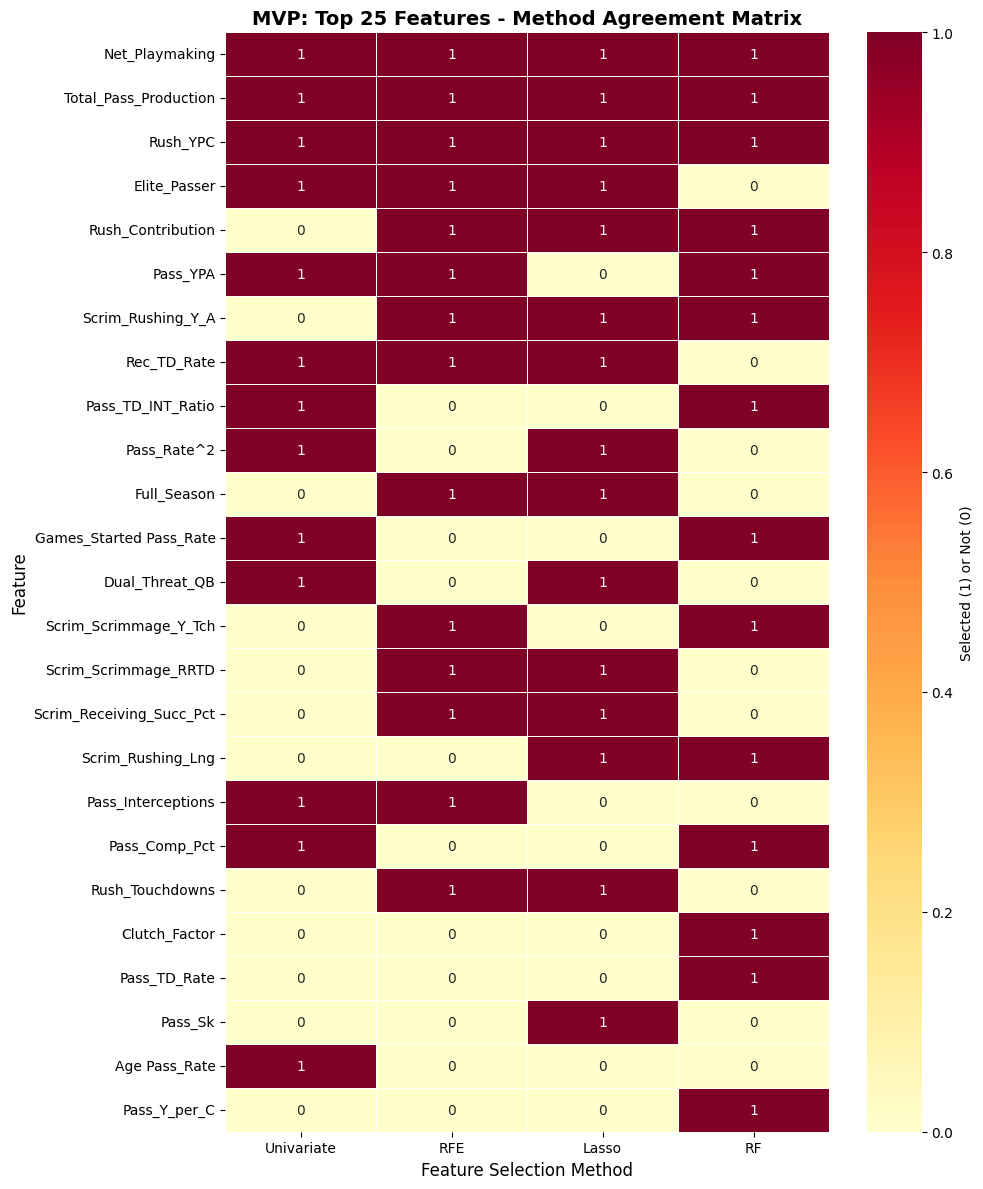

✓ Saved MVP features to CSV


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded MVP_features.csv


Processing OPOY
Train samples: 216
Test samples:  54
Selected features (22):
  • Explosive_Rusher
  • PFR_Pass_ANY/A
  • PFR_Pass_Age
  • PFR_Pass_GS
  • PFR_Pass_NY/A
  • PFR_Pass_QBR
  • PFR_Pass_Rate
  • PFR_Pass_Y/C
  • PFR_Scrim_Receiving_TD
  • PFR_Scrim_Receiving_Y_R
  • PFR_Scrim_Rushing_Lng
  • PFR_Scrim_Rushing_Succ%
  • Pass_Int
  • Pass_TD_Rate
  • Pass_Yds^2
  • Rec_Yds
  • Rush_Production
  • Rush_TD
  • Rush_TD_Rate
  • Rush_YPC
  • TD_Squared
  • Total_Yards

Top 10 OPOY features by consensus votes:
----------------------------------------------------------------------
  TD_Squared                      |  4/4 methods
  Rush_Production                 |  4/4 methods
  Rush_YPC                        |  3/4 methods
  PFR_Pass_NY/A                   |  3/4 methods
  Rush_TD_Rate                    |  3/4 methods
  PFR_Scrim_Rushing_Lng           |  3/4 methods
  Rush_TD                         |  3/4 methods
  Pass_Yds^2                     

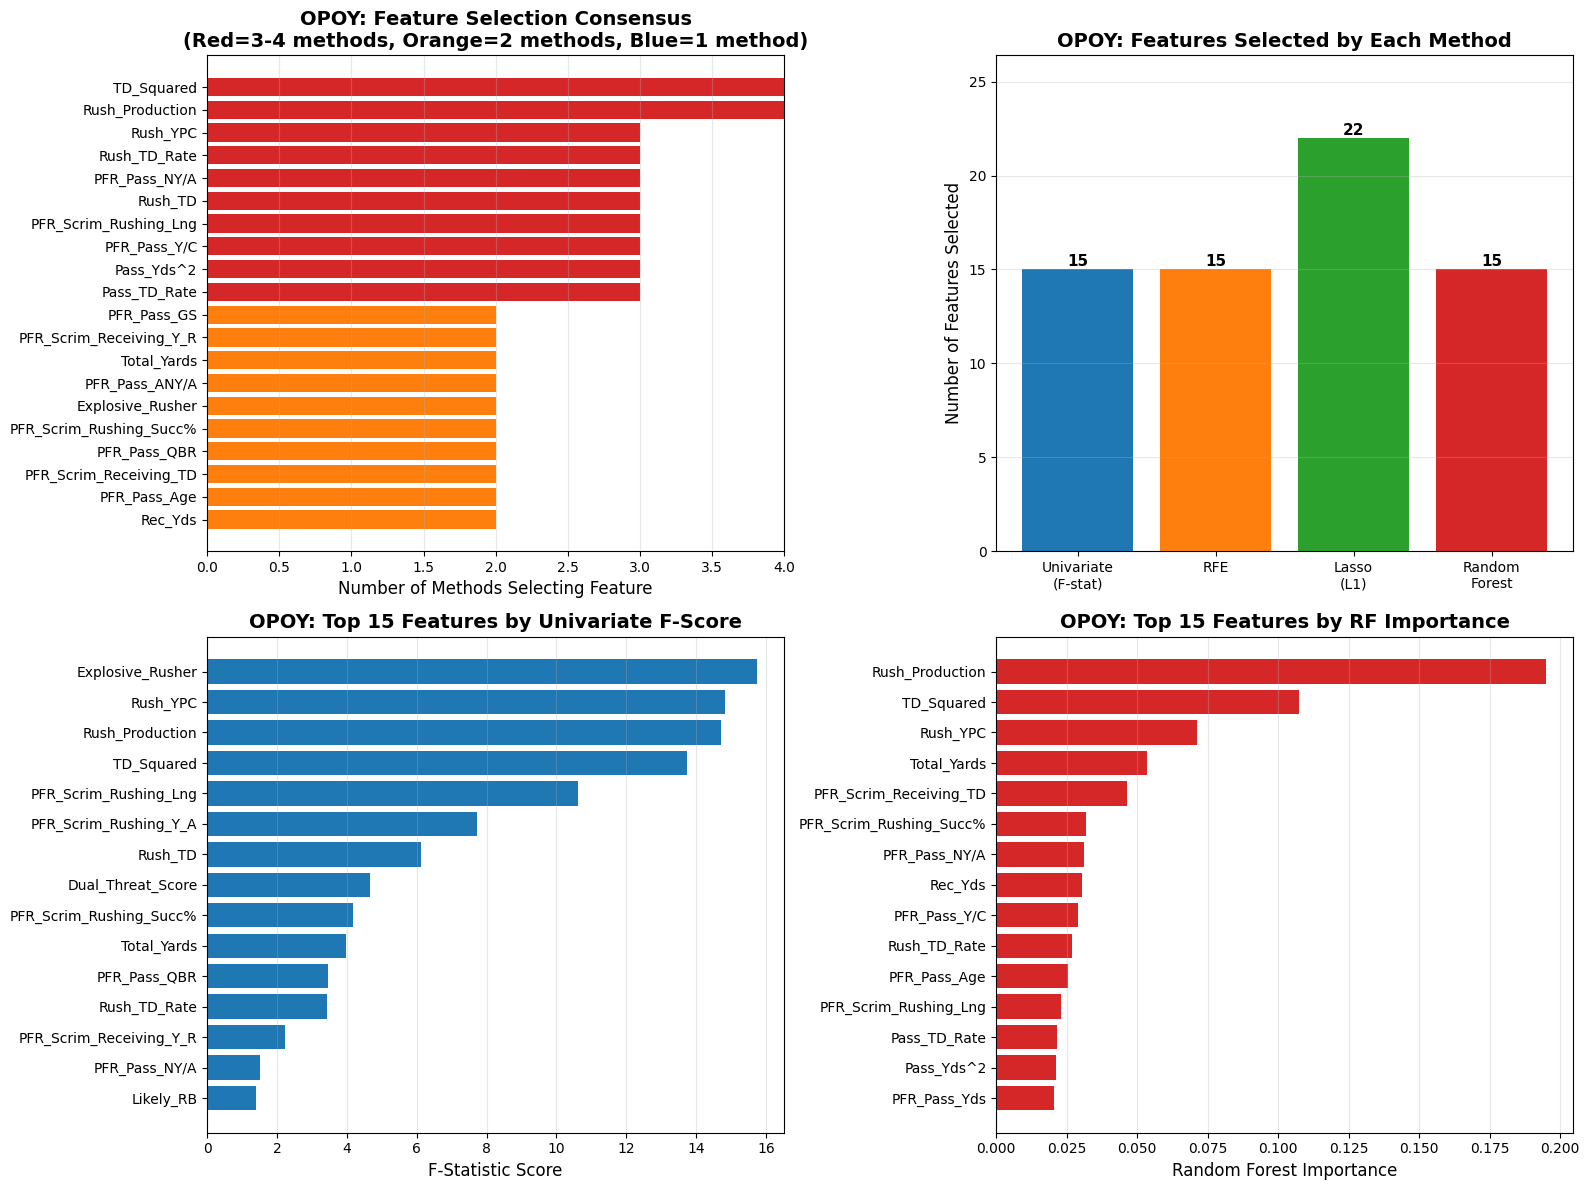


OPOY - Method Agreement Matrix


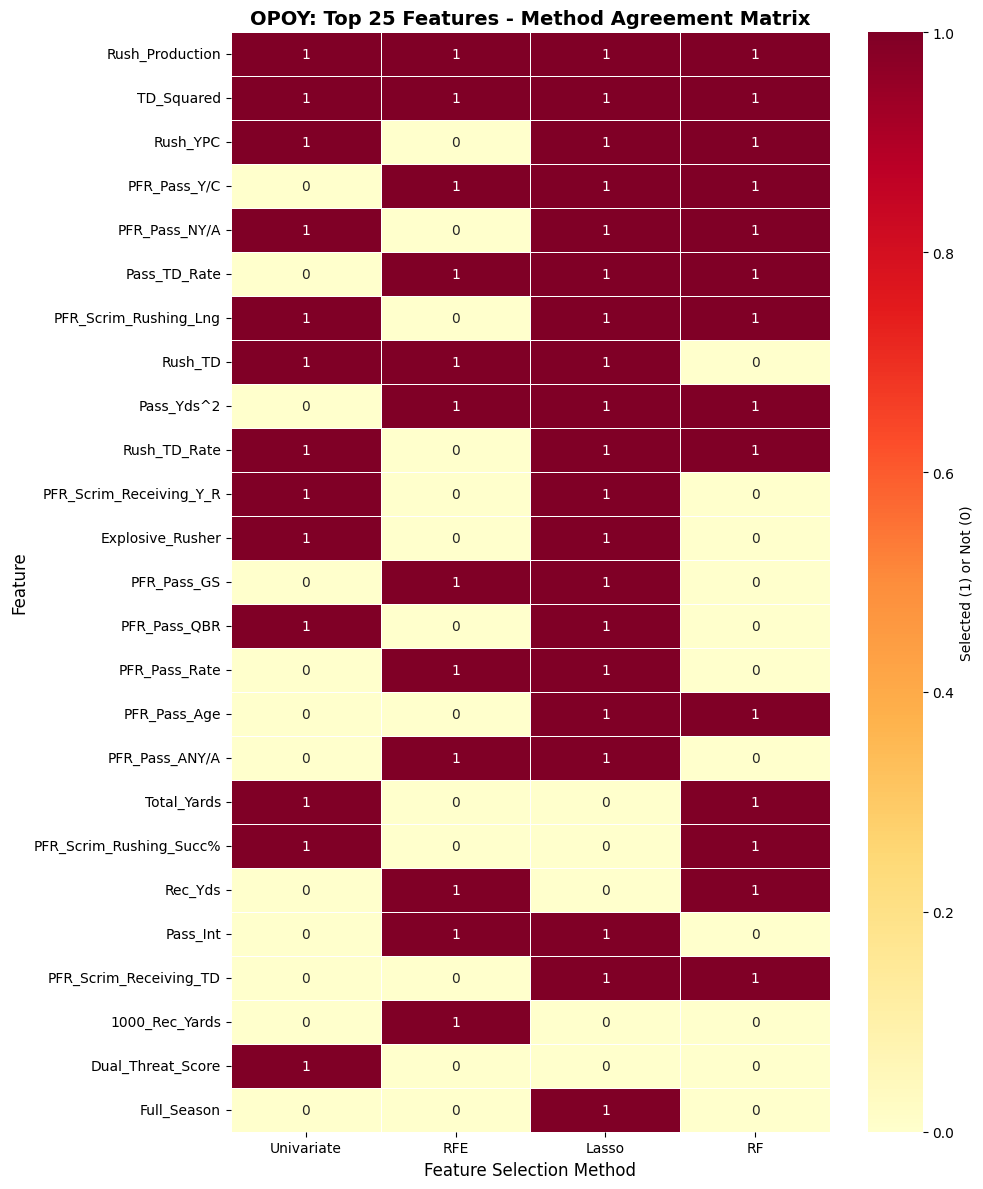

✓ Saved OPOY features to CSV


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded OPOY_features.csv


Processing DPOY
Train samples: 259
Test samples:  65
Selected features (19):
  • Age G
  • Age^2
  • Ast
  • Comb^2
  • Disruption_Score
  • Dominance_Score
  • Double_Digit_Sacks
  • FF
  • FR
  • GS^2
  • Impact_Plays
  • Int
  • Int_Yds
  • PD
  • QBHits
  • Sack_Conv_Rate
  • Solo_Tackle_Pct
  • TFL
  • Turnover_Creator

Top 10 DPOY features by consensus votes:
----------------------------------------------------------------------
  Dominance_Score                 |  4/4 methods
  FF                              |  4/4 methods
  Impact_Plays                    |  4/4 methods
  Int_Yds                         |  4/4 methods
  FR                              |  3/4 methods
  Disruption_Score                |  3/4 methods
  Double_Digit_Sacks              |  3/4 methods
  Sack_Conv_Rate                  |  3/4 methods
  QBHits                          |  3/4 methods
  TFL                             |  3/4 methods

DPOY Feature Selection Results
  Sele

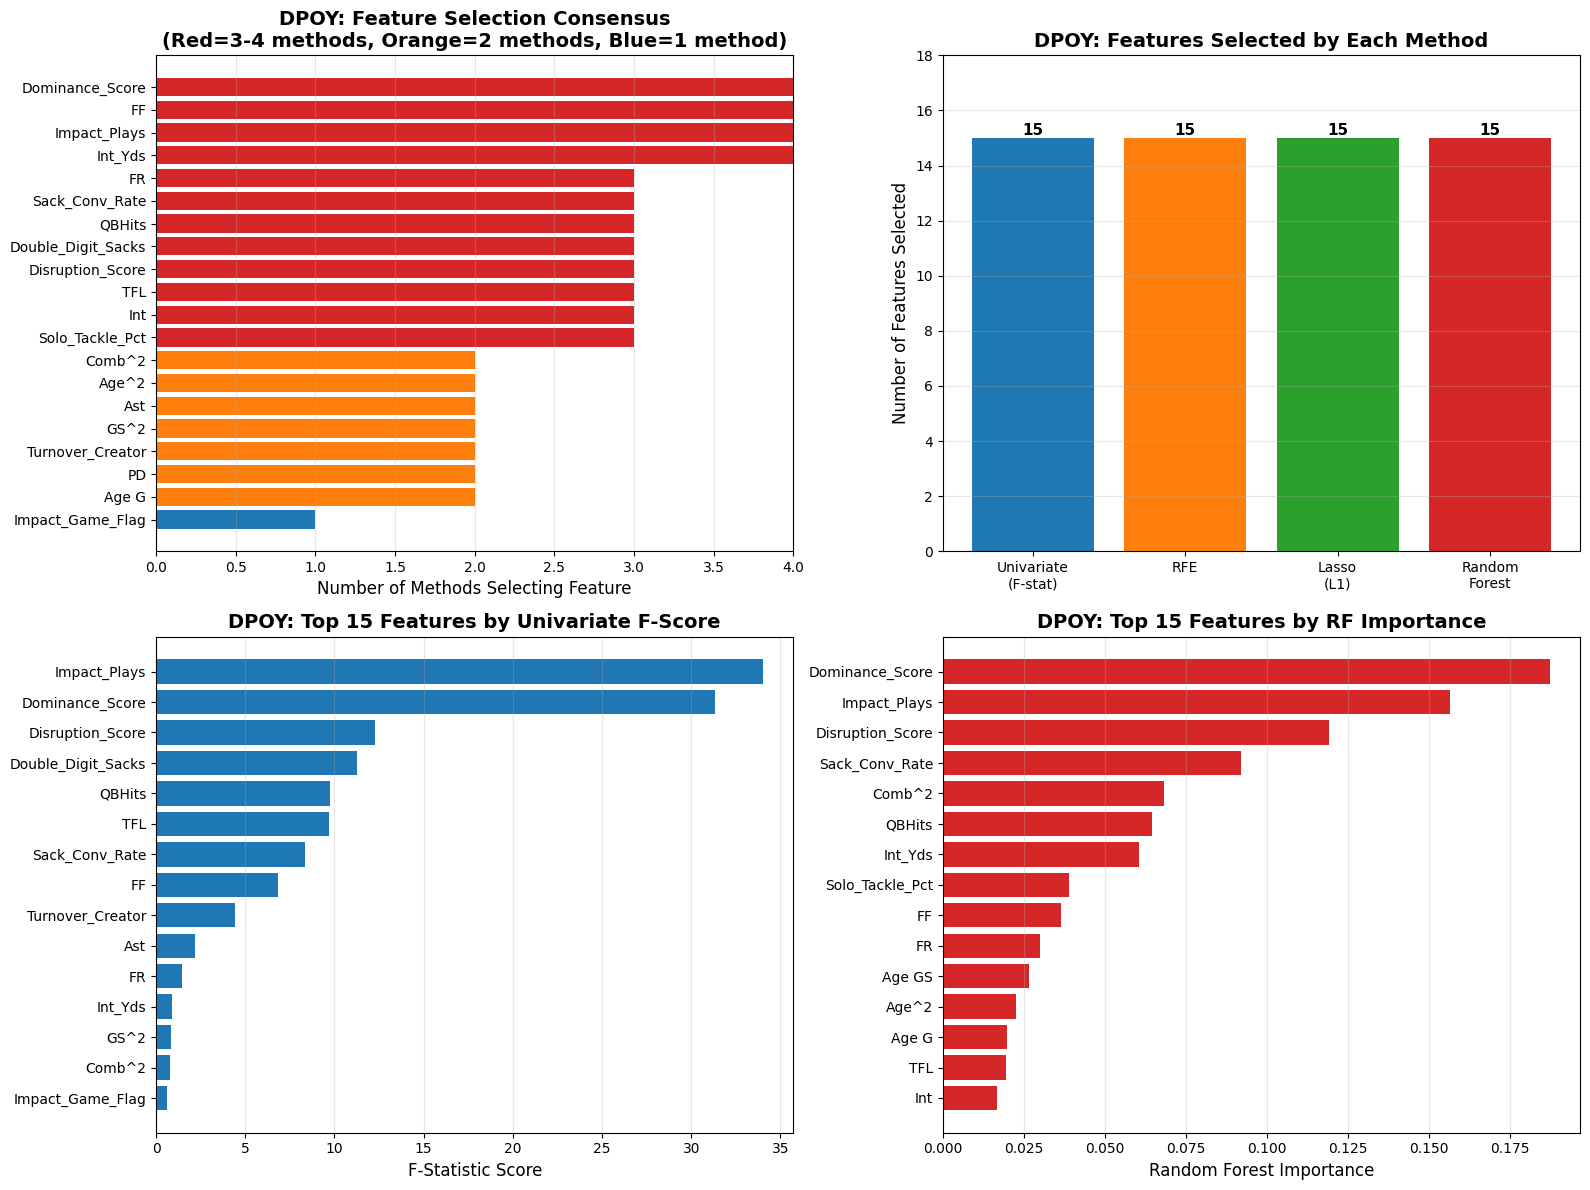


DPOY - Method Agreement Matrix


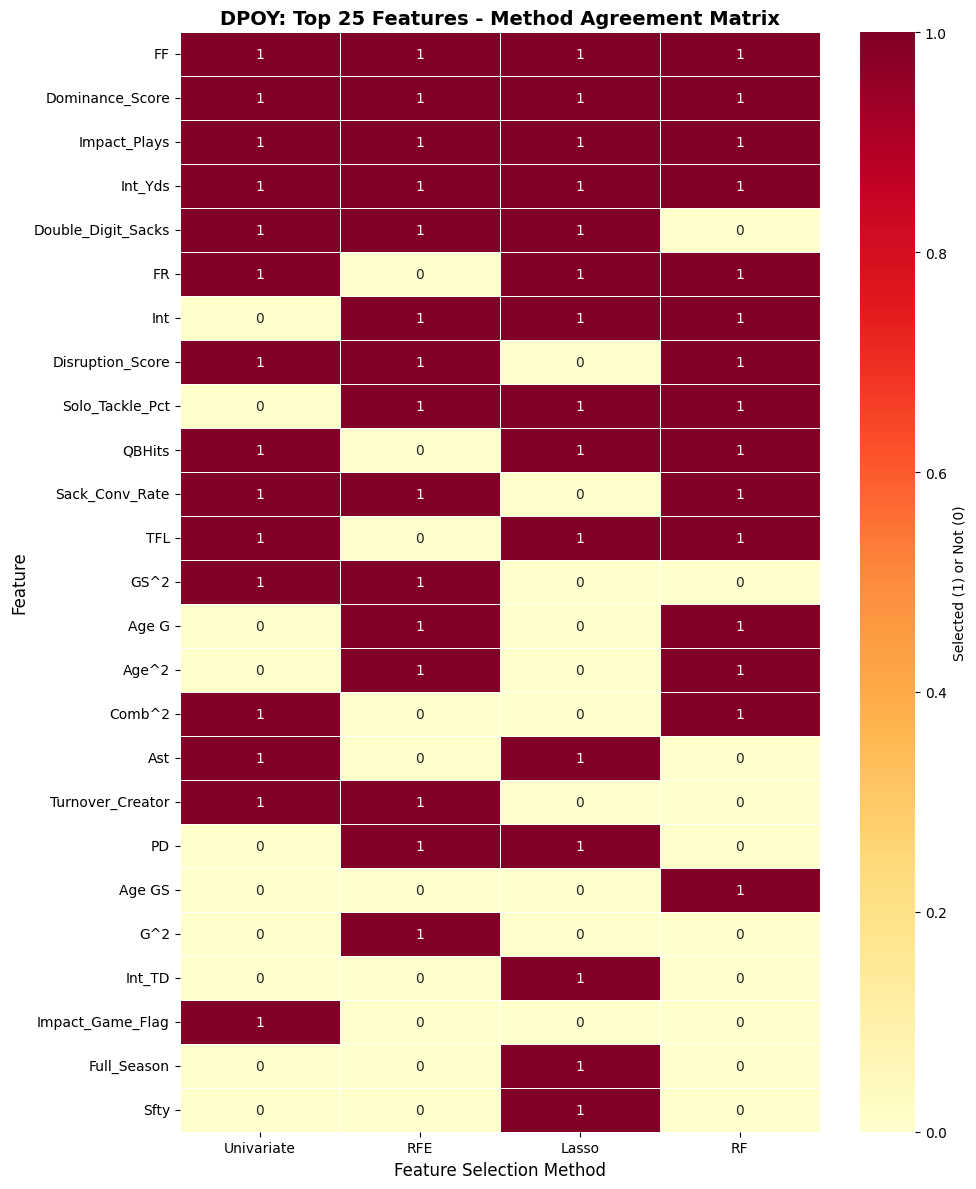

✓ Saved DPOY features to CSV


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded DPOY_features.csv


Processing OROY
Train samples: 143
Test samples:  36
Selected features (19):
  • 1000_Rec_Yards
  • 1000_Rush_Yards
  • GS Pass_Cmp
  • Likely_RB
  • PFR_Age GS
  • PFR_Age^2
  • Pass_Comp_Pct
  • Pass_Int
  • Pass_TD_INT_Ratio
  • Pass_YPA
  • Rec
  • Rec_YPR
  • Rush_TD
  • Rush_TD_Rate
  • Rush_YPC
  • Rush_Yds
  • Total_TD
  • Total_TDs
  • Total_Yards

Top 10 OROY features by consensus votes:
----------------------------------------------------------------------
  Pass_YPA                        |  4/4 methods
  Rush_Yds                        |  4/4 methods
  Total_Yards                     |  4/4 methods
  Total_TD                        |  4/4 methods
  Total_TDs                       |  3/4 methods
  PFR_Age GS                      |  3/4 methods
  PFR_Age^2                       |  3/4 methods
  Rush_TD                         |  3/4 methods
  Rush_YPC                        |  3/4 methods
  Rec                             |  3/4 methods

OROY

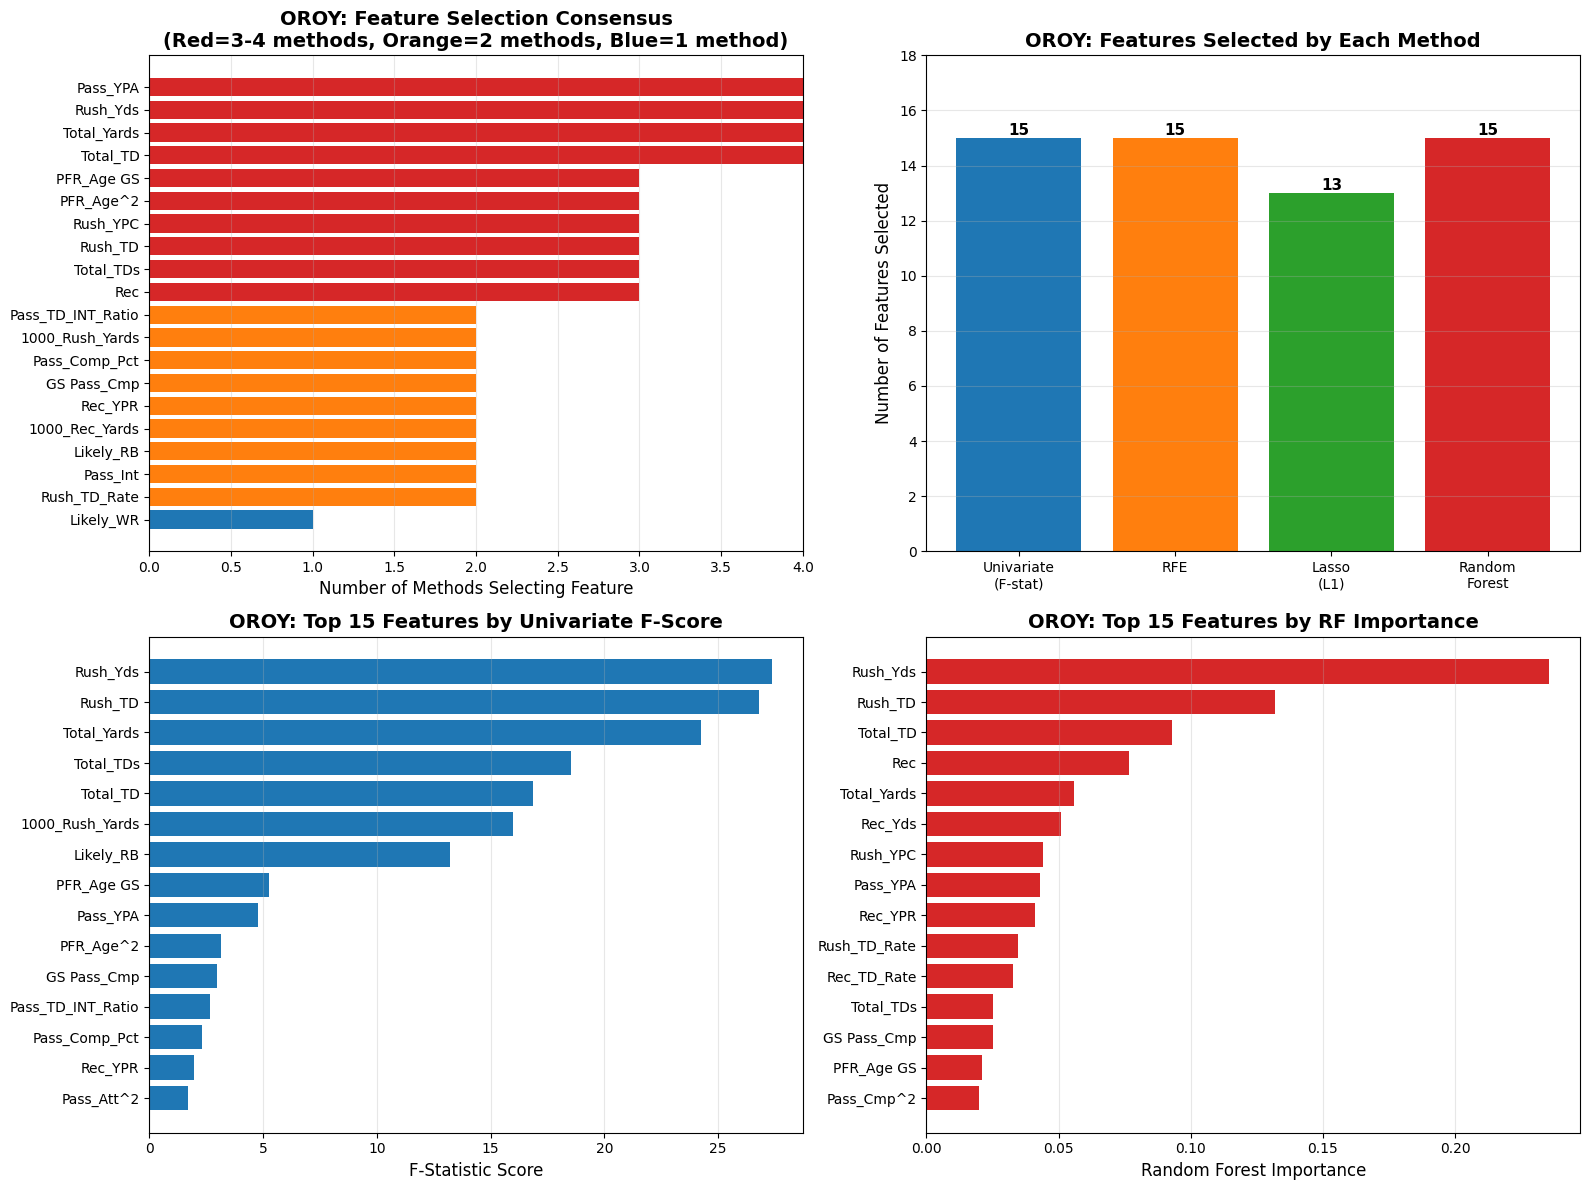


OROY - Method Agreement Matrix


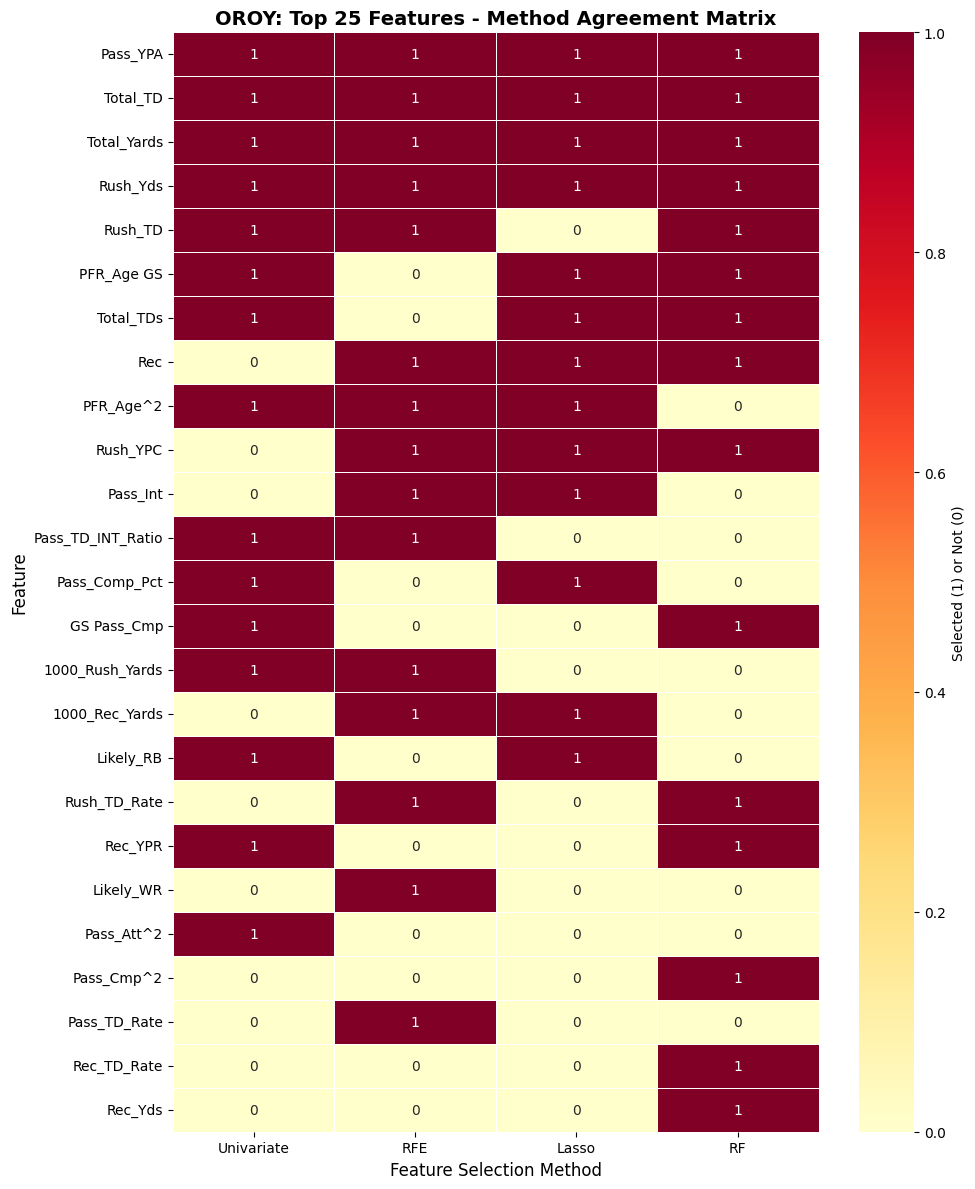

✓ Saved OROY features to CSV


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded OROY_features.csv


Processing DROY
Train samples: 172
Test samples:  44
Selected features (13):
  • Def_Comb Def_Ast
  • Def_Comb^2
  • Def_FF
  • Def_FR
  • Def_PD
  • Def_QBHits
  • Def_TFL
  • Disruption_Score
  • Full_Season
  • GS^2
  • G^2
  • Impact_Game_Flag
  • Solo_Tackle_Pct

Top 10 DROY features by consensus votes:
----------------------------------------------------------------------
  Disruption_Score                |  4/4 methods
  GS^2                            |  4/4 methods
  Def_QBHits                      |  4/4 methods
  Def_Comb^2                      |  4/4 methods
  Def_FR                          |  4/4 methods
  Def_TFL                         |  4/4 methods
  Def_Comb Def_Ast                |  3/4 methods
  Def_PD                          |  3/4 methods
  Impact_Game_Flag                |  3/4 methods
  Def_FF                          |  3/4 methods

DROY Feature Selection Results
  Selected features: 13
  Training samples: 172
  Test samples: 

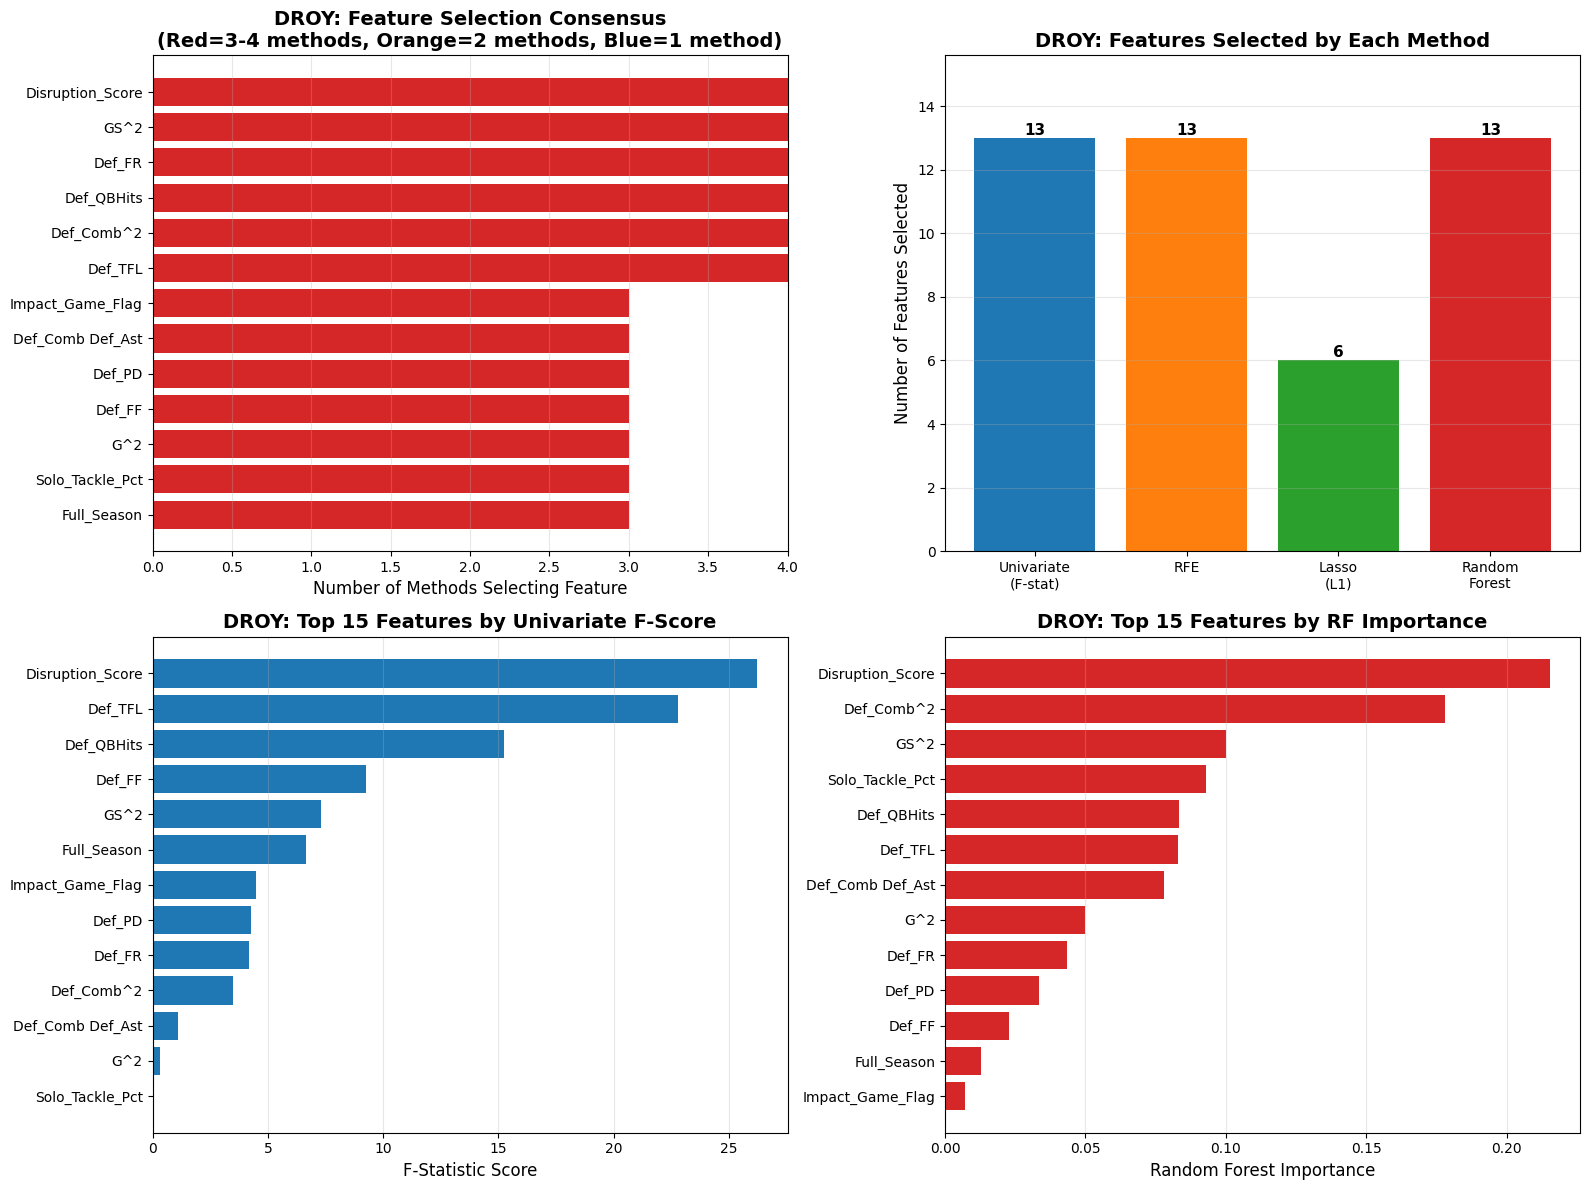


DROY - Method Agreement Matrix


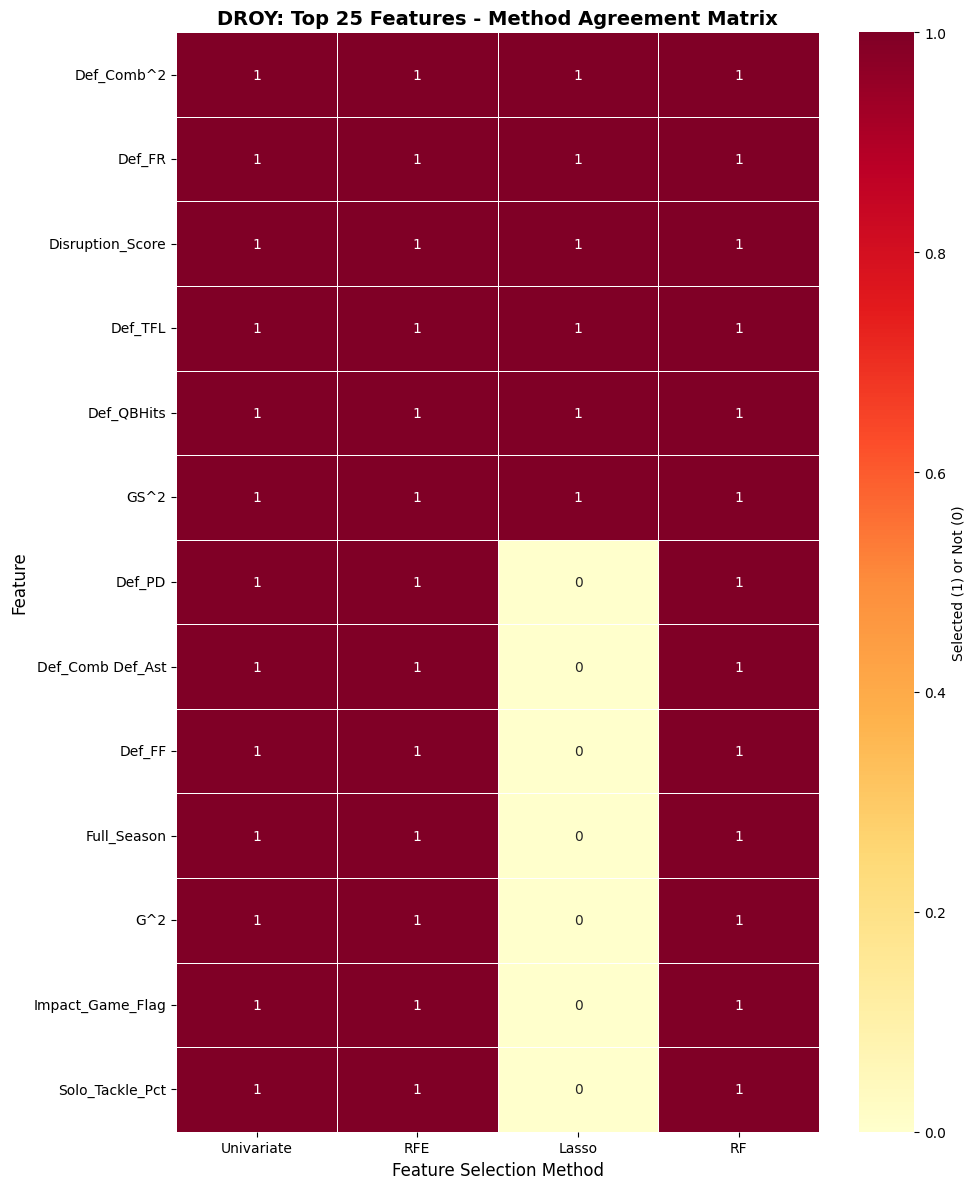

✓ Saved DROY features to CSV


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded DROY_features.csv



In [38]:
import pandas as pd
from google.colab import files
from pathlib import Path

# Create output directory
output_dir = Path("modeling_results")
output_dir.mkdir(exist_ok=True)

# List of awards to process
awards = ['MVP', 'OPOY', 'DPOY', 'OROY', 'DROY']

for award_name in awards:
    print(f"\n{'='*70}")
    print(f"Processing {award_name}")
    print('='*70)

    # Check if award exists in modeling_data
    if award_name not in modeling_data:
        raise KeyError(f"{award_name} results not found in modeling_data.")

    result = modeling_data[award_name]

    # Print summary
    print(f"Train samples: {len(result['X_train'])}")
    print(f"Test samples:  {len(result['X_test'])}")
    print(f"Selected features ({len(result['selected_features'])}):")
    for f in result['selected_features']:
        print(f"  • {f}")

    print(f"\nTop 10 {award_name} features by consensus votes:")
    print("-" * 70)
    for feature, votes in sorted(result['feature_votes'].items(),
                                 key=lambda x: x[1],
                                 reverse=True)[:10]:
        print(f"  {feature:30}  |  {votes}/4 methods")

    # Visualize
    visualize_feature_selection(result, award_name)

    # Create CSV with feature votes
    feature_votes_df = pd.DataFrame([
        {'feature': feature, 'votes': votes, 'selected': feature in result['selected_features']}
        for feature, votes in sorted(result['feature_votes'].items(),
                                     key=lambda x: x[1],
                                     reverse=True)
    ])

    csv_filename = output_dir / f"{award_name}_features.csv"
    feature_votes_df.to_csv(csv_filename, index=False)

    print(f"✓ Saved {award_name} features to CSV")

    # Download immediately
    files.download(str(csv_filename))
    print(f"✓ Downloaded {award_name}_features.csv\n")

# Baseline Algorithm Testing

In [31]:
# rf_dict = {} # This line is not needed here

def train_random_forests(data):
  trained_models = {} # Use a local dictionary to store models
  for award_name in data.keys():
    X_train, X_test, y_train, y_test = modeling_data[award_name]['X_train'], modeling_data[award_name]['X_test'], modeling_data[award_name]['y_train'], modeling_data[award_name]['y_test']
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=3540)
    rf.fit(X_train, y_train)
    modeling_data[award_name]['model'] = rf # Store the model in modeling_data
    trained_models[award_name] = rf # Also store in the local dictionary to return
    y_pred = rf.predict(X_test)
    accuracy = rf.score(X_test, y_test)
    print(f"Award: {award_name}, Score: {accuracy}")
  return trained_models # Return the dictionary of models


trained_rf_models = train_random_forests(modeling_data) # Assign the returned dictionary

Award: MVP, Score: 0.3396014680005732
Award: OPOY, Score: 0.1848085802385261
Award: DPOY, Score: 0.30415063490141236
Award: OROY, Score: 0.31778300052140696
Award: DROY, Score: -0.2580842180719676


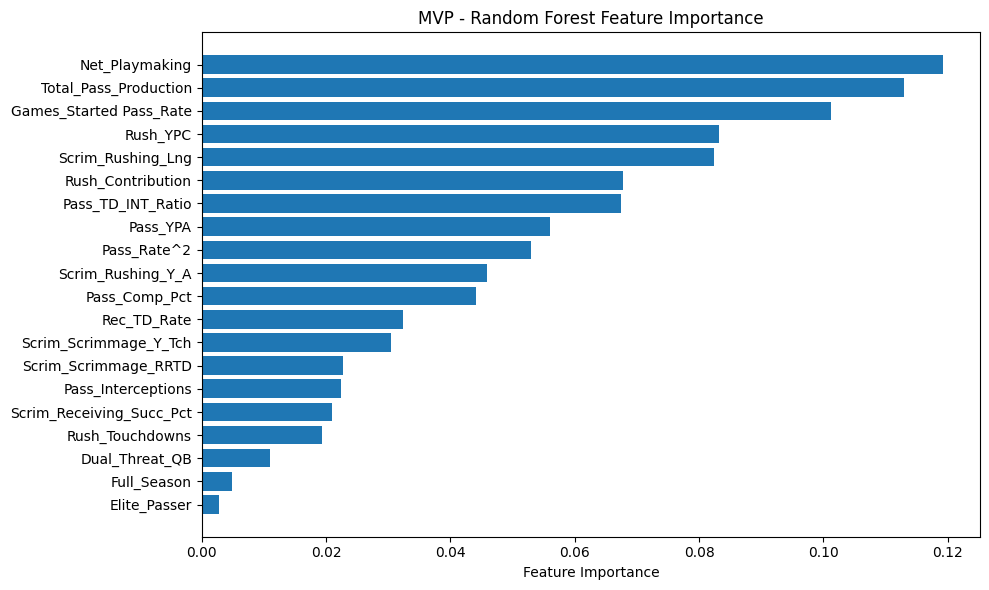

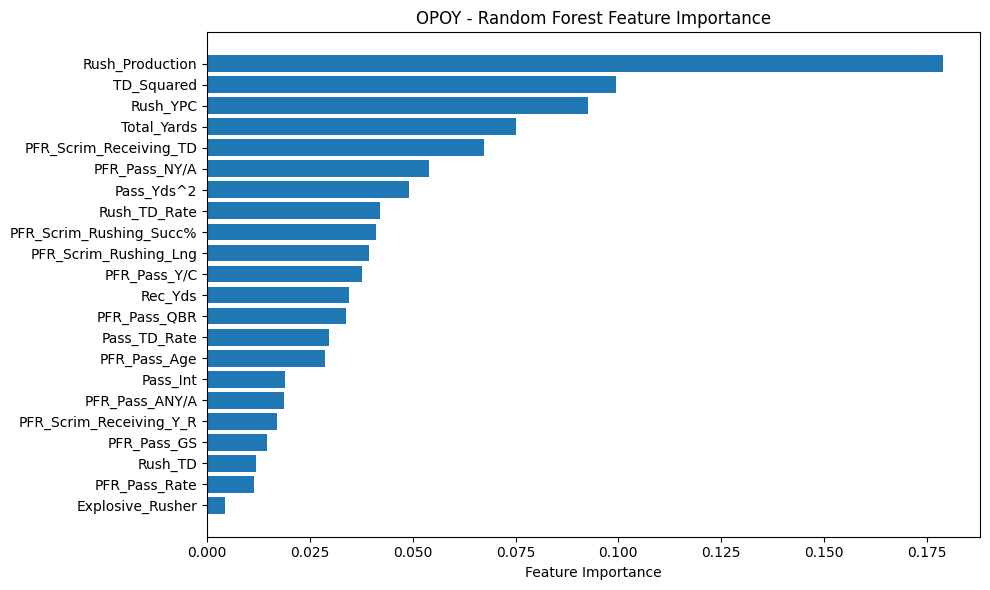

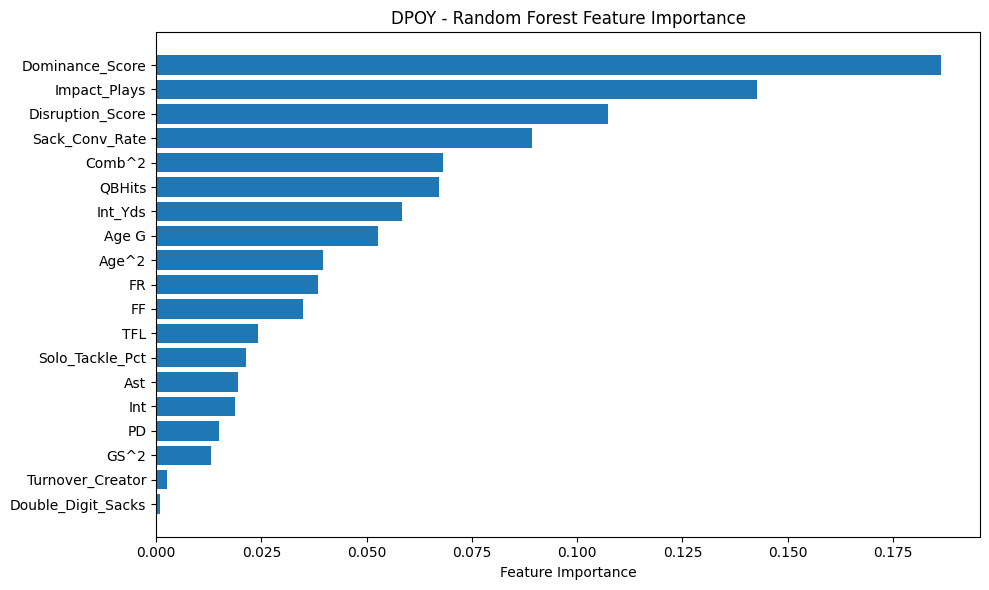

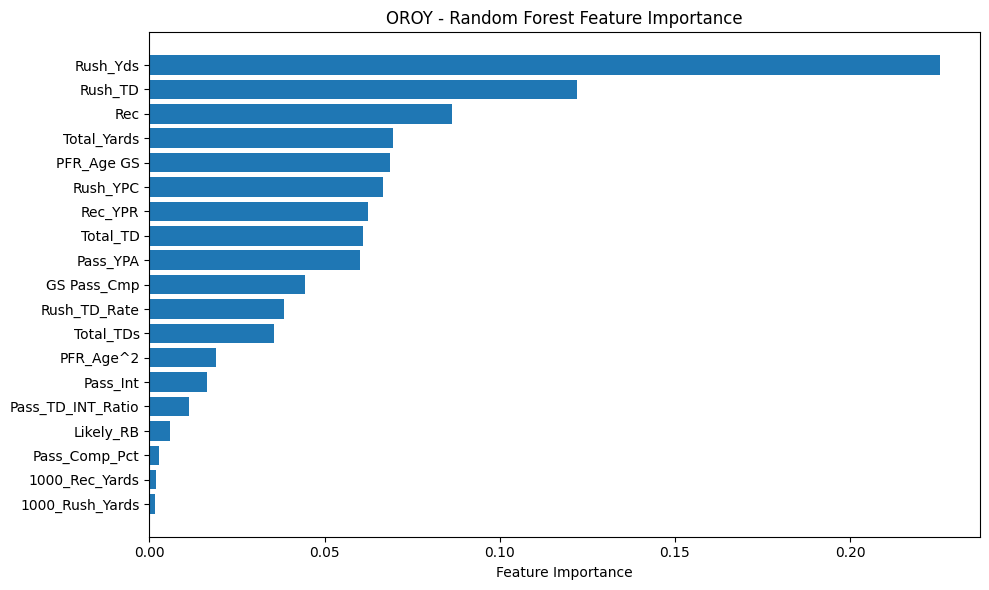

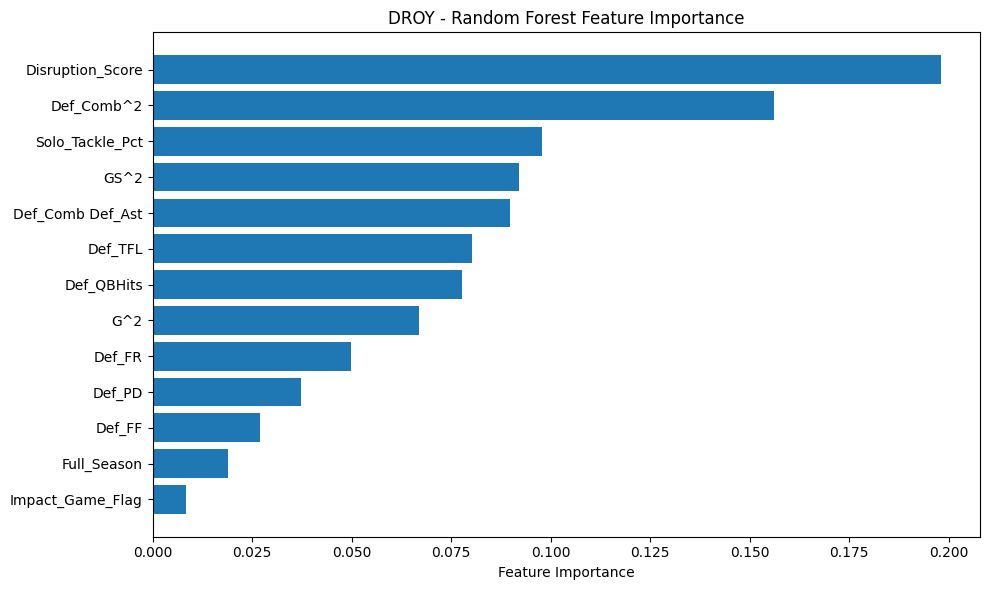

In [32]:
# fig, axes = plt.subplots(1, len(rf_dict), figsize=(15, 5), sharey=True) # This line is not needed here

# Visualize feature importances for each model
for award_name, model in trained_rf_models.items(): # Iterate through the returned dictionary
    plt.figure(figsize=(10, 6))
    # Get feature names from modeling_data for the specific award
    feature_names = modeling_data[award_name]['selected_features']
    importances = model.feature_importances_
    # Sort features by importance
    sorted_indices = importances.argsort()
    plt.barh([feature_names[i] for i in sorted_indices], importances[sorted_indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{award_name} - Random Forest Feature Importance")
    plt.tight_layout()
    plt.show()

# Hyperparameter tuning

In [33]:
from enum import verify
def evaluate_baseline_models(X_train, X_test, y_train, y_test, award_name, classification = False):
    """Quick baseline evaluation of multiple models with default parameters."""
    print(f"Baseline Model Comparison: {award_name}")
    print(f"{'='*70}")

    if classification:
      models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(class_weight='balanced'),
        "Gradient Boosting": GradientBoostingClassifier(),
        "XGBoost": xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=(y_test == 0).sum() / (y_test == 1).sum()),
        'Neural Network': MLPClassifier(random_state=3540, max_iter=1000)
      }
    else:
      models = {
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet': ElasticNet(),
          'Random Forest': RandomForestRegressor(random_state=3540),
          'Gradient Boosting': GradientBoostingRegressor(random_state=3540),
          'XGBoost': xgb.XGBRegressor(random_state=3540, verbosity=0),
          'SVR (RBF)': SVR(),
          'Neural Network': MLPRegressor(random_state=3540, max_iter=1000)
      }

    results = []

    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            if classification:
              probs = model.predict_proba(X_test)[:,1]
              train_accuracy = accuracy_score(y_train, y_train_pred)
              test_accuracy = accuracy_score(y_test, y_test_pred)
              precision = precision_score(y_test, y_test_pred)
              recall = recall_score(y_test, y_test_pred)
              f1 = f1_score(y_test, y_test_pred)
              roc_auc = roc_auc_score(y_test, probs)

              cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                          scoring='roc_auc', n_jobs=-1)
              cv_mean = cv_scores.mean()
              cv_std = cv_scores.std()

              results.append({
                  'Model': name,
                  'Train_Accuracy': train_accuracy,
                  'Test_Accuracy': test_accuracy,
                  'Precision': precision,
                  'Recall': recall,
                  'F1_Score': f1,
                  'ROC_AUC': roc_auc,
                  'CV_ROC_AUC_Mean': cv_mean,
                  'CV_ROC_AUC_Std': cv_std,
                  'Overfit': train_accuracy - test_accuracy
              })

            else:
              train_r2 = r2_score(y_train, y_train_pred)
              test_r2 = r2_score(y_test, y_test_pred)
              train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
              test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
              train_mae = mean_absolute_error(y_train, y_train_pred)
              test_mae = mean_absolute_error(y_test, y_test_pred)

              cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                          scoring='r2', n_jobs=-1)
              cv_mean = cv_scores.mean()
              cv_std = cv_scores.std()

              results.append({
                  'Model': name,
                  'Train_R2': train_r2,
                  'Test_R2': test_r2,
                  'Train_RMSE': train_rmse,
                  'Test_RMSE': test_rmse,
                  'Train_MAE': train_mae,
                  'Test_MAE': test_mae,
                  'CV_R2_Mean': cv_mean,
                  'CV_R2_Std': cv_std,
                  'Overfit': train_r2 - test_r2
              })
        except Exception as e:
            print(f"    Warning: {name} failed - {str(e)}")

    results_df = pd.DataFrame(results)
    if classification:
      results_df = results_df.sort_values('CV_ROC_AUC_Mean', ascending=False)
      print("\nBaseline Results (sorted by CV ROC-AUC Mean):")
    else:
      results_df = results_df.sort_values('Test_R2', ascending=False)
      print("\nBaseline Results (sorted by Test R²):")
    print(results_df.to_string(index=False))
    print(f"\n{'='*70}\n")
    return results_df


def tune_ridge_lasso_elasticnet(X_train, y_train, award_name):
    """Tune linear models with regularization."""
    print(f"Tuning linear models (Ridge/Lasso/ElasticNet): {award_name}")
    print(f"{'='*70}")

    ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2', n_jobs=-1, verbose=0)
    ridge_grid.fit(X_train, y_train)
    print(f"\n  Ridge - Best params: {ridge_grid.best_params_}, Best CV R²: {ridge_grid.best_score_:.4f}")

    lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring='r2', n_jobs=-1, verbose=0)
    lasso_grid.fit(X_train, y_train)
    print(f"  Lasso - Best params: {lasso_grid.best_params_}, Best CV R²: {lasso_grid.best_score_:.4f}")

    elasticnet_params = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
    elasticnet_grid = GridSearchCV(ElasticNet(max_iter=10000), elasticnet_params, cv=5, scoring='r2', n_jobs=-1, verbose=0)
    elasticnet_grid.fit(X_train, y_train)
    print(f"  ElasticNet - Best params: {elasticnet_grid.best_params_}, Best CV R²: {elasticnet_grid.best_score_:.4f}")
    print(f"\n{'='*70}\n")

    return {'ridge': ridge_grid, 'lasso': lasso_grid, 'elasticnet': elasticnet_grid}


def tune_random_forest(X_train, y_train, award_name, classification=False):
    """Tune Random Forest with RandomizedSearchCV."""
    print(f"Tuning Random Forest: {award_name}")
    print(f"{'='*70}")

    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [2, 4, 8],
        'max_features': ['sqrt', 'log2']
    }
    if classification:
      rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=3540), rf_params, n_iter=50, cv=5,
                                    scoring='roc_auc', n_jobs=-1, verbose=1, random_state=3540)
    else:
      rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=3540), rf_params, n_iter=50, cv=5,
                                    scoring='r2', n_jobs=-1, verbose=1, random_state=3540)
    rf_random.fit(X_train, y_train)
    print(f"\n  Best params: {rf_random.best_params_}")
    if classification:
      print(f"  Best CV ROC-AUC: {rf_random.best_score_:.4f}")
    else:
      print(f"  Best CV R²: {rf_random.best_score_:.4f}")
    print(f"\n{'='*70}\n")
    return rf_random


def tune_gradient_boosting(X_train, y_train, award_name, classification=False):
    """Tune Gradient Boosting."""
    print(f"Tuning Gradient Boosting: {award_name}")
    print(f"{'='*70}")

    gb_params = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]
    }
    if classification:
      gb_random = RandomizedSearchCV(GradientBoostingClassifier(random_state=3540), gb_params, n_iter=50, cv=5,
                                     scoring='roc_auc', n_jobs=-1, verbose=1, random_state=3540)
    else:
      gb_random = RandomizedSearchCV(GradientBoostingRegressor(random_state=3540), gb_params, n_iter=50, cv=5,
                                    scoring='r2', n_jobs=-1, verbose=1, random_state=3540)
    gb_random.fit(X_train, y_train)
    print(f"\n  Best params: {gb_random.best_params_}")
    if classification:
      print(f"  Best CV ROC-AUC: {gb_random.best_score_:.4f}")
    else:
      print(f"  Best CV R²: {gb_random.best_score_:.4f}")
    print(f"\n{'='*70}\n")
    return gb_random


def tune_xgboost(X_train, y_train, award_name, classification=False):
    """Tune XGBoost."""
    print(f"Tuning XGBoost: {award_name}")
    print(f"{'='*70}")

    xgb_params = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2]
    }

    if classification:
      xgb_random = RandomizedSearchCV(xgb.XGBClassifier(random_state=3540, verbosity=0), xgb_params, n_iter=50, cv=5,
                                      scoring='roc_auc', n_jobs=-1, verbose=1, random_state=3540)
    else:
      xgb_random = RandomizedSearchCV(xgb.XGBRegressor(random_state=3540, verbosity=0), xgb_params, n_iter=50, cv=5,
                                      scoring='r2', n_jobs=-1, verbose=1, random_state=3540)
    xgb_random.fit(X_train, y_train)
    print(f"\n  Best params: {xgb_random.best_params_}")
    if classification:
      print(f"  Best CV ROC-AUC: {xgb_random.best_score_:.4f}")
    else:
      print(f"  Best CV R²: {xgb_random.best_score_:.4f}")
    print(f"\n{'='*70}\n")
    return xgb_random


def tune_svr(X_train, y_train, award_name):
    """Tune SVR."""
    print(f"Tuning SVR: {award_name}")
    print(f"{'='*70}")
    print("  WARNING: SVR can be very slow on datasets > 150 samples\n")

    svr_params = {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.2], 'kernel': ['rbf'], 'gamma': ['scale']}
    svr_random = RandomizedSearchCV(SVR(), svr_params, n_iter=20, cv=5, scoring='r2', n_jobs=-1, verbose=1, random_state=3540)
    svr_random.fit(X_train, y_train)
    print(f"\n  Best params: {svr_random.best_params_}")
    print(f"  Best CV R²: {svr_random.best_score_:.4f}")
    print(f"\n{'='*70}\n")
    return svr_random


def tune_neural_network(X_train, y_train, award_name, classification = False):
    """Tune Neural Network."""
    print(f"Tuning Neural Network: {award_name}")
    print(f"{'='*70}")

    nn_params = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [2000]
    }

    if classification:
      nn_random = RandomizedSearchCV(MLPClassifier(random_state=3540, early_stopping=True, validation_fraction=0.15),
                                    nn_params, n_iter=30, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=3540)
    else:
      nn_random = RandomizedSearchCV(MLPRegressor(random_state=3540, early_stopping=True, validation_fraction=0.15),
                                    nn_params, n_iter=30, cv=5, scoring='r2', n_jobs=-1, verbose=1, random_state=3540)
    nn_random.fit(X_train, y_train)
    print(f"\n  Best params: {nn_random.best_params_}")
    if classification:
      print(f"  Best CV ROC-AUC: {nn_random.best_score_:.4f}")
    else:
      print(f"  Best CV R²: {nn_random.best_score_:.4f}")
    print(f"\n{'='*70}\n")
    return nn_random

def tune_logistic_regression(X_train, y_train, award_name):
  """Tune Logistic Regression"""
  print(f"Tuning Logistic Regression: {award_name}")
  print(f"{'='*70}")

  log_reg_params = {
      'C': [0.001, 0.01, 0.1, 1],
      'penalty': ['l1', 'l2', 'elasticnet']
  }

  log_reg_random = RandomizedSearchCV(LogisticRegression(max_iter=2000, class_weight='balanced'),
                                    log_reg_params, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=3540)
  log_reg_random.fit(X_train, y_train)
  print(f"\n  Best params: {log_reg_random.best_params_}")
  print(f"  Best CV ROC-AUC: {log_reg_random.best_score_:.4f}")
  return log_reg_random

def evaluate_tuned_models(tuned_models, X_train, X_test, y_train, y_test, award_name, classification=False):
    """Compare all tuned models on the test set."""
    print(f"Final model comparison (tuned): {award_name}")
    print(f"{'='*70}")

    results = []

    # for model_name, model in tuned_models.items():
    #     try:
    #         best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    #         y_train_pred = best_model.predict(X_train)
    #         y_test_pred = best_model.predict(X_test)

    #         train_r2 = r2_score(y_train, y_train_pred)
    #         test_r2 = r2_score(y_test, y_test_pred)
    #         train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    #         test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    #         train_mae = mean_absolute_error(y_train, y_train_pred)
    #         test_mae = mean_absolute_error(y_test, y_test_pred)

    #         results.append({
    #             'Model': model_name,
    #             'Train_R2': train_r2,
    #             'Test_R2': test_r2,
    #             'Train_RMSE': train_rmse,
    #             'Test_RMSE': test_rmse,
    #             'Train_MAE': train_mae,
    #             'Test_MAE': test_mae,
    #             'Overfit': train_r2 - test_r2
    #         })
    #     except Exception as e:
    #         print(f"    Warning: {model_name} evaluation failed - {str(e)}")

    for model_name, model in tuned_models.items():
      try:
          best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
          y_train_pred = best_model.predict(X_train)
          y_test_pred = best_model.predict(X_test)

          if classification:
            probs = best_model.predict_proba(X_test)[:,1]
            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            precision = precision_score(y_test, y_test_pred)
            recall = recall_score(y_test, y_test_pred)
            f1 = f1_score(y_test, y_test_pred)
            roc_auc = roc_auc_score(y_test, probs)

            results.append({
                'Model': model_name,
                'Train_Accuracy': train_accuracy,
                'Test_Accuracy': test_accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1,
                'ROC_AUC': roc_auc,
                'Overfit': train_accuracy - test_accuracy
            })

          else:
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            train_mae = mean_absolute_error(y_train, y_train_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)

            results.append({
                'Model': model_name,
                'Train_R2': train_r2,
                'Test_R2': test_r2,
                'Train_RMSE': train_rmse,
                'Test_RMSE': test_rmse,
                'Train_MAE': train_mae,
                'Test_MAE': test_mae,
                'Overfit': train_r2 - test_r2
            })
      except Exception as e:
          print(f"    Warning: {model_name} evaluation failed - {str(e)}")

    results_df = pd.DataFrame(results)
    if classification:
      results_df = results_df.sort_values('ROC_AUC', ascending=False)
      print("\nTuned Model Results (sorted by ROC-AUC):")
      print(results_df.to_string(index=False))

      if len(results_df) > 0:
        best_model_name = results_df.iloc[0]['Model']
        best_test_roc_auc = results_df.iloc[0]['ROC_AUC']
        print(f"\nBest model: {best_model_name} (ROC-AUC = {best_test_roc_auc:.4f})")
      else:
        best_model_name = None
        print("\nNo models successfully evaluated!")
    else:
      results_df = results_df.sort_values('Test_R2', ascending=False)
      print("\nTuned Model Results (sorted by Test R²):")
      print(results_df.to_string(index=False))

      if len(results_df) > 0:
        best_model_name = results_df.iloc[0]['Model']
        best_test_r2 = results_df.iloc[0]['Test_R2']
        print(f"\nBest model: {best_model_name} (Test R² = {best_test_r2:.4f})")
      else:
        best_model_name = None
        print("\nNo models successfully evaluated!")

    print(f"\n{'='*70}\n")
    return results_df, best_model_name


def tune_single_award(award_name, data, include_slow_models=False, classification=False):
    """Complete tuning pipeline for a single award."""
    print(f"\n{'#'*70}")
    print(f"# Processing: {award_name}")
    print(f"{'#'*70}\n")

    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    print(f"Dataset info:")
    print(f"  Train samples: {len(X_train)}")
    print(f"  Test samples: {len(X_test)}")
    print(f"  Features: {X_train.shape[1]}\n")

    baseline_results = evaluate_baseline_models(X_train, X_test, y_train, y_test, award_name, classification)

    tuned_models = {}
    linear_models = tune_ridge_lasso_elasticnet(X_train, y_train, award_name)
    tuned_models.update(linear_models)

    tuned_models['random_forest'] = tune_random_forest(X_train, y_train, award_name, classification)
    tuned_models['gradient_boosting'] = tune_gradient_boosting(X_train, y_train, award_name, classification)
    tuned_models['xgboost'] = tune_xgboost(X_train, y_train, award_name, classification)

    if include_slow_models:
        print("\n Including slow models (SVR & Neural Network)...")
        print("    This may take 10-30 minutes depending on dataset size.\n")
        tuned_models['svr'] = tune_svr(X_train, y_train, award_name)
        tuned_models['neural_network'] = tune_neural_network(X_train, y_train, award_name, classification)

    final_results, best_model_name = evaluate_tuned_models(
        tuned_models, X_train, X_test, y_train, y_test, award_name, classification
    )

    return {
        'baseline_results': baseline_results,
        'tuned_models': tuned_models,
        'final_results': final_results,
        'best_model_name': best_model_name,
        'best_model': tuned_models.get(best_model_name) if best_model_name else None
    }

def diagnose_model_performance(award_name, data, results, classification=False):
    """Diagnostic function to analyze model performance on test set."""
    print(f"\n{'='*70}")
    print(f"DIAGNOSTIC ANALYSIS: {award_name}")
    print(f"{'='*70}")

    X_test = data['X_test']
    y_test = data['y_test']

    if 'ensemble' in results:
        best_model = results['ensemble']
        model_name = "Ensemble"
    elif results['best_model']:
        best_model = results['best_model'].best_estimator_
        model_name = results['best_model_name']
    else:
        print("No model available for diagnosis")
        return

    y_pred = best_model.predict(X_test)
    if classification:
      probs = best_model.predict_proba(X_test)[:,1]
      roc_auc = roc_auc_score(y_test, probs)
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)
    else:
      r2 = r2_score(y_test, y_pred)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      mae = mean_absolute_error(y_test, y_pred)
      residuals = y_test - y_pred

      print(f"\nModel: {model_name}")
      print(f"Samples: {len(y_test)}")
      print(f"\nPerformance Metrics:")
      print(f"  R² Score:     {r2:.4f}")
      print(f"  RMSE:         {rmse:.4f}")
      print(f"  MAE:          {mae:.4f}")
      print(f"\nResidual Analysis:")
      print(f"  Mean residual:   {residuals.mean():.4f} (ideally ~0)")
      print(f"  Std dev:         {residuals.std():.4f}")
      print(f"  Min residual:    {residuals.min():.4f}")
      print(f"  Max residual:    {residuals.max():.4f}")

      fig, axes = plt.subplots(2, 2, figsize=(14, 10))

      axes[0, 0].scatter(y_test, y_pred, alpha=0.6)
      axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
      axes[0, 0].set_xlabel('Actual Votes')
      axes[0, 0].set_ylabel('Predicted Votes')
      axes[0, 0].set_title(f'{award_name}: Actual vs Predicted')
      axes[0, 0].grid(alpha=0.3)

      axes[0, 1].scatter(y_pred, residuals, alpha=0.6)
      axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
      axes[0, 1].set_xlabel('Predicted Votes')
      axes[0, 1].set_ylabel('Residuals')
      axes[0, 1].set_title(f'{award_name}: Residual Plot')
      axes[0, 1].grid(alpha=0.3)

      axes[1, 0].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
      axes[1, 0].set_xlabel('Residuals')
      axes[1, 0].set_ylabel('Frequency')
      axes[1, 0].set_title(f'{award_name}: Residual Distribution')
      axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
      axes[1, 0].grid(alpha=0.3)

      from scipy import stats
      stats.probplot(residuals, dist="norm", plot=axes[1, 1])
      axes[1, 1].set_title(f'{award_name}: Q-Q Plot')
      axes[1, 1].grid(alpha=0.3)

      plt.tight_layout()
      plt.show()
      print(f"\n{'='*70}\n")


def create_ensemble(award_name, modeling_data, all_results, ensemble_config, classification=False):
    """Generic ensemble creation function"""
    print("\n" + "="*70)
    print(f"CREATING {award_name} ENSEMBLE")
    print("="*70)

    X_train = modeling_data[award_name]['X_train']
    X_test = modeling_data[award_name]['X_test']
    y_train = modeling_data[award_name]['y_train']
    y_test = modeling_data[award_name]['y_test']

    ensemble = VotingRegressor(ensemble_config['models'], weights=ensemble_config['weights'])

    print("Training ensemble...")
    ensemble.fit(X_train, y_train)

    y_train_pred = ensemble.predict(X_train)
    y_test_pred = ensemble.predict(X_test)

    if classification:
      probs = ensemble.predict_proba(X_test)[:,1]
      train_accuracy = accuracy_score(y_train, y_train_pred)
      test_accuracy = accuracy_score(y_test, y_test_pred)
      precision = precision_score(y_test, y_test_pred)
      recall = recall_score(y_test, y_test_pred)
      f1 = f1_score(y_test, y_test_pred)
      roc_auc = roc_auc_score(y_test, probs)

      print(f"\nENSEMBLE RESULTS - {award_name}")
      print("-" * 70)
      print(f"Train Accuracy: {train_accuracy:.4f}")
      print(f"Test Accuracy:  {test_accuracy:.4f}")
      print(f"Precision:      {precision:.4f}")
      print(f"Recall:         {recall:.4f}")
      print(f"F1 Score:       {f1:.4f}")
      print(f"ROC-AUC:        {roc_auc:.4f}")
      print(f"Overfit:        {train_accuracy - test_accuracy:.4f}")

      best_single = all_results[award_name]['final_results'].iloc[0]
      print(f"\nComparison:")
      print(f"  Best single model: {best_single['Model']} (ROC-AUC = {best_single['ROC_AUC']:.4f})")
      print(f"  Ensemble:          {ensemble_config['name']} (ROC-AUC = {roc_auc:.4f})")
      improvement = roc_auc - best_single['ROC_AUC']
      print(f"  Improvement:       {improvement:+.4f}")

      all_results[award_name]['ensemble'] = ensemble
      all_results[award_name]['ensemble_ROC_AUC'] = roc_auc
    else:
      train_r2 = r2_score(y_train, y_train_pred)
      test_r2 = r2_score(y_test, y_test_pred)
      test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
      test_mae = mean_absolute_error(y_test, y_test_pred)

      print(f"\nENSEMBLE RESULTS - {award_name}")
      print("-" * 70)
      print(f"Train R²:  {train_r2:.4f}")
      print(f"Test R²:   {test_r2:.4f}")
      print(f"Test RMSE: {test_rmse:.4f}")
      print(f"Test MAE:  {test_mae:.4f}")
      print(f"Overfit:   {train_r2 - test_r2:.4f}")

      best_single = all_results[award_name]['final_results'].iloc[0]
      print(f"\nComparison:")
      print(f"  Best single model: {best_single['Model']} (R² = {best_single['Test_R2']:.4f})")
      print(f"  Ensemble:          {ensemble_config['name']} (R² = {test_r2:.4f})")
      improvement = test_r2 - best_single['Test_R2']
      print(f"  Improvement:       {improvement:+.4f}")

      all_results[award_name]['ensemble'] = ensemble
      all_results[award_name]['ensemble_test_r2'] = test_r2

    return ensemble

## MVP Model Tuning

In [34]:
if 'all_results' not in globals():
    all_results = {}

all_results['MVP'] = tune_single_award(
    'MVP',
    modeling_data['MVP'],
    include_slow_models=True
)

print(f"MVP complete! Best model: {all_results['MVP']['best_model_name']}")
diagnose_model_performance('MVP', modeling_data['MVP'], all_results['MVP'])


######################################################################
# Processing: MVP
######################################################################

Dataset info:
  Train samples: 180
  Test samples: 45
  Features: 20

Baseline Model Comparison: MVP

Baseline Results (sorted by Test R²):
            Model  Train_R2   Test_R2  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  CV_R2_Mean  CV_R2_Std   Overfit
       ElasticNet  0.293750  0.362899   17.319461  13.308388  12.414463 10.359519    0.192963   0.070430 -0.069149
 Lasso Regression  0.323490  0.355977   16.950878  13.380489  12.031296 10.172466    0.198337   0.066553 -0.032487
 Ridge Regression  0.371451  0.349075   16.338977  13.452001  11.346578  9.638424    0.169031   0.139176  0.022376
    Random Forest  0.884213  0.316998    7.012707  13.779471   4.722709  9.791961    0.224188   0.184681  0.567215
   Neural Network  0.582044  0.219243   13.323573  14.732604   8.512713 10.776040   -0.160253   0.458947  0.362801
Gradient

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
mvp_config = {
    'models': [
        ('rf', all_results['MVP']['tuned_models']['random_forest'].best_estimator_),
        ('neural_net', all_results['MVP']['tuned_models']['neural_network'].best_estimator_)
    ],
    'weights': [0.8, 1.2],   # favor neural network (best generalization)
    'name': 'RF + Neural Network'
}

mvp_ensemble = create_ensemble(
    'MVP',
    modeling_data,
    all_results,
    mvp_config
)

diagnose_model_performance(
    'MVP',
    modeling_data['MVP'],
    all_results['MVP']
)

## OPOY Model Tuning

In [ ]:
if 'all_results' not in globals():
    all_results = {}

all_results['OPOY'] = tune_single_award(
    'OPOY',
    modeling_data['OPOY'],
    include_slow_models=True
)

print(f"OPOY complete! Best model: {all_results['OPOY']['best_model_name']}")
diagnose_model_performance('OPOY', modeling_data['OPOY'], all_results['OPOY'])

In [ ]:
opoy_config = {
    'models': [
        ('rf',  all_results['OPOY']['tuned_models']['random_forest'].best_estimator_),
        ('xgb', all_results['OPOY']['tuned_models']['xgboost'].best_estimator_)
    ],
    'weights': [1.2, 1.0],   # favor Random Forest (best Test R²)
    'name': 'RF + XGBoost'
}

opoy_ensemble = create_ensemble(
    'OPOY',
    modeling_data,
    all_results,
    opoy_config
)

# Mark ensemble as best model for OPOY
all_results['OPOY']['best_model_name'] = opoy_config['name']
all_results['OPOY']['best_model'] = opoy_ensemble

# Diagnose the ensemble
diagnose_model_performance(
    'OPOY',
    modeling_data['OPOY'],
    all_results['OPOY']
)

## DPOY Model Tuning

In [ ]:
if 'all_results' not in globals():
    all_results = {}

all_results['DPOY'] = tune_single_award(
    'DPOY',
    modeling_data['DPOY'],
    include_slow_models=True
)

print(f"DPOY complete! Best model: {all_results['DPOY']['best_model_name']}")
diagnose_model_performance('DPOY', modeling_data['DPOY'], all_results['DPOY'])

In [ ]:
dpoy_config = {
    'models': [
        ('rf',  all_results['DPOY']['tuned_models']['random_forest'].best_estimator_),
        ('xgb', all_results['DPOY']['tuned_models']['xgboost'].best_estimator_)
    ],
    'weights': [1.3, 1.0],   # Slightly favor Random Forest (best Test R²)
    'name': 'RF + XGBoost'
}

dpoy_ensemble = create_ensemble(
    'DPOY',
    modeling_data,
    all_results,
    dpoy_config
)

diagnose_model_performance(
    'DPOY',
    modeling_data['DPOY'],
    all_results['DPOY']
)

## OROY Model Tuning

In [ ]:
if 'all_results' not in globals():
    all_results = {}

all_results['OROY'] = tune_single_award(
    'OROY',
    modeling_data['OROY'],
    include_slow_models=True
)

print(f"OROY complete! Best model: {all_results['OROY']['best_model_name']}")
diagnose_model_performance('OROY', modeling_data['OROY'], all_results['OROY'])

In [ ]:
oroy_config = {
    'models': [
        ('rf',  all_results['OROY']['tuned_models']['random_forest'].best_estimator_),
        ('xgb', all_results['OROY']['tuned_models']['xgboost'].best_estimator_)
    ],
    'weights': [1.3, 1.0],   # slightly favor Random Forest
    'name': 'RF + XGBoost'
}

oroy_ensemble = create_ensemble(
    'OROY',
    modeling_data,
    all_results,
    oroy_config
)

# Mark ensemble as best model for OROY
all_results['OROY']['best_model_name'] = oroy_config['name']
all_results['OROY']['best_model'] = oroy_ensemble

# Diagnose the ensemble
diagnose_model_performance(
    'OROY',
    modeling_data['OROY'],
    all_results['OROY']
)

## DROY Model Tuning

In [ ]:
# ---- Add position dummies + Front_Seven ONLY for DROY ----
droy_pos = pd.get_dummies(droy_df['Position'], prefix='pos')

# Align to the same rows used in prepared_data['DROY']['X']
droy_pos = droy_pos.loc[prepared_data['DROY']['X'].index]

# Add dummy columns
prepared_data['DROY']['X'] = pd.concat(
    [prepared_data['DROY']['X'], droy_pos],
    axis=1
)

# Define which positions count as front seven
front_seven_candidates = [
    c for c in droy_pos.columns
    if any(tag in c for tag in ['DE', 'DT', 'DL', 'LB', 'OLB', 'EDGE'])
]

prepared_data['DROY']['X']['Front_Seven'] = (
    prepared_data['DROY']['X'][front_seven_candidates].sum(axis=1) > 0
).astype(int)

# Remove duplicate column names in DROY features
prepared_data['DROY']['X'] = prepared_data['DROY']['X'].loc[:, ~prepared_data['DROY']['X'].columns.duplicated()]
prepared_data['DROY']['feature_names'] = list(prepared_data['DROY']['X'].columns)


In [ ]:

modeling_data = apply_full_feature_pipeline(prepared_data)

if 'all_results' not in globals():
    all_results = {}

all_results['DROY'] = tune_single_award(
    'DROY',
    modeling_data['DROY'],
    include_slow_models=True
)

print(f"DROY complete! Best model: {all_results['DROY']['best_model_name']}")
diagnose_model_performance('DROY', modeling_data['DROY'], all_results['DROY'])


DROY models trying to predict the number of votes were actually all worse than if we just predicted the average number of votes. Instead of number of votes, we decided to build a model to simply predict the probability of winning the DROY award.

In [ ]:
def train_droy_classifier(X, y):
    print("DROY Classification model (Winner vs Non-Winner)")

    # Binary target: 1 = winner, 0 = non-winner
    y_binary = y

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary,
        test_size=0.2,
        shuffle=True,
        random_state= 3540,
        stratify=y_binary
    )

    models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=(y_binary == 0).sum() / (y_binary == 1).sum())
    }


    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:,1]

        results[name] = {
            "Accuracy": accuracy_score(y_test, preds),
            "Precision": precision_score(y_test, preds),
            "Recall": recall_score(y_test, preds),
            "F1": f1_score(y_test, preds),
            "ROC-AUC": roc_auc_score(y_test, probs)
        }

    return results, models

In [ ]:
droy_df['Winner'] = (
    droy_df['Votes'] == droy_df.groupby('Year')['Votes'].transform('max')
).astype(int)

X_droy_full = pd.concat(
    [modeling_data['DROY']['X_train'], modeling_data['DROY']['X_test']],
    axis=0
)

y_droy_full = droy_df.loc[X_droy_full.index, 'Winner'].values

droy_results, droy_models = train_droy_classifier(X_droy_full, y_droy_full)

pd.DataFrame(droy_results).T


# Model Testing

We are interested in seeing who the models predict to be the winner of each award every year.

In [ ]:
def predict_votes(award_name, modeling_data, all_results):
    print(f"\n{'='*70}")
    print(f"GENERATING VOTE PREDICTIONS FOR {award_name}")
    print(f"{'='*70}")

    if award_name not in modeling_data or award_name not in all_results:
        print(f"Error: Data or results for {award_name} not found.")
        return None

    # Combine training and testing data for full prediction
    X_full_scaled = pd.concat([modeling_data[award_name]['X_train'], modeling_data[award_name]['X_test']], axis=0)

    # Convert y_train and y_test to pandas Series before concatenating
    y_train_series = pd.Series(modeling_data[award_name]['y_train'], index=modeling_data[award_name]['X_train'].index)
    y_test_series = pd.Series(modeling_data[award_name]['y_test'], index=modeling_data[award_name]['X_test'].index)
    y_full = pd.concat([y_train_series, y_test_series], axis=0)

    years_full = np.concatenate([modeling_data[award_name]['years_train'], modeling_data[award_name]['years_test']])

    # Get the best model (tuned single model or ensemble)
    if 'ensemble' in all_results[award_name]:
        best_model = all_results[award_name]['ensemble']
        model_type = "Ensemble"
    elif all_results[award_name]['best_model']:
        best_model = all_results[award_name]['best_model'].best_estimator_
        model_type = all_results[award_name]['best_model_name']
    else:
        print(f"No best model found for {award_name}.")
        return None

    print(f"Using best model: {model_type}")

    # Predict votes on the full dataset
    y_pred_full = best_model.predict(X_full_scaled)

    # Create a DataFrame for results
    results_df = pd.DataFrame({
        'Year': years_full,
        'Actual_Votes': y_full,
        'Predicted_Votes': y_pred_full
    }, index=X_full_scaled.index)

    # Merge with original data to get player names. 'datasets' is available globally.
    original_award_df = datasets[award_name]
    results_df['Player'] = original_award_df.loc[results_df.index, 'Player']

    print(f"Predictions generated for all relevant players in {award_name} data.")
    print(f"{'='*70}\n")

    return results_df[['Player', 'Year', 'Actual_Votes', 'Predicted_Votes']]

def predict_winners(predictions_df, award_name):
    print(f"\n{'='*70}")
    print(f"IDENTIFYING ACTUAL AND PREDICTED WINNERS FOR {award_name}")
    print(f"{'='*70}")

    yearly_winner_summary = []
    correct_predictions_count = 0
    total_years_evaluated = 0

    for year in sorted(predictions_df['Year'].unique()):
        year_data = predictions_df[predictions_df['Year'] == year]

        # Find Actual Winner
        actual_winner_row = year_data.loc[year_data['Actual_Votes'].idxmax()]
        actual_winner_player = actual_winner_row['Player']
        actual_winner_votes = actual_winner_row['Actual_Votes']

        # Find Predicted Winner
        predicted_winner_row = year_data.loc[year_data['Predicted_Votes'].idxmax()]
        predicted_winner_player = predicted_winner_row['Player']
        predicted_winner_votes = predicted_winner_row['Predicted_Votes']

        is_correct_prediction = (actual_winner_player == predicted_winner_player)

        yearly_winner_summary.append({
            'Year': year,
            'Actual Winner': actual_winner_player,
            'Actual Votes': actual_winner_votes,
            'Predicted Winner': predicted_winner_player,
            'Predicted Votes': predicted_winner_votes,
            'Correct Prediction': 1 if is_correct_prediction else 0
        })

        if is_correct_prediction:
            correct_predictions_count += 1
        total_years_evaluated += 1

    winners_summary_df = pd.DataFrame(yearly_winner_summary)
    display(winners_summary_df)

    accuracy = (correct_predictions_count / total_years_evaluated) * 100 if total_years_evaluated > 0 else 0
    print(f"\nWinner Prediction Accuracy for {award_name}: {accuracy:.2f}%")
    print(f"{'='*70}\n")

    return winners_summary_df


## MVP Testing

In [ ]:
mvp_pred = predict_votes('MVP', modeling_data, all_results)

mvp_winners = predict_winners(mvp_pred, 'MVP')

## OPOY Testing

In [ ]:
opoy_pred = predict_votes('OPOY', modeling_data, all_results)

opoy_winners = predict_winners(opoy_pred, 'OPOY')

## DPOY Testing

In [ ]:
dpoy_pred = predict_votes('DPOY', modeling_data, all_results)

dpoy_winners = predict_winners(dpoy_pred, 'DPOY')

## OROY Testing

In [ ]:
oroy_pred = predict_votes('OROY', modeling_data, all_results)

oroy_winners = predict_winners(oroy_pred, 'OROY')

## DROY Testing

In [ ]:
droy_pred = predict_votes('DROY', modeling_data, all_results)

droy_winners = predict_winners(droy_pred, 'DROY')

# Classification models

We want to compare how these models perform in a classfication context versus the regression context above.

In [ ]:
# Prepare features for all awards
prepared_data = {}
for name, df in datasets.items():
    result = prepare_features(df, name, classification=True)
    if result[0] is not None:
        X, y, years, feature_names = result
        prepared_data[name] = {
            'X': X,
            'y': y,
            'years': years,
            'feature_names': feature_names
        }

# Step 1: Add interaction features
enhanced_data = {}
for name, data in prepared_data.items():
    X_enhanced, interaction_feats = create_interaction_features(
        data['X'],
        name,
        data['feature_names']
    )
    enhanced_data[name] = {
        'X': X_enhanced,
        'y': data['y'],
        'years': data['years'],
        'interaction_features': interaction_feats,
        'all_feature_names': list(X_enhanced.columns)
    }

# Step 2: Add contextual features
contextual_data = {}
for name, data in enhanced_data.items():
    X_contextual, contextual_feats = add_contextual_features(
        data['X'],
        name,
        data['all_feature_names']
    )
    contextual_data[name] = {
        'X': X_contextual,
        'y': data['y'],
        'years': data['years'],
        'contextual_features': contextual_feats,
        'all_feature_names': list(X_contextual.columns)
    }

# Step 3: Advanced interactions
advanced_data = {}
for name, data in contextual_data.items():
    X_adv = create_advanced_interactions(
        data['X'],
        name
    )
    advanced_data[name] = {
        'X': X_adv,
        'y': data['y'],
        'years': data['years'],
        'advanced_features': list(set(X_adv.columns) - set(data['X'].columns)),
        'all_feature_names': list(X_adv.columns)
    }

print("\n" + "="*70)
print(" Feature engineering complete!")
for name, data in advanced_data.items():
    print(f"  {name}: {data['X'].shape[1]} total features")

# Feature engineering
modeling_data = apply_full_feature_pipeline(prepared_data)


In [ ]:
# MVP Tuning
if 'all_results_class' not in globals():
    all_results_class = {}

all_results_class['MVP'] = tune_single_award(
    'MVP',
    modeling_data['MVP'],
    include_slow_models=True,
    classification=True
)

print(f"MVP complete! Best model: {all_results_class['MVP']['best_model_name']}")

In [ ]:
# OPOY Tuning
all_results_class['OPOY'] = tune_single_award(
    'OPOY',
    modeling_data['OPOY'],
    include_slow_models=True,
    classification=True
)

print(f"OPOY complete! Best model: {all_results_class['OPOY']['best_model_name']}")

In [ ]:
# DPOY Tuning
all_results_class['DPOY'] = tune_single_award(
    'DPOY',
    modeling_data['DPOY'],
    include_slow_models=True,
    classification=True
)

print(f"DPOY complete! Best model: {all_results_class['DPOY']['best_model_name']}")

In [ ]:
# OROY Tuning
all_results_class['OROY'] = tune_single_award(
    'OROY',
    modeling_data['OROY'],
    include_slow_models=True,
    classification=True
)

print(f"OROY complete! Best model: {all_results_class['OROY']['best_model_name']}")

In [ ]:
# DROY Tuning
all_results_class['DROY'] = tune_single_award(
    'DROY',
    modeling_data['DROY'],
    include_slow_models=True,
    classification=True
)

print(f"DROY complete! Best model: {all_results_class['DROY']['best_model_name']}")

# Classification Results

In [ ]:
all_results_class['MVP']['best_model']

In [ ]:
def predict_winners_classification(award_name, modeling_data, all_results):
    print(f"\n{'='*70}")
    print(f"GENERATING VOTE PREDICTIONS FOR {award_name}")
    print(f"{'='*70}")

    if award_name not in modeling_data or award_name not in all_results:
        print(f"Error: Data or results for {award_name} not found.")
        return None

    # Combine training and testing data for full prediction
    X_full_scaled = pd.concat([modeling_data[award_name]['X_train'], modeling_data[award_name]['X_test']], axis=0)

    # Convert y_train and y_test to pandas Series before concatenating
    y_train_series = pd.Series(modeling_data[award_name]['y_train'], index=modeling_data[award_name]['X_train'].index)
    y_test_series = pd.Series(modeling_data[award_name]['y_test'], index=modeling_data[award_name]['X_test'].index)
    y_full = pd.concat([y_train_series, y_test_series], axis=0)

    years_full = np.concatenate([modeling_data[award_name]['years_train'], modeling_data[award_name]['years_test']])

    # Get the best model (tuned single model or ensemble)
    if 'ensemble' in all_results[award_name]:
        best_model = all_results[award_name]['ensemble']
        model_type = "Ensemble"
    elif all_results[award_name]['best_model']:
        best_model = all_results[award_name]['best_model'].best_estimator_
        model_type = all_results[award_name]['best_model_name']
    else:
        print(f"No best model found for {award_name}.")
        return None

    print(f"Using best model: {model_type}")

    # Predict votes on the full dataset
    y_pred_full = best_model.predict(X_full_scaled)

    # Create a DataFrame for results
    results_df = pd.DataFrame({
        'Year': years_full,
        'Actual_Votes': y_full,
        'Predicted_Votes': y_pred_full
    }, index=X_full_scaled.index)

    # Merge with original data to get player names. 'datasets' is available globally.
    original_award_df = datasets[award_name]
    results_df['Player'] = original_award_df.loc[results_df.index, 'Player']

    print(f"Predictions generated for all relevant players in {award_name} data.")
    print(f"{'='*70}\n")

    return results_df[['Player', 'Year', 'Actual_Votes', 'Predicted_Votes']]

def predict_winners(predictions_df, award_name):
    print(f"\n{'='*70}")
    print(f"IDENTIFYING ACTUAL AND PREDICTED WINNERS FOR {award_name}")
    print(f"{'='*70}")

    yearly_winner_summary = []
    correct_predictions_count = 0
    total_years_evaluated = 0

    for year in sorted(predictions_df['Year'].unique()):
        year_data = predictions_df[predictions_df['Year'] == year]

        # Find Actual Winner
        actual_winner_row = year_data.loc[year_data['Actual_Votes'].idxmax()]
        actual_winner_player = actual_winner_row['Player']
        actual_winner_votes = actual_winner_row['Actual_Votes']

        # Find Predicted Winner
        predicted_winner_row = year_data.loc[year_data['Predicted_Votes'].idxmax()]
        predicted_winner_player = predicted_winner_row['Player']
        predicted_winner_votes = predicted_winner_row['Predicted_Votes']

        is_correct_prediction = (actual_winner_player == predicted_winner_player)

        yearly_winner_summary.append({
            'Year': year,
            'Actual Winner': actual_winner_player,
            'Actual Votes': actual_winner_votes,
            'Predicted Winner': predicted_winner_player,
            'Predicted Votes': predicted_winner_votes,
            'Correct Prediction': 1 if is_correct_prediction else 0
        })

        if is_correct_prediction:
            correct_predictions_count += 1
        total_years_evaluated += 1

    winners_summary_df = pd.DataFrame(yearly_winner_summary)
    display(winners_summary_df)

    accuracy = (correct_predictions_count / total_years_evaluated) * 100 if total_years_evaluated > 0 else 0
    print(f"\nWinner Prediction Accuracy for {award_name}: {accuracy:.2f}%")
    print(f"{'='*70}\n")

    return winners_summary_df


In [ ]:
def create_master_results_dataframe(all_predictions, all_winner_summaries):
    """
    Creates a comprehensive master dataframe combining all award predictions and results.

    Parameters:
    -----------
    all_predictions : dict
        Dictionary with award names as keys and prediction dataframes as values
    all_winner_summaries : dict
        Dictionary with award names as keys and winner summary dataframes as values

    Returns:
    --------
    tuple: (detailed_results_df, winner_summaries_df, summary_stats_df, yearly_accuracy_df)
    """
    print("\n" + "="*80)
    print("CREATING MASTER RESULTS DATAFRAME")
    print("="*80)

    # 1. DETAILED RESULTS - All predictions for all players
    detailed_results_list = []
    for award_name, pred_df in all_predictions.items():
        temp_df = pred_df.copy()
        temp_df['Award'] = award_name
        detailed_results_list.append(temp_df)

    detailed_results_df = pd.concat(detailed_results_list, ignore_index=True)
    detailed_results_df = detailed_results_df[['Award', 'Year', 'Player', 'Actual_Votes', 'Predicted_Votes']]
    detailed_results_df = detailed_results_df.sort_values(['Award', 'Year', 'Predicted_Votes'], ascending=[True, True, False])

    print(f"\n1. DETAILED RESULTS DataFrame created:")
    print(f"   - Total rows: {len(detailed_results_df)}")
    print(f"   - Columns: {list(detailed_results_df.columns)}")

    # 2. WINNER SUMMARIES - Actual vs Predicted winners by year
    winner_summaries_list = []
    for award_name, winner_df in all_winner_summaries.items():
        temp_df = winner_df.copy()
        temp_df['Award'] = award_name
        winner_summaries_list.append(temp_df)

    winner_summaries_df = pd.concat(winner_summaries_list, ignore_index=True)
    winner_summaries_df = winner_summaries_df[['Award', 'Year', 'Actual Winner', 'Actual Votes',
                                                 'Predicted Winner', 'Predicted Votes', 'Correct Prediction']]
    winner_summaries_df = winner_summaries_df.sort_values(['Award', 'Year'])

    print(f"\n2. WINNER SUMMARIES DataFrame created:")
    print(f"   - Total rows: {len(winner_summaries_df)}")
    print(f"   - Columns: {list(winner_summaries_df.columns)}")

    # 3. SUMMARY STATISTICS - Overall performance by award
    summary_stats_list = []
    for award_name in all_predictions.keys():
        if award_name in all_results_class:
            results = all_results_class[award_name]
            winner_summary = all_winner_summaries[award_name]

            # Calculate metrics
            total_years = len(winner_summary)
            correct_predictions = winner_summary['Correct Prediction'].sum()
            accuracy = (correct_predictions / total_years * 100) if total_years > 0 else 0

            # Get model performance
            best_model_name = results.get('best_model_name', 'Unknown')

            # Get test metrics if available
            test_accuracy = results.get('test_accuracy', np.nan)
            test_roc_auc = results.get('test_roc_auc', np.nan)

            summary_stats_list.append({
                'Award': award_name,
                'Best Model': best_model_name,
                'Total Years': total_years,
                'Correct Winner Predictions': correct_predictions,
                'Winner Prediction Accuracy (%)': accuracy,
                'Test Set Accuracy': test_accuracy,
                'Test Set ROC-AUC': test_roc_auc,
                'Total Players Evaluated': len(all_predictions[award_name])
            })

    summary_stats_df = pd.DataFrame(summary_stats_list)

    print(f"\n3. SUMMARY STATISTICS DataFrame created:")
    print(f"   - Total awards: {len(summary_stats_df)}")
    print(f"   - Columns: {list(summary_stats_df.columns)}")

    # 4. YEARLY ACCURACY - Accuracy by year across all awards
    yearly_accuracy_list = []
    for year in sorted(winner_summaries_df['Year'].unique()):
        year_data = winner_summaries_df[winner_summaries_df['Year'] == year]
        total_awards = len(year_data)
        correct = year_data['Correct Prediction'].sum()
        accuracy = (correct / total_awards * 100) if total_awards > 0 else 0

        yearly_accuracy_list.append({
            'Year': year,
            'Total Awards': total_awards,
            'Correct Predictions': correct,
            'Accuracy (%)': accuracy
        })

    yearly_accuracy_df = pd.DataFrame(yearly_accuracy_list)

    print(f"\n4. YEARLY ACCURACY DataFrame created:")
    print(f"   - Total years: {len(yearly_accuracy_df)}")
    print(f"   - Columns: {list(yearly_accuracy_df.columns)}")

    print("\n" + "="*80)
    print("MASTER RESULTS DATAFRAMES COMPLETE")
    print("="*80 + "\n")

    return detailed_results_df, winner_summaries_df, summary_stats_df, yearly_accuracy_df


# Generate predictions for all awards
all_predictions = {}
all_winner_summaries = {}

print("\n" + "="*80)
print("GENERATING PREDICTIONS FOR ALL AWARDS")
print("="*80)

for award_name in ['MVP', 'OPOY', 'DPOY', 'OROY', 'DROY']:
    if award_name in modeling_data and award_name in all_results_class:
        print(f"\nProcessing {award_name}...")

        # Generate predictions
        predictions_df = predict_winners_classification(award_name, modeling_data, all_results_class)
        all_predictions[award_name] = predictions_df

        # Identify winners
        winner_summary = predict_winners(predictions_df, award_name)
        all_winner_summaries[award_name] = winner_summary

# Create master dataframes
detailed_results, winner_summaries, summary_stats, yearly_accuracy = create_master_results_dataframe(
    all_predictions,
    all_winner_summaries
)

# Display summary statistics
print("\n" + "="*80)
print("OVERALL PERFORMANCE SUMMARY")
print("="*80)
display(summary_stats)

print("\n" + "="*80)
print("YEARLY ACCURACY ACROSS ALL AWARDS")
print("="*80)
display(yearly_accuracy.head(10))

print(f"\nOverall Winner Prediction Accuracy: {summary_stats['Winner Prediction Accuracy (%)'].mean():.2f}%")
print(f"Total Correct Predictions: {summary_stats['Correct Winner Predictions'].sum()} / {summary_stats['Total Years'].sum()}")

# 2025 Predictions

In [ ]:
df_2025 = pd.read_csv(data_path + '2025_full_stats_cleaned.csv')
df_2025

In [ ]:
# Select columns in df_2025 that are present in each awards original df
mvp_common = df_2025.columns.intersection(mvp_df.columns)
mvp_2025 = df_2025[mvp_common]
mvp_2025

In [ ]:
mvp_df

In [ ]:
len(mvp_2025.columns) == len(mvp_df.columns)
